# SSP-585 Regional Wind Component Differences from Mean State (historical experiment)
This notebook serves to compute the changes in the meridional and zonal wind strength under the SSP-585 emission senario from mean state.

This notebook contains the following plots:
- bar plots displaying differences in regional wind strength for uas and vas
- regional uas component wind speeds
- regional vas component wind speeds
- spatial plots observing projected shifts in uas and vas components

Some reminders:
- meridional components refer to north and south directions *(VAS)*
- zonal components refer to east and west directions *(UAS)*

This code was produced by Grace Woolslayer. Contact grace.woolslayer@temple.edu for questions.

---

### importing all necessary packages, masks, and functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter
import cftime
import warnings

In [3]:
#mask data sets
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/CM4_mask_withiceshelves.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/ESM4_mask_withiceshelves.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/ERA5_mask_withiceshelves.nc')
mask_CM4X= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/CM4X_mask_withiceshelves.nc'  )

In [4]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-60, facecolor='white'):
    ''' 
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)

                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)

            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    
    
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

In [5]:
#function for spatial weighting
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

--- 

# <span style="color:blue">CM4 Historical

### uas wind component

In [46]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_historical = df_uas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'uas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas_historical_use = xr.open_zarr(mapper, consolidated=True)

#extracting uas variable
cm4_uas_historical = ds_uas_historical_use.uas 
cm4_uas_historical

<xarray.DataArray 'uas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1980, 180, 288), dtype=float32, chunksize=(305, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

### vas wind component

In [9]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_v_historical = df_vas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'vas'& table_id == 'Amon'")

# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_historical = xr.open_zarr(mapper, consolidated=True)

cm4_vas_historical=ds_vas_historical.vas
cm4_vas_historical

<xarray.DataArray 'vas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-vas, shape=(1980, 180, 288), dtype=float32, chunksize=(298, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

### merging winds

In [10]:
#isolating a 20 year time period 
cm4_uas_his_time_slice=cm4_uas_historical.sel(time=slice('1995-01-16','2014-12-16'))
cm4_uas_his_time_slice

<xarray.DataArray 'uas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(150, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [11]:
#isolating a 20 year time period 
cm4_vas_his_time_slice=cm4_vas_historical.sel(time=slice('1995-01-16','2014-12-16'))
cm4_vas_his_time_slice

<xarray.DataArray 'vas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(192, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [12]:
cm4_his_mergewinds = xr.merge([cm4_uas_his_time_slice,cm4_vas_his_time_slice]) # merge winds to get a single wind speed
cm4_his_xmerge = cm4_his_mergewinds.lon #extracting the longitude component from the mergewinds array to get position for the quiver plot
cm4_his_ymerge = cm4_his_mergewinds.lat #extracting the latitude component from the mergewinds array to get position for the quiver plot
cm4_his_umerge = cm4_his_mergewinds.uas #extracting uas component to get the magnitude of vector for quiver plot
cm4_his_vmerge = cm4_his_mergewinds.vas #extracting vas component to get the magnitude of vector for quiver plot
cm4_his_speedmerge = np.sqrt(np.square(cm4_his_umerge) + np.square(cm4_his_vmerge)) ## calculating speed using vector formula

### spatial weights

In [22]:
lat_CM4_historical = cm4_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_historical = cm4_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4_historical,lon_CM4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_historical = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_his_speedmerge.coords['lat'],\
                                                        cm4_his_speedmerge.coords['lon']))

In [23]:
weights_cm4_his=areacell_CM4_historical

In [24]:
weight_ross_CM4_historical=(mask_CM4.total_mask.where(mask_CM4.total==1)*cm4_his_speedmerge).weighted(weights_cm4_his).mean(dim=['lat','lon'])
weight_filchner_CM4_historical=(mask_CM4.total_mask.where(mask_CM4.total==3)*cm4_his_speedmerge).weighted(weights_cm4_his).mean(dim=['lat','lon'])
weight_peninsula_CM4_historical= (mask_CM4.total_mask.where(mask_CM4.total==4)*cm4_his_speedmerge).weighted(weights_cm4_his).mean(dim=['lat','lon'])
weight_loweast_CM4_historical= (mask_CM4.total_mask.where(mask_CM4.total==5)*cm4_his_speedmerge).weighted(weights_cm4_his).mean(dim=['lat','lon'])
weight_lowwest_CM4_historical= (mask_CM4.total_mask.where(mask_CM4.total==6)*cm4_his_speedmerge).weighted(weights_cm4_his).mean(dim=['lat','lon'])
weight_plateau_CM4_historical=  (mask_CM4.total_mask.where(mask_CM4.total==2)*cm4_his_speedmerge).weighted(weights_cm4_his).mean(dim=['lat','lon'])

In [25]:
weight_ross_cm4_annual_historical = ml.util.annual_average(weight_ross_CM4_historical,tcoord='time')
weight_filchner_cm4_annual_historical= ml.util.annual_average(weight_filchner_CM4_historical, tcoord='time')
weight_peninsula_cm4_annual_historical=ml.util.annual_average(weight_peninsula_CM4_historical, tcoord='time')
weight_loweast_cm4_annual_historical=ml.util.annual_average(weight_loweast_CM4_historical, tcoord='time')
weight_lowwest_cm4_annual_historical=ml.util.annual_average(weight_lowwest_CM4_historical, tcoord='time')
weight_plateau_cm4_annual_historical=ml.util.annual_average(weight_plateau_CM4_historical, tcoord='time')

In [26]:
cm4_his_ross_wind=weight_ross_cm4_annual_historical.mean(dim='time')
cm4_his_filch_wind=weight_filchner_cm4_annual_historical.mean(dim='time')
cm4_his_pen_wind=weight_peninsula_cm4_annual_historical.mean(dim='time')
cm4_his_east_wind=weight_loweast_cm4_annual_historical.mean(dim='time')
cm4_his_west_wind=weight_lowwest_cm4_annual_historical.mean(dim='time')
cm4_his_plat_wind=weight_plateau_cm4_annual_historical.mean(dim='time')

In [27]:
print(cm4_his_ross_wind.values)
print(cm4_his_filch_wind.values/3)
print(cm4_his_pen_wind.values/4)
print(cm4_his_east_wind.values/5)
print(cm4_his_west_wind.values/6)
print(cm4_his_plat_wind.values/2)

2.7586039094968076
2.4195912406821987
3.094716109453924
6.211976413949223
4.150494704310515
4.836539051129336


In [28]:
cm4_his_wind_speeds=[2.7586039094968076,
2.4195912406821987,
3.094716109453924,
6.211976413949223,
4.150494704310515,
4.836539051129336]

In [29]:
ross_total_std_CM4= weight_ross_cm4_annual_historical.std('time')
filchner_total_std_CM4= weight_filchner_cm4_annual_historical.std('time')
peninsula_total_std_CM4=weight_peninsula_cm4_annual_historical.std('time')
loweast_total_std_CM4=weight_loweast_cm4_annual_historical.std('time')
lowwest_total_std_CM4=weight_lowwest_cm4_annual_historical.std('time')
plateau_total_std_CM4=weight_plateau_cm4_annual_historical.std('time')

In [30]:
print(ross_total_std_CM4.values)
print(filchner_total_std_CM4.values/3)
print(peninsula_total_std_CM4.values/4)
print(loweast_total_std_CM4.values/5)
print(lowwest_total_std_CM4.values/6)
print(plateau_total_std_CM4.values/2)

0.17158510225715626
0.11817219198043694
0.18169725021596841
0.09817008319299854
0.10088205344595497
0.05667772602999289


---

# <span style="color:blue">CM4 SSP585

### uas wind component

In [31]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_cm4_ssp = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_cm4_ssp = df_uas_cm4_ssp.query("source_id=='GFDL-CM4' & experiment_id == 'ssp585' & variable_id == 'uas'& table_id == 'Amon'")
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_cm4_ssp.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
cm4_uas_ssp_open = xr.open_zarr(mapper, consolidated=True)

cm4_uas_ssp=cm4_uas_ssp_open.uas
cm4_uas_ssp

<xarray.DataArray 'uas' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1032, 180, 288), dtype=float32, chunksize=(612, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

### vas wind component

In [32]:
##importing northward Near-Surface Wind data from google cloud. Amon
df_vas_cm4_ssp = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# step two … # replace with the id you need and other info to ween down datasets 
df_v_cm4_ssp =df_vas_cm4_ssp.query("source_id=='GFDL-CM4' & experiment_id == 'ssp585' & variable_id == 'vas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_cm4_ssp.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_cm4_ssp = xr.open_zarr(mapper, consolidated=True)

cm4_vas_ssp=ds_vas_cm4_ssp.vas
cm4_vas_ssp

<xarray.DataArray 'vas' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-vas, shape=(1032, 180, 288), dtype=float32, chunksize=(597, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

### merging winds

In [33]:
#isolating a 20 year time period 
cm4_uas_ssp_time_slice=cm4_uas_ssp.sel(time=slice('2081-01-16','2100-12-16'))
cm4_uas_ssp_time_slice

<xarray.DataArray 'uas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(240, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2081-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [34]:
#isolating a 20 year time period 
cm4_vas_ssp_time_slice=cm4_vas_ssp.sel(time=slice('2081-01-16','2100-12-16'))
cm4_vas_ssp_time_slice

<xarray.DataArray 'vas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(240, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2081-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [35]:
cm4_ssp_mergewinds = xr.merge([cm4_uas_ssp_time_slice,cm4_vas_ssp_time_slice]) # merge winds to get a single wind speed
cm4_ssp_xmerge = cm4_ssp_mergewinds.lon #extracting the longitude component from the mergewinds array to get position for the quiver plot
cm4_ssp_ymerge = cm4_ssp_mergewinds.lat #extracting the latitude component from the mergewinds array to get position for the quiver plot
cm4_ssp_umerge = cm4_ssp_mergewinds.uas #extracting uas component to get the magnitude of vector for quiver plot
cm4_ssp_vmerge = cm4_ssp_mergewinds.vas #extracting vas component to get the magnitude of vector for quiver plot
cm4_ssp_speedmerge = np.sqrt(np.square(cm4_ssp_umerge) + np.square(cm4_ssp_vmerge)) ## calculating speed using vector formula

### spatial weights

In [36]:
lat_CM4_ssp = cm4_ssp_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_ssp = cm4_ssp_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
cm4_ssp_areacell = standard_grid_cell_area(lat_CM4_ssp,lon_CM4_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_ssp = xr.DataArray(cm4_ssp_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_ssp_speedmerge.coords['lat'],\
                                                        cm4_ssp_speedmerge.coords['lon']))

In [37]:
cm4_ssp_weights=areacell_CM4_ssp

In [38]:
weight_ross_CM4_ssp=(mask_CM4.total_mask.where(mask_CM4.total==1)*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_filchner_CM4_ssp=(mask_CM4.total_mask.where(mask_CM4.total==3)*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_peninsula_CM4_ssp= (mask_CM4.total_mask.where(mask_CM4.total==4)*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_loweast_CM4_ssp= (mask_CM4.total_mask.where(mask_CM4.total==5)*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_lowwest_CM4_ssp= (mask_CM4.total_mask.where(mask_CM4.total==6)*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_plateau_CM4_ssp=  (mask_CM4.total_mask.where(mask_CM4.total==2)*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])

In [39]:
weight_ross_cm4_annual_ssp = ml.util.annual_average(weight_ross_CM4_ssp,tcoord='time')
weight_filchner_cm4_annual_ssp= ml.util.annual_average(weight_filchner_CM4_ssp, tcoord='time')
weight_peninsula_cm4_annual_ssp=ml.util.annual_average(weight_peninsula_CM4_ssp, tcoord='time')
weight_loweast_cm4_annual_ssp=ml.util.annual_average(weight_loweast_CM4_ssp, tcoord='time')
weight_lowwest_cm4_annual_ssp=ml.util.annual_average(weight_lowwest_CM4_ssp, tcoord='time')
weight_plateau_cm4_annual_ssp=ml.util.annual_average(weight_plateau_CM4_ssp, tcoord='time')

In [40]:
cm4_ssp_ross_wind=weight_ross_cm4_annual_ssp.mean(dim='time')
cm4_ssp_filch_wind=weight_filchner_cm4_annual_ssp.mean(dim='time')
cm4_ssp_pen_wind=weight_peninsula_cm4_annual_ssp.mean(dim='time')
cm4_ssp_east_wind=weight_loweast_cm4_annual_ssp.mean(dim='time')
cm4_ssp_west_wind=weight_lowwest_cm4_annual_ssp.mean(dim='time')
cm4_ssp_plat_wind=weight_plateau_cm4_annual_ssp.mean(dim='time')

In [41]:
print(cm4_ssp_ross_wind.values)
print(cm4_ssp_filch_wind.values/3)
print(cm4_ssp_pen_wind.values/4)
print(cm4_ssp_east_wind.values/5)
print(cm4_ssp_west_wind.values/6)
print(cm4_ssp_plat_wind.values/2)

2.6317170423745715
2.3490625199648396
3.2933006720235043
6.045567927095933
3.950487411791641
4.749599313239907


In [42]:
cm4_ssp_wind_speeds=[2.6317170423745715,
2.3490625199648396,
3.2933006720235043,
6.045567927095933,
3.950487411791641,
4.749599313239907]

In [43]:
ross_total_std_CM4_ssp= weight_ross_cm4_annual_ssp.std('time')
filchner_total_std_CM4_ssp= weight_filchner_cm4_annual_ssp.std('time')
peninsula_total_std_CM4_ssp=weight_peninsula_cm4_annual_ssp.std('time')
loweast_total_std_CM4_ssp=weight_loweast_cm4_annual_ssp.std('time')
lowwest_total_std_CM4_ssp=weight_lowwest_cm4_annual_ssp.std('time')
plateau_total_std_CM4_ssp=weight_plateau_cm4_annual_ssp.std('time')

In [44]:
print(ross_total_std_CM4_ssp.values)
print(filchner_total_std_CM4_ssp.values/3)
print(peninsula_total_std_CM4_ssp.values/4)
print(loweast_total_std_CM4_ssp.values/5)
print(lowwest_total_std_CM4_ssp.values/6)
print(plateau_total_std_CM4_ssp.values/2)

0.14327832713051378
0.11978373407780057
0.25889964500103596
0.10941602280378401
0.12391352713855124
0.07080870795745649


---

# <span style="color:red">ESM4 Historical</span>

### uas wind component

In [45]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)
esm4_uas_historical=esm4_uas.uas #extracting the uas variable
esm4_uas_historical

<xarray.DataArray 'uas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1980, 180, 288), dtype=float32, chunksize=(611, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

### vas wind components

In [46]:
#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True)
esm4_vas_historical=esm4_vas.vas
esm4_vas_historical

<xarray.DataArray 'vas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-vas, shape=(1980, 180, 288), dtype=float32, chunksize=(596, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

### merging winds

In [47]:
#isolating a 20 year time period 
esm4_uas_his_time_slice=esm4_uas_historical.sel(time=slice('1995-01-16','2014-12-16'))
esm4_uas_his_time_slice

<xarray.DataArray 'uas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(147, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [48]:
#isolating a 20 year time period 
esm4_vas_his_time_slice=esm4_vas_historical.sel(time=slice('1995-01-16','2014-12-16'))
esm4_vas_his_time_slice

<xarray.DataArray 'vas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(192, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [49]:
esm4_his_mergewinds = xr.merge([esm4_uas_his_time_slice,esm4_vas_his_time_slice]) # merge winds to get a single wind speed
esm4_his_xmerge = esm4_his_mergewinds.lon #extracting the longitude component from the mergewinds array to get position for the quiver plot
esm4_his_ymerge = esm4_his_mergewinds.lat #extracting the latitude component from the mergewinds array to get position for the quiver plot
esm4_his_umerge = esm4_his_mergewinds.uas #extracting uas component to get the magnitude of vector for quiver plot
esm4_his_vmerge = esm4_his_mergewinds.vas #extracting vas component to get the magnitude of vector for quiver plot
esm4_his_speedmerge = np.sqrt(np.square(esm4_his_umerge) + np.square(esm4_his_vmerge)) ## calculating speed using vector formula

### spatial weights

In [50]:
lat_esm4_historical = esm4_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_historical = esm4_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_his_areacell = standard_grid_cell_area(lat_esm4_historical,lon_esm4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_historical = xr.DataArray(esm4_his_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_his_speedmerge.coords['lat'],\
                                                        esm4_his_speedmerge.coords['lon']))

In [51]:
weights_esm4_his=areacell_esm4_historical

In [52]:
weight_ross_ESM4_historical=(mask_ESM4.total_mask.where(mask_ESM4.total==1)*esm4_his_speedmerge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_filchner_ESM4_historical=(mask_ESM4.total_mask.where(mask_ESM4.total==3)*esm4_his_speedmerge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_peninsula_ESM4_historical= (mask_ESM4.total_mask.where(mask_ESM4.total==4)*esm4_his_speedmerge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_loweast_ESM4_historical= (mask_ESM4.total_mask.where(mask_ESM4.total==5)*esm4_his_speedmerge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_lowwest_ESM4_historical= (mask_ESM4.total_mask.where(mask_ESM4.total==6)*esm4_his_speedmerge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_plateau_ESM4_historical=(mask_ESM4.total_mask.where(mask_ESM4.total==2)*esm4_his_speedmerge).weighted(weights_esm4_his).mean(dim=['lat','lon'])

In [53]:
weight_ross_ESM4_annual_historical = ml.util.annual_average(weight_ross_ESM4_historical,tcoord='time')
weight_filchner_ESM4_annual_historical= ml.util.annual_average(weight_filchner_ESM4_historical, tcoord='time')
weight_peninsula_ESM4_annual_historical=ml.util.annual_average(weight_peninsula_ESM4_historical, tcoord='time')
weight_loweast_ESM4_annual_historical=ml.util.annual_average(weight_loweast_ESM4_historical, tcoord='time')
weight_lowwest_ESM4_annual_historical=ml.util.annual_average(weight_lowwest_ESM4_historical, tcoord='time')
weight_plateau_ESM4_annual_historical=ml.util.annual_average(weight_plateau_ESM4_historical, tcoord='time')

In [54]:
ESM4_historical_ross_wind=weight_ross_ESM4_annual_historical.mean(dim='time')
ESM4_historical_filch_wind=weight_filchner_ESM4_annual_historical.mean(dim='time')
ESM4_historical_pen_wind=weight_peninsula_ESM4_annual_historical.mean(dim='time')
ESM4_historical_east_wind=weight_loweast_ESM4_annual_historical.mean(dim='time')
ESM4_historical_west_wind=weight_lowwest_ESM4_annual_historical.mean(dim='time')
ESM4_historical_plat_wind=weight_plateau_ESM4_annual_historical.mean(dim='time')

In [55]:
print(ESM4_historical_ross_wind.values)
print(ESM4_historical_filch_wind.values/3)
print(ESM4_historical_pen_wind.values/4)
print(ESM4_historical_east_wind.values/5)
print(ESM4_historical_west_wind.values/6)
print(ESM4_historical_plat_wind.values/2)

2.803069743834134
2.4226618213695037
3.115702454547775
6.26514061446025
4.261426628325494
4.876263966612993


In [56]:
esm4_his_wind_speeds=[2.803069743834134,
2.4226618213695037,
3.115702454547775,
6.26514061446025,
4.261426628325494,
4.876263966612993]


In [57]:
ross_total_std_ESM4= weight_ross_ESM4_annual_historical.std('time')
filchner_total_std_ESM4= weight_filchner_ESM4_annual_historical.std('time')
peninsula_total_std_ESM4=weight_peninsula_ESM4_annual_historical.std('time')
loweast_total_std_ESM4=weight_loweast_ESM4_annual_historical.std('time')
lowwest_total_std_ESM4=weight_lowwest_ESM4_annual_historical.std('time')
plateau_total_std_ESM4=weight_plateau_ESM4_annual_historical.std('time')

In [58]:
print(ross_total_std_ESM4.values)
print(filchner_total_std_ESM4.values/3)
print(peninsula_total_std_ESM4.values/4)
print(loweast_total_std_ESM4.values/5)
print(lowwest_total_std_ESM4.values/6)
print(plateau_total_std_ESM4.values/2)

0.15885349939744364
0.10943232422552186
0.1285265812826608
0.11954202730851318
0.09860179221379871
0.09259222616016305


---

# <span style="color:red">ESM4 SSP585</span>

### uas wind component

In [59]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)
esm4_uas_ssp=esm4_uas.uas #extracting the uas variable
esm4_uas_ssp

<xarray.DataArray 'uas' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1032, 180, 288), dtype=float32, chunksize=(613, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

### vas wind component

In [60]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_vas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True)
esm4_vas_ssp=esm4_vas.vas #extracting the vas variable
esm4_vas_ssp

<xarray.DataArray 'vas' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-vas, shape=(1032, 180, 288), dtype=float32, chunksize=(596, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

### merging winds

In [61]:
#isolating a 20 year time period 
esm4_uas_ssp_time_slice=esm4_uas_ssp.sel(time=slice('2081-01-16','2100-12-16'))
esm4_uas_ssp_time_slice

<xarray.DataArray 'uas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(240, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2081-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [62]:
#isolating a 20 year time period 
esm4_vas_ssp_time_slice=esm4_vas_ssp.sel(time=slice('2081-01-16','2100-12-16'))
esm4_vas_ssp_time_slice

<xarray.DataArray 'vas' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(240, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2081-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [63]:
esm4_ssp_mergewinds = xr.merge([esm4_uas_ssp_time_slice,esm4_vas_ssp_time_slice]) # merge winds to get a single wind speed
esm4_ssp_xmerge = esm4_ssp_mergewinds.lon #extracting the longitude component from the mergewinds array to get position for the quiver plot
esm4_ssp_ymerge = esm4_ssp_mergewinds.lat #extracting the latitude component from the mergewinds array to get position for the quiver plot
esm4_ssp_umerge = esm4_ssp_mergewinds.uas #extracting uas component to get the magnitude of vector for quiver plot
esm4_ssp_vmerge = esm4_ssp_mergewinds.vas #extracting vas component to get the magnitude of vector for quiver plot
esm4_ssp_speedmerge = np.sqrt(np.square(esm4_ssp_umerge) + np.square(esm4_ssp_vmerge)) ## calculating speed using vector formula

### spatial weights

In [64]:
lat_esm4_ssp = esm4_ssp_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_ssp = esm4_ssp_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_ssp_areacell = standard_grid_cell_area(lat_esm4_ssp,lon_esm4_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_ssp = xr.DataArray(esm4_ssp_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_ssp_speedmerge.coords['lat'],\
                                                        esm4_ssp_speedmerge.coords['lon']))

In [65]:
weights_esm4_ssp=areacell_esm4_ssp

In [66]:
weight_ross_ESM4_ssp=(mask_ESM4.total_mask.where(mask_ESM4.total==1)*esm4_ssp_speedmerge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_filchner_ESM4_ssp=(mask_ESM4.total_mask.where(mask_ESM4.total==3)*esm4_ssp_speedmerge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_peninsula_ESM4_ssp= (mask_ESM4.total_mask.where(mask_ESM4.total==4)*esm4_ssp_speedmerge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_loweast_ESM4_ssp= (mask_ESM4.total_mask.where(mask_ESM4.total==5)*esm4_ssp_speedmerge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_lowwest_ESM4_ssp= (mask_ESM4.total_mask.where(mask_ESM4.total==6)*esm4_ssp_speedmerge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_plateau_ESM4_ssp=(mask_ESM4.total_mask.where(mask_ESM4.total==2)*esm4_ssp_speedmerge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])

In [67]:
weight_ross_ESM4_annual_ssp = ml.util.annual_average(weight_ross_ESM4_ssp,tcoord='time')
weight_filchner_ESM4_annual_ssp= ml.util.annual_average(weight_filchner_ESM4_ssp, tcoord='time')
weight_peninsula_ESM4_annual_ssp=ml.util.annual_average(weight_peninsula_ESM4_ssp, tcoord='time')
weight_loweast_ESM4_annual_ssp=ml.util.annual_average(weight_loweast_ESM4_ssp, tcoord='time')
weight_lowwest_ESM4_annual_ssp=ml.util.annual_average(weight_lowwest_ESM4_ssp, tcoord='time')
weight_plateau_ESM4_annual_ssp=ml.util.annual_average(weight_plateau_ESM4_ssp, tcoord='time')

In [68]:
ESM4_ssp_ross_wind=weight_ross_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_filch_wind=weight_filchner_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_pen_wind=weight_peninsula_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_east_wind=weight_loweast_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_west_wind=weight_lowwest_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_plat_wind=weight_plateau_ESM4_annual_ssp.mean(dim='time')

In [69]:
print(ESM4_ssp_ross_wind.values)
print(ESM4_ssp_filch_wind.values/3)
print(ESM4_ssp_pen_wind.values/4)
print(ESM4_ssp_east_wind.values/5)
print(ESM4_ssp_west_wind.values/6)
print(ESM4_ssp_plat_wind.values/2)

2.595714832630887
2.3216699895381314
3.1836534357533766
6.092952628445736
3.9979060046815733
4.785620492882357


In [70]:
esm4_ssp_wind_speeds=[2.595714832630887,
2.3216699895381314,
3.1836534357533766,
6.092952628445736,
3.9979060046815733,
4.785620492882357]

In [71]:
ross_total_std_ESM4_ssp= weight_ross_ESM4_annual_ssp.std('time')
filchner_total_std_ESM4_ssp= weight_filchner_ESM4_annual_ssp.std('time')
peninsula_total_std_ESM4_ssp=weight_peninsula_ESM4_annual_ssp.std('time')
loweast_total_std_ESM4_ssp=weight_loweast_ESM4_annual_ssp.std('time')
lowwest_total_std_ESM4_ssp=weight_lowwest_ESM4_annual_ssp.std('time')
plateau_total_std_ESM4_ssp=weight_plateau_ESM4_annual_ssp.std('time')

In [72]:
print(ross_total_std_ESM4_ssp.values)
print(filchner_total_std_ESM4_ssp.values/3)
print(peninsula_total_std_ESM4_ssp.values/4)
print(loweast_total_std_ESM4_ssp.values/5)
print(lowwest_total_std_ESM4_ssp.values/6)
print(plateau_total_std_ESM4_ssp.values/2)

0.12902629421064504
0.12842651843817465
0.12940519610944134
0.09493867878268651
0.10271902113453689
0.08259639956763354


---

## <span style="color:green">CM4X Historical</span>

### uas wind component

In [73]:
#importing eastward wind output from cm4x historical simulation from backup
cm4x_u_his=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/historical/atmos/monthly/u_ref/*.nc')
cm4x_u_his

<xarray.Dataset>
Dimensions:     (time: 1980, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    u_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.185001-185412.u_ref.nc
    title:                 CM4_historical_c192_OM4p25
    associated_files:      area: 18540101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Sat Dec 24 23:27:31 2022
    hostname:              pp038
    history:               fregrid --standard_dimension --input_mosaic C192_m...

In [74]:
#importing northward wind output from cm4x historical simulation from backup
cm4x_v_his=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/historical/atmos/monthly/v_ref/*.nc')
cm4x_v_his

<xarray.Dataset>
Dimensions:     (time: 1980, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    v_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.185001-185412.v_ref.nc
    title:                 CM4_historical_c192_OM4p25
    associated_files:      area: 18540101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Sat Dec 24 23:27:31 2022
    hostname:              pp038
    history:               fregrid --standard_dimension --input_mosaic C192_m...

### merging winds

In [75]:
#slicing a 20 year period
cm4x_uas_his=cm4x_u_his.u_ref.sel(time=slice('1995-01-16','2014-12-16'))
cm4x_uas_his

<xarray.DataArray 'u_ref' (time: 240, lat: 360, lon: 576)>
dask.array<getitem, shape=(240, 360, 576), dtype=float32, chunksize=(60, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      zonal wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [76]:
#slicing a 20 year period
cm4x_vas_his=cm4x_v_his.v_ref.sel(time=slice('1995-01-16','2014-12-16'))
cm4x_vas_his

<xarray.DataArray 'v_ref' (time: 240, lat: 360, lon: 576)>
dask.array<getitem, shape=(240, 360, 576), dtype=float32, chunksize=(60, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      meridional wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [77]:
cm4x_his_mergewinds = xr.merge([cm4x_uas_his,cm4x_vas_his]) # merge winds to make it easy
cm4x_his_mergewinds_xmerge = cm4x_his_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4x_his_mergewinds_ymerge = cm4x_his_mergewinds.lat
cm4x_his_mergewinds_umerge = cm4x_his_mergewinds.u_ref 
cm4x_his_mergewinds_vmerge = cm4x_his_mergewinds.v_ref
cm4x_his_speedmerge = np.sqrt(np.square(cm4x_his_mergewinds_umerge) + np.square(cm4x_his_mergewinds_vmerge)) ## calculating speed using vector formula


### spatial weights

In [78]:
lat_CM4x_historical = cm4x_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_historical = cm4x_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_historical,lon_CM4x_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_historical = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_his_speedmerge.coords['lat'],\
                                                        cm4x_his_speedmerge.coords['lon']))

In [128]:
weights_cm4x_his=areacell_CM4x_historical

In [80]:
weight_ross_CM4x_historical=(mask_CM4X.total_mask.where(mask_CM4X.total==1)*cm4x_his_speedmerge).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_filchner_CM4x_historical=(mask_CM4X.total_mask.where(mask_CM4X.total==3)*cm4x_his_speedmerge).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_peninsula_CM4x_historical=(mask_CM4X.total_mask.where(mask_CM4X.total==4)*cm4x_his_speedmerge).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_loweast_CM4x_historical= (mask_CM4X.total_mask.where(mask_CM4X.total==5)*cm4x_his_speedmerge).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_lowwest_CM4x_historical=(mask_CM4X.total_mask.where(mask_CM4X.total==6)*cm4x_his_speedmerge).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_plateau_CM4x_historical= (mask_CM4X.total_mask.where(mask_CM4X.total==2)*cm4x_his_speedmerge).weighted(weights_cm4x_his).mean(dim=['lat','lon'])

In [81]:
weight_ross_cm4x_annual_historical = ml.util.annual_average(weight_ross_CM4x_historical,tcoord='time')
weight_filchner_cm4x_annual_historical= ml.util.annual_average(weight_filchner_CM4x_historical, tcoord='time')
weight_peninsula_cm4x_annual_historical=ml.util.annual_average(weight_peninsula_CM4x_historical, tcoord='time')
weight_loweast_cm4x_annual_historical=ml.util.annual_average(weight_loweast_CM4x_historical, tcoord='time')
weight_lowwest_cm4x_annual_historical=ml.util.annual_average(weight_lowwest_CM4x_historical, tcoord='time')
weight_plateau_cm4x_annual_historical=ml.util.annual_average(weight_plateau_CM4x_historical, tcoord='time')

In [82]:
cm4x_his_ross_wind=weight_ross_cm4x_annual_historical.mean(dim='time')
cm4x_his_filch_wind=weight_filchner_cm4x_annual_historical.mean(dim='time')
cm4x_his_pen_wind=weight_peninsula_cm4x_annual_historical.mean(dim='time')
cm4x_his_east_wind=weight_loweast_cm4x_annual_historical.mean(dim='time')
cm4x_his_west_wind=weight_lowwest_cm4x_annual_historical.mean(dim='time')
cm4x_his_plat_wind=weight_plateau_cm4x_annual_historical.mean(dim='time')

In [83]:
print(cm4x_his_ross_wind.values)
print(cm4x_his_filch_wind.values/3)
print(cm4x_his_pen_wind.values/4)
print(cm4x_his_east_wind.values/5)
print(cm4x_his_west_wind.values/6)
print(cm4x_his_plat_wind.values/2)

2.707052665947182
2.425250093515665
3.048734446913864
5.7423339217165426
3.9491663066799165
4.6643710997910235


In [84]:
cm4x_his_wind_speeds=[2.707052665947182,
2.425250093515665,
3.048734446913864,
5.7423339217165426,
3.9491663066799165,
4.6643710997910235]

In [85]:
ross_total_std_CM4x= weight_ross_cm4x_annual_historical.std('time')
filchner_total_std_CM4x= weight_filchner_cm4x_annual_historical.std('time')
peninsula_total_std_CM4x=weight_peninsula_cm4x_annual_historical.std('time')
loweast_total_std_CM4x=weight_loweast_cm4x_annual_historical.std('time')
lowwest_total_std_CM4x=weight_lowwest_cm4x_annual_historical.std('time')
plateau_total_std_CM4x=weight_plateau_cm4x_annual_historical.std('time')

In [86]:
print(ross_total_std_CM4x.values)
print(filchner_total_std_CM4x.values/3)
print(peninsula_total_std_CM4x.values/4)
print(loweast_total_std_CM4x.values/5)
print(lowwest_total_std_CM4x.values/6)
print(plateau_total_std_CM4x.values/2)

0.10797134933356226
0.1009905601216712
0.11599642090228435
0.06843674704029752
0.07505895345621165
0.06702133318191811


---

## <span style="color:green">CM4X SSP585</span>

### uas wind component

In [87]:
cm4x_u_ssp585=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/ssp585/atmos/monthly/u_ref/*.nc')
cm4x_u_ssp585

<xarray.Dataset>
Dimensions:     (time: 1020, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 2015-01-16 12:00:00 ... 2099-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    u_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.201501-201912.u_ref.nc
    title:                 CM4_ssp585_c192_OM4p25
    associated_files:      area: 20190101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Thu Feb 16 13:17:56 2023
    hostname:              pp033
    history:               fregrid --standard_dimension --input_mosaic C192_m...

### vas wind component

In [88]:
cm4x_v_ssp585=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/ssp585/atmos/monthly/v_ref/*.nc')
cm4x_v_ssp585

<xarray.Dataset>
Dimensions:     (time: 1020, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 2015-01-16 12:00:00 ... 2099-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    v_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.201501-201912.v_ref.nc
    title:                 CM4_ssp585_c192_OM4p25
    associated_files:      area: 20190101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Thu Feb 16 13:17:56 2023
    hostname:              pp033
    history:               fregrid --standard_dimension --input_mosaic C192_m...

### merging winds

In [89]:
#slicing a 20 year period
cm4x_uas_ssp585=cm4x_u_ssp585.u_ref.sel(time=slice('2081-01-16','2100-12-16'))
cm4x_uas_ssp585

<xarray.DataArray 'u_ref' (time: 228, lat: 360, lon: 576)>
dask.array<getitem, shape=(228, 360, 576), dtype=float32, chunksize=(60, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * time     (time) object 2081-01-16 12:00:00 ... 2099-12-16 12:00:00
Attributes:
    long_name:      zonal wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [90]:
#slicing a 20 year period
cm4x_vas_ssp585=cm4x_v_ssp585.v_ref.sel(time=slice('2081-01-16','2100-12-16'))
cm4x_vas_ssp585

<xarray.DataArray 'v_ref' (time: 228, lat: 360, lon: 576)>
dask.array<getitem, shape=(228, 360, 576), dtype=float32, chunksize=(60, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * time     (time) object 2081-01-16 12:00:00 ... 2099-12-16 12:00:00
Attributes:
    long_name:      meridional wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [91]:
cm4x_ssp585_mergewinds = xr.merge([cm4x_uas_ssp585,cm4x_vas_ssp585]) # merge winds to make it easy
cm4x_ssp585_mergewinds_xmerge = cm4x_ssp585_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4x_ssp585_mergewinds_ymerge = cm4x_ssp585_mergewinds.lat
cm4x_ssp585_mergewinds_umerge = cm4x_ssp585_mergewinds.u_ref 
cm4x_ssp585_mergewinds_vmerge = cm4x_ssp585_mergewinds.v_ref
cm4x_ssp585_speedmerge = np.sqrt(np.square(cm4x_ssp585_mergewinds_umerge) + np.square(cm4x_ssp585_mergewinds_vmerge)) ## calculating speed using vector formula

### spatial weights

In [92]:
lat_CM4x_ssp = cm4x_ssp585_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_ssp = cm4x_ssp585_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_ssp,lon_CM4x_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_ssp = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_ssp585_speedmerge.coords['lat'],\
                                                        cm4x_ssp585_speedmerge.coords['lon']))

In [93]:
ssp_weights_cm4x=areacell_CM4x_ssp

In [94]:
weight_ross_CM4x_ssp=(mask_CM4X.total_mask.where(mask_CM4X.total==1)*cm4x_ssp585_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_filchner_CM4x_ssp=(mask_CM4X.total_mask.where(mask_CM4X.total==3)*cm4x_ssp585_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_peninsula_CM4x_ssp=(mask_CM4X.total_mask.where(mask_CM4X.total==4)*cm4x_ssp585_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_loweast_CM4x_ssp= (mask_CM4X.total_mask.where(mask_CM4X.total==5)*cm4x_ssp585_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_lowwest_CM4x_ssp=(mask_CM4X.total_mask.where(mask_CM4X.total==6)*cm4x_ssp585_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_plateau_CM4x_ssp= (mask_CM4X.total_mask.where(mask_CM4X.total==2)*cm4x_ssp585_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])

In [95]:
weight_ross_cm4x_annual_ssp = ml.util.annual_average(weight_ross_CM4x_ssp,tcoord='time')
weight_filchner_cm4x_annual_ssp= ml.util.annual_average(weight_filchner_CM4x_ssp, tcoord='time')
weight_peninsula_cm4x_annual_ssp=ml.util.annual_average(weight_peninsula_CM4x_ssp, tcoord='time')
weight_loweast_cm4x_annual_ssp=ml.util.annual_average(weight_loweast_CM4x_ssp, tcoord='time')
weight_lowwest_cm4x_annual_ssp=ml.util.annual_average(weight_lowwest_CM4x_ssp, tcoord='time')
weight_plateau_cm4x_annual_ssp=ml.util.annual_average(weight_plateau_CM4x_ssp, tcoord='time')

In [96]:
cm4x_ssp_ross_wind=weight_ross_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_filch_wind=weight_filchner_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_pen_wind=weight_peninsula_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_east_wind=weight_loweast_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_west_wind=weight_lowwest_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_plat_wind=weight_plateau_cm4x_annual_ssp.mean(dim='time')

In [97]:
print(cm4x_ssp_ross_wind.values)
print(cm4x_ssp_filch_wind.values/3)
print(cm4x_ssp_pen_wind.values/4)
print(cm4x_ssp_east_wind.values/5)
print(cm4x_ssp_west_wind.values/6)
print(cm4x_ssp_plat_wind.values/2)

2.6419252513232294
2.373134295339836
3.019043346755505
5.569188134588897
3.843356946973128
4.571322007188408


In [98]:
cm4x_ssp_wind_speeds=[2.6419252513232294,
2.373134295339836,
3.019043346755505,
5.569188134588897,
3.843356946973128,
4.571322007188408]

In [99]:
ross_total_std_CM4x_ssp= weight_ross_cm4x_annual_ssp.std('time')
filchner_total_std_CM4x_ssp= weight_filchner_cm4x_annual_ssp.std('time')
peninsula_total_std_CM4x_ssp=weight_peninsula_cm4x_annual_ssp.std('time')
loweast_total_std_CM4x_ssp=weight_loweast_cm4x_annual_ssp.std('time')
lowwest_total_std_CM4x_ssp=weight_lowwest_cm4x_annual_ssp.std('time')
plateau_total_std_CM4x_ssp=weight_plateau_cm4x_annual_ssp.std('time')

In [100]:
print(ross_total_std_CM4x_ssp.values)
print(filchner_total_std_CM4x_ssp.values/3)
print(peninsula_total_std_CM4x_ssp.values/4)
print(loweast_total_std_CM4x_ssp.values/5)
print(lowwest_total_std_CM4x_ssp.values/6)
print(plateau_total_std_CM4x_ssp.values/2)

0.15734486992848856
0.08429887001789726
0.20796800043922584
0.10482678054215404
0.09821386918037163
0.06288855821790354


---

# ERA5

### fixing time

In [20]:
era5_u = xr.open_dataset('/home/pachamama/shared/ERA5/ERA5_monthly_averaged_data_on_single/monthly_averaged_reanalysis/wind/10m_u_wind_component.nc')
era5_v = xr.open_dataset('/home/pachamama/shared/ERA5/ERA5_monthly_averaged_data_on_single/monthly_averaged_reanalysis/wind/10m_v_wind_component.nc')

### uas wind component

In [21]:
era_uas_borrow_time=cm4_uas_historical.sel(time=slice('1995-01-16','2014-12-16')).time.get_index('time')
copy_era_u=era5_u.sel(date=slice('19950101','20141201')).rename({'date':'time'}).copy(deep=True)
new_era5_time_uas=copy_era_u.assign_coords({'time':era_uas_borrow_time})

In [22]:
ERA5_uas_95_2014=new_era5_time_uas.u10
ERA5_uas_95_2014

<xarray.DataArray 'u10' (time: 240, latitude: 721, longitude: 1440)>
[249177600 values with dtype=float32]
Coordinates:
    number     int64 ...
  * time       (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    expver     (time) object ...
Attributes: (12/32)
    GRIB_paramId:                             165
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown
    GRIB_surface:                             0.0

### vas wind component

In [23]:
era_vas_borrow_time=cm4_vas_historical.sel(time=slice('1995-01-16','2014-12-16')).time.get_index('time')
copy_era_v=era5_v.sel(date=slice('19950101','20141201')).rename({'date':'time'}).copy(deep=True)
new_era5_time_vas=copy_era_v.assign_coords({'time':era_vas_borrow_time})

In [24]:
ERA5_vas_95_2014=new_era5_time_vas.v10
ERA5_vas_95_2014

<xarray.DataArray 'v10' (time: 240, latitude: 721, longitude: 1440)>
[249177600 values with dtype=float32]
Coordinates:
    number     int64 ...
  * time       (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    expver     (time) object ...
Attributes: (12/32)
    GRIB_paramId:                             166
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre V wind component
    units:                                    m s**-1
    standard_name:                            unknown
    GRIB_surface:                             0.0

### merging winds

In [25]:
ERA5_merge_winds=xr.merge([ERA5_vas_95_2014,ERA5_uas_95_2014])
xmerge = ERA5_merge_winds.longitude #extracting the lon component fomr the mergewinds array
ymerge = ERA5_merge_winds.latitude
umerge = ERA5_merge_winds.u10
vmerge = ERA5_merge_winds.v10
era5_speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector sum formula
era5_speedmerge

<xarray.DataArray (time: 240, latitude: 721, longitude: 1440)>
array([[[0.1577035 , 0.1577035 , 0.1577035 , ..., 0.1577035 ,
         0.1577035 , 0.1577035 ],
        [2.1827457 , 2.1824307 , 2.1826053 , ..., 2.1797237 ,
         2.180433  , 2.1815398 ],
        [2.2379723 , 2.2382946 , 2.2389781 , ..., 2.2314591 ,
         2.2339323 , 2.236108  ],
        ...,
        [2.23834   , 2.2410636 , 2.2428746 , ..., 2.2264667 ,
         2.2300556 , 2.2338898 ],
        [2.0808482 , 2.0814986 , 2.0818002 , ..., 2.0737562 ,
         2.0761046 , 2.0784688 ],
        [0.4209588 , 0.4209588 , 0.4209588 , ..., 0.4209588 ,
         0.4209588 , 0.4209588 ]],

       [[0.0866318 , 0.0866318 , 0.0866318 , ..., 0.0866318 ,
         0.0866318 , 0.0866318 ],
        [2.0902722 , 2.089807  , 2.0893521 , ..., 2.0882175 ,
         2.0887914 , 2.0896769 ],
        [2.1969573 , 2.197778  , 2.197035  , ..., 2.1922677 ,
         2.193931  , 2.1951685 ],
...
        [5.1103363 , 5.112703  , 5.1133423 , ..., 5.094416  ,
         5.099682  , 5.104894  ],
        [4.8118677 , 4.812534  , 4.8135295 , ..., 4.801036  ,
         4.8046465 , 4.8085856 ],
        [0.4285651 , 0.4285651 , 0.4285651 , ..., 0.4285651 ,
         0.4285651 , 0.4285651 ]],

       [[0.15087068, 0.15087068, 0.15087068, ..., 0.15087068,
         0.15087068, 0.15087068],
        [3.5330222 , 3.5323584 , 3.531712  , ..., 3.5289977 ,
         3.5303235 , 3.5316648 ],
        [3.6143548 , 3.6146722 , 3.614004  , ..., 3.6070776 ,
         3.6097908 , 3.612131  ],
        ...,
        [4.618102  , 4.619746  , 4.620318  , ..., 4.604449  ,
         4.6090975 , 4.6136527 ],
        [4.4909725 , 4.49207   , 4.4925656 , ..., 4.4800496 ,
         4.4838767 , 4.487272  ],
        [0.3735702 , 0.3735702 , 0.3735702 , ..., 0.3735702 ,
         0.3735702 , 0.3735702 ]]], dtype=float32)
Coordinates:
    number     int64 0
  * time       (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    expver     (time) object '0001' '0001' '0001' ... '0001' '0001' '0001'

### spatial weights

In [26]:
lat_ERA5 = era5_speedmerge.coords['latitude'].values #1-D numpy array of model's latitude values
lon_ERA5 = era5_speedmerge.coords['longitude'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_ERA5,lon_ERA5)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_ERA5 = xr.DataArray(areacell,dims=({'latitude':180, 'longitude':360}),\
                                                coords=(era5_speedmerge.coords['latitude'],\
                                                        era5_speedmerge.coords['longitude']))

In [27]:
weights_ERA5_wind=areacell_ERA5

In [28]:
weight_ross_ERA5=(mask_ERA5.total_mask.where(mask_ERA5.total==1)*era5_speedmerge).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_filchner_ERA5=(mask_ERA5.total_mask.where(mask_ERA5.total==3)*era5_speedmerge).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_peninsula_ERA5= (mask_ERA5.total_mask.where(mask_ERA5.total==4)*era5_speedmerge).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_loweast_ERA5=(mask_ERA5.total_mask.where(mask_ERA5.total==5)*era5_speedmerge).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_lowwest_ERA5= (mask_ERA5.total_mask.where(mask_ERA5.total==6)*era5_speedmerge).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_plateau_ERA5= (mask_ERA5.total_mask.where(mask_ERA5.total==2)*era5_speedmerge).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])

In [29]:
weight_ross_ERA5_annual_wind = ml.util.annual_average(weight_ross_ERA5, tcoord='time')
weight_filchner_ERA5_annual_wind= ml.util.annual_average(weight_filchner_ERA5, tcoord='time')
weight_peninsula_ERA5_annual_wind=ml.util.annual_average(weight_peninsula_ERA5, tcoord='time')
weight_loweast_ERA5_annual_wind=ml.util.annual_average(weight_loweast_ERA5, tcoord='time')
weight_lowwest_ERA5_annual_wind=ml.util.annual_average(weight_lowwest_ERA5, tcoord='time')
weight_plateau_ERA5_annual_wind=ml.util.annual_average(weight_plateau_ERA5, tcoord='time')

In [30]:
ross_wind=weight_ross_ERA5_annual_wind.mean(dim='time')
filch_wind=weight_filchner_ERA5_annual_wind.mean(dim='time')
pen_wind=weight_peninsula_ERA5_annual_wind.mean(dim='time')
east_wind=weight_loweast_ERA5_annual_wind.mean(dim='time')
west_wind=weight_lowwest_ERA5_annual_wind.mean(dim='time')
plat_wind=weight_plateau_ERA5_annual_wind.mean(dim='time')

In [31]:
print(ross_wind.values)
print(filch_wind.values/3)
print(pen_wind.values/4)
print(east_wind.values/5)
print(west_wind.values/6)
print(plat_wind.values/2)

3.2455826861036696
2.889970017230057
2.905384962772116
7.557189498743699
5.28279788329775
6.505557591962576


In [32]:
ross_total_std_ERA5= weight_ross_ERA5_annual_wind.std('time')
filchner_total_std_ERA5= weight_filchner_ERA5_annual_wind.std('time')
peninsula_total_std_ERA5=weight_peninsula_ERA5_annual_wind.std('time')
loweast_total_std_ERA5=weight_loweast_ERA5_annual_wind.std('time')
lowwest_total_std_ERA5=weight_lowwest_ERA5_annual_wind.std('time')
plateau_total_std_ERA5=weight_plateau_ERA5_annual_wind.std('time')

In [33]:
print(ross_total_std_ERA5.values)
print(filchner_total_std_ERA5.values/3)
print(peninsula_total_std_ERA5.values/4)
print(loweast_total_std_ERA5.values/5)
print(lowwest_total_std_ERA5.values/6)
print(plateau_total_std_ERA5.values/2)

0.17333950551848415
0.17829699626851392
0.1963079129280171
0.13131070285887927
0.18692206004806977
0.09361697948455786


---

In [ ]:
# Regional Bar Plot

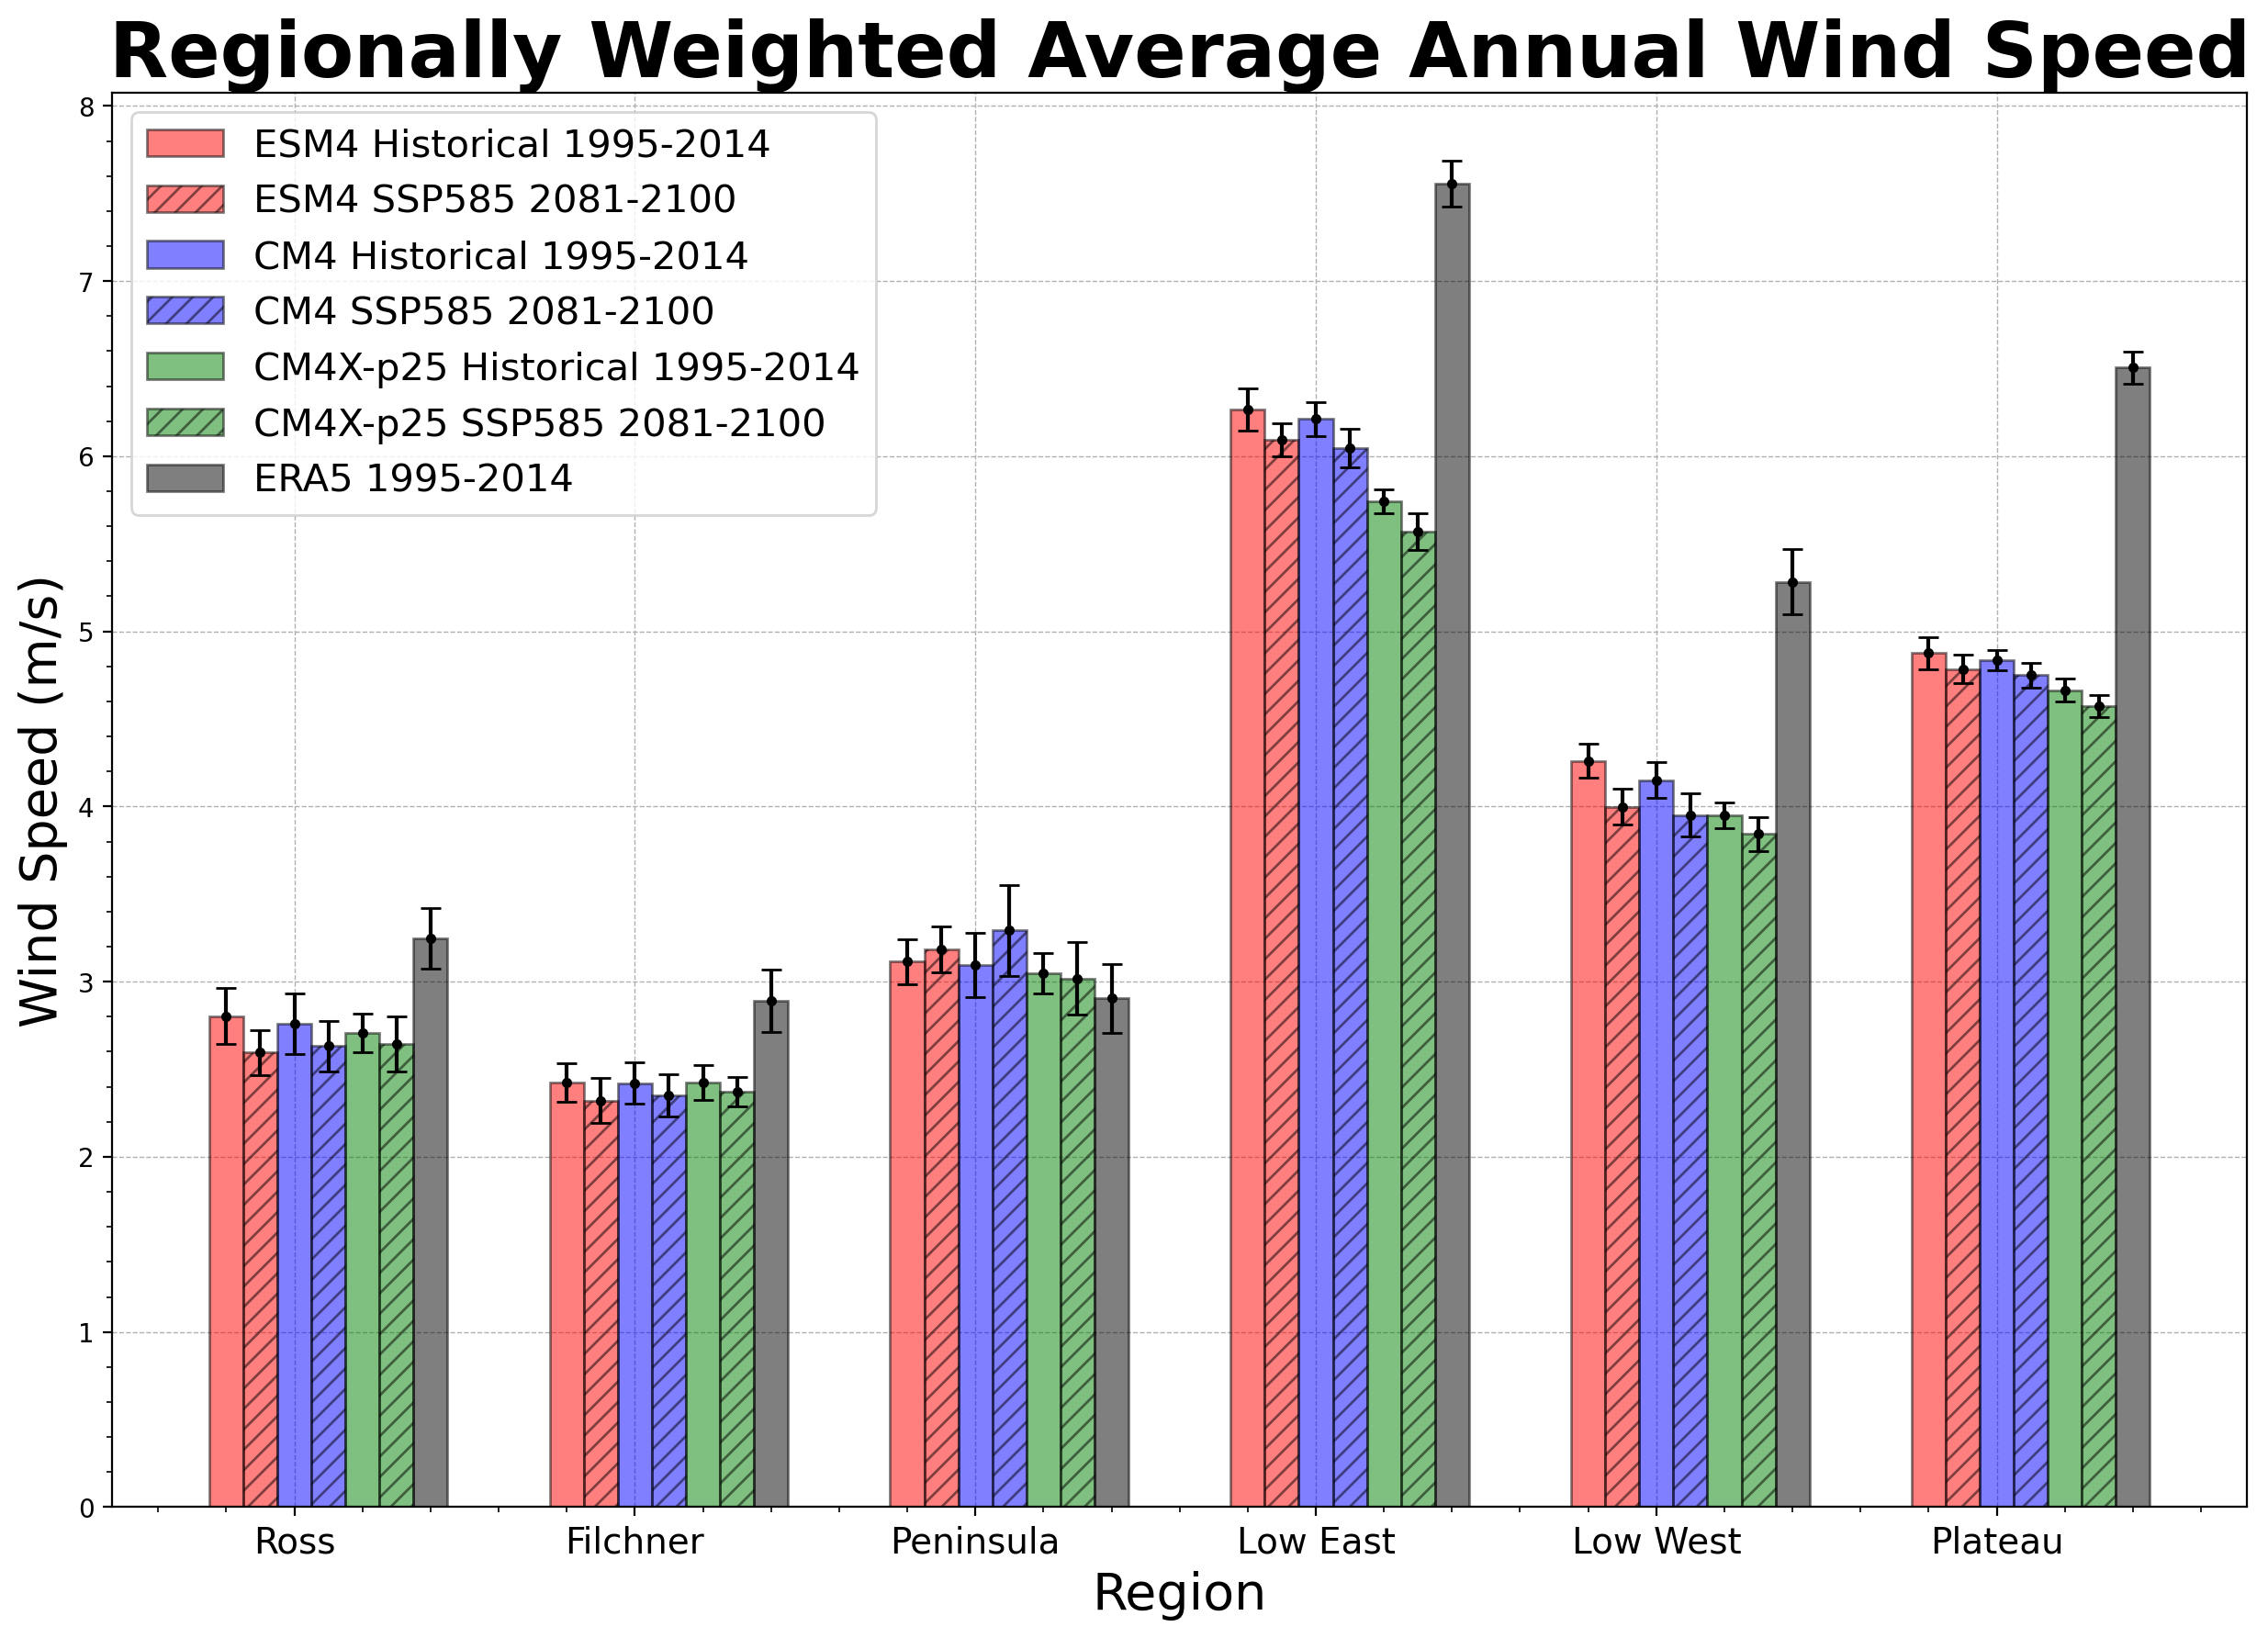

In [47]:
fig, ax= plt.subplots(figsize= (15,10))

## values for x axis
X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 

## wind speed values

CM4_his_total = [2.7586039094968076,
2.4195912406821987,
3.094716109453924,
6.211976413949223,
4.150494704310515,
4.836539051129336]


CM4_SSP585_total=[2.6317170423745715,
2.3490625199648396,
3.2933006720235043,
6.045567927095933,
3.950487411791641,
4.749599313239907]


ESM4_his_total = [2.803069743834134,
2.4226618213695037,
3.115702454547775,
6.26514061446025,
4.261426628325494,
4.876263966612993]


ESM4_SSP585_total=[2.595714832630887,
2.3216699895381314,
3.1836534357533766,
6.092952628445736,
3.9979060046815733,
4.785620492882357]


CM4X_his_total = [2.707052665947182,
2.425250093515665,
3.048734446913864,
5.7423339217165426,
3.9491663066799165,
4.6643710997910235]


CM4X_SSP585_total=[2.6419252513232294,
2.373134295339836,
3.019043346755505,
5.569188134588897,
3.843356946973128,
4.571322007188408]


ERA5_total = [3.2455826861036696,
2.889970017230057,
2.905384962772116,
7.557189498743699,
5.28279788329775,
6.505557591962576]

## std values
std_cm4_his=[0.17158510225715626,
0.11817219198043694,
0.18169725021596841,
0.09817008319299854,
0.10088205344595497,
0.05667772602999289]

std_cm4_ssp585=[0.14327832713051378,
0.11978373407780057,
0.25889964500103596,
0.10941602280378401,
0.12391352713855124,
0.07080870795745649]

std_esm4_his=[0.15885349939744364,
0.10943232422552186,
0.1285265812826608,
0.11954202730851318,
0.09860179221379871,
0.09259222616016305]

std_esm4_ssp585=[0.12902629421064504,
0.12842651843817465,
0.12940519610944134,
0.09493867878268651,
0.10271902113453689,
0.08259639956763354]

std_cm4x_his = [0.10797134933356226,
0.1009905601216712,
0.11599642090228435,
0.06843674704029752,
0.07505895345621165,
0.06702133318191811]

std_cm4x_ssp585= [0.15734486992848856,
0.08429887001789726,
0.20796800043922584,
0.10482678054215404,
0.09821386918037163,
0.06288855821790354]

std_era5= [0.17333950551848415,
0.17829699626851392,
0.1963079129280171,
0.13131070285887927,
0.18692206004806977,
0.09361697948455786]


## creating bar plot
X_axis = np.arange(len(X)) 

plt.bar(X_axis-0.2, ESM4_his_total, 0.1, label = 'ESM4 Historical 1995-2014', color='r',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis-0.2, ESM4_his_total,yerr= std_esm4_his,fmt='o', color= 'black', markersize=3, capsize=4)

plt.bar(X_axis-0.1, ESM4_SSP585_total, 0.1, label= 'ESM4 SSP585 2081-2100', color ='r', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis-0.1, ESM4_SSP585_total, yerr= std_esm4_ssp585, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis, CM4_his_total, 0.1, label = 'CM4 Historical 1995-2014', color= 'blue',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis, CM4_his_total, yerr=std_cm4_his, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.1,CM4_SSP585_total, 0.1, label='CM4 SSP585 2081-2100', color='blue', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.1, CM4_SSP585_total, yerr= std_cm4_ssp585, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.2, CM4X_his_total, 0.1, label= 'CM4X-p25 Historical 1995-2014', color='green', alpha=0.5,edgecolor='black')
plt.errorbar(X_axis+0.2, CM4X_his_total, yerr=std_cm4x_his, fmt= 'o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.3, CM4X_SSP585_total, 0.1, label='CM4X-p25 SSP585 2081-2100', color='green', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.3, CM4X_SSP585_total, yerr= std_cm4x_ssp585, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis + 0.4, ERA5_total, 0.1, label= 'ERA5 1995-2014', color= 'k', edgecolor='black', alpha=0.5)
plt.errorbar(X_axis+0.4, ERA5_total, yerr=std_era5, fmt='o', color='black', markersize=3, capsize=4)



ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Wind Speed (m/s)", fontsize=20 )
plt.title("Regionally Weighted Average Annual Wind Speed", fontsize=30,fontweight='bold') 
plt.legend(fontsize=15) 
ax.minorticks_on()
#plt.savefig('regionally_weighted_wind_speed.png')

---

# Spatial Difference Plots
to calculate difference: **SSP - Historical outputs**

## <span style="color:red">westerlies are represented in red

In [101]:
#difference between CM4 SSp858 and CM4 Historical Experiment Output
CM4_diff_spatial= ((cm4_ssp_speedmerge.weighted(cm4_ssp_weights).mean('time'))-(cm4_his_speedmerge.weighted(weights_cm4_his).mean('time')))
CM4_diff_spatial

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<sub, shape=(180, 288), dtype=float64, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

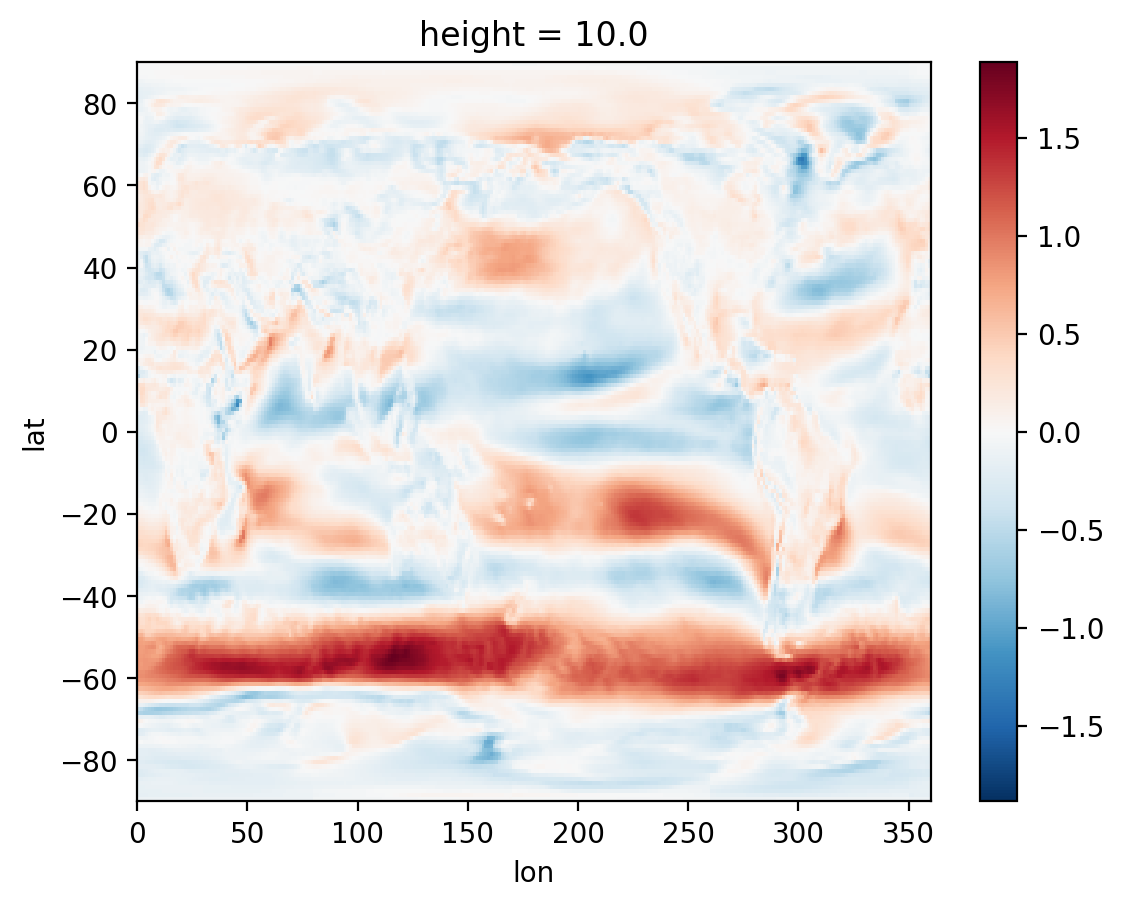

In [102]:
CM4_diff_spatial.plot()

In [103]:
ESM4_diff_spatial= ((esm4_ssp_speedmerge.weighted(weights_esm4_ssp).mean('time'))-(esm4_his_speedmerge.weighted(weights_esm4_his).mean('time')))
ESM4_diff_spatial

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<sub, shape=(180, 288), dtype=float64, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

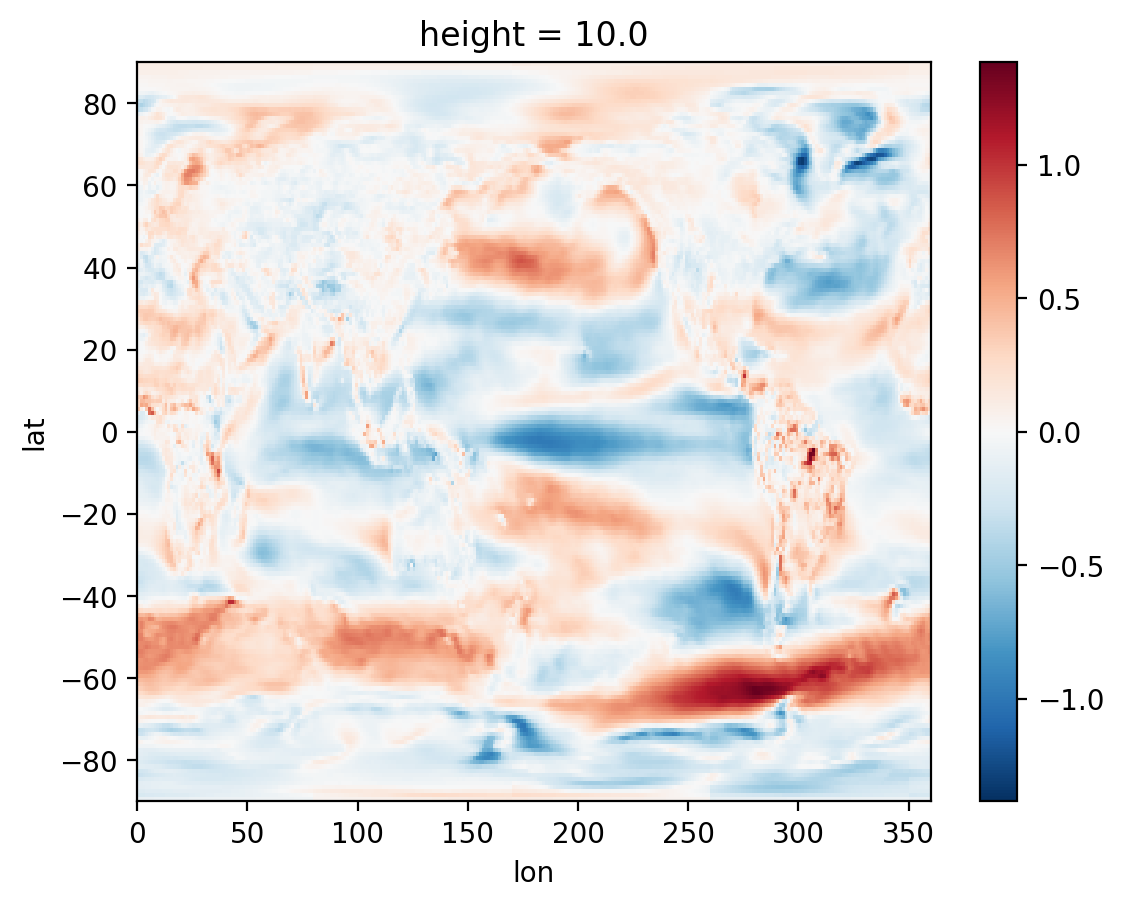

In [104]:
ESM4_diff_spatial.plot()

In [105]:
CM4X_diff_spatial= ((cm4x_ssp585_speedmerge.weighted(ssp_weights_cm4x).mean('time'))-(cm4x_his_speedmerge.weighted(weights_cm4x_his).mean('time')))
CM4X_diff_spatial

<xarray.DataArray (lat: 360, lon: 576)>
dask.array<sub, shape=(360, 576), dtype=float64, chunksize=(360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7

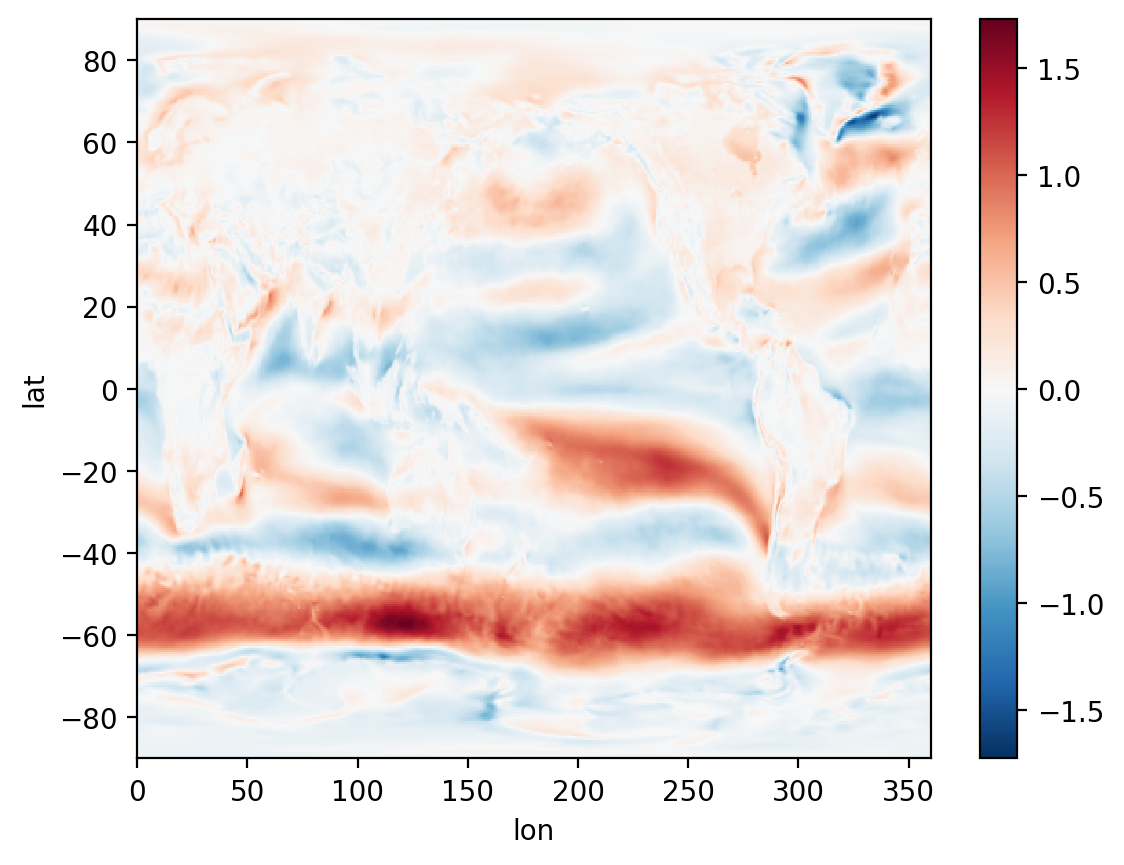

In [106]:
CM4X_diff_spatial.plot()

# Wind Speed Difference Bar Plot

In [107]:
CM4_diff_wind= np.array(cm4_ssp_wind_speeds)-np.array(cm4_his_wind_speeds)
CM4_diff_wind

array([-0.12688687, -0.07052872,  0.19858456, -0.16640849, -0.20000729,
       -0.08693974])

In [108]:
ESM4_diff_wind= np.array(esm4_ssp_wind_speeds)-np.array(esm4_his_wind_speeds)
ESM4_diff_wind

array([-0.20735491, -0.10099183,  0.06795098, -0.17218799, -0.26352062,
       -0.09064347])

In [109]:
CM4X_diff_wind=np.array(cm4x_ssp_wind_speeds)-np.array(cm4x_his_wind_speeds)
CM4X_diff_wind

array([-0.06512741, -0.0521158 , -0.0296911 , -0.17314579, -0.10580936,
       -0.09304909])

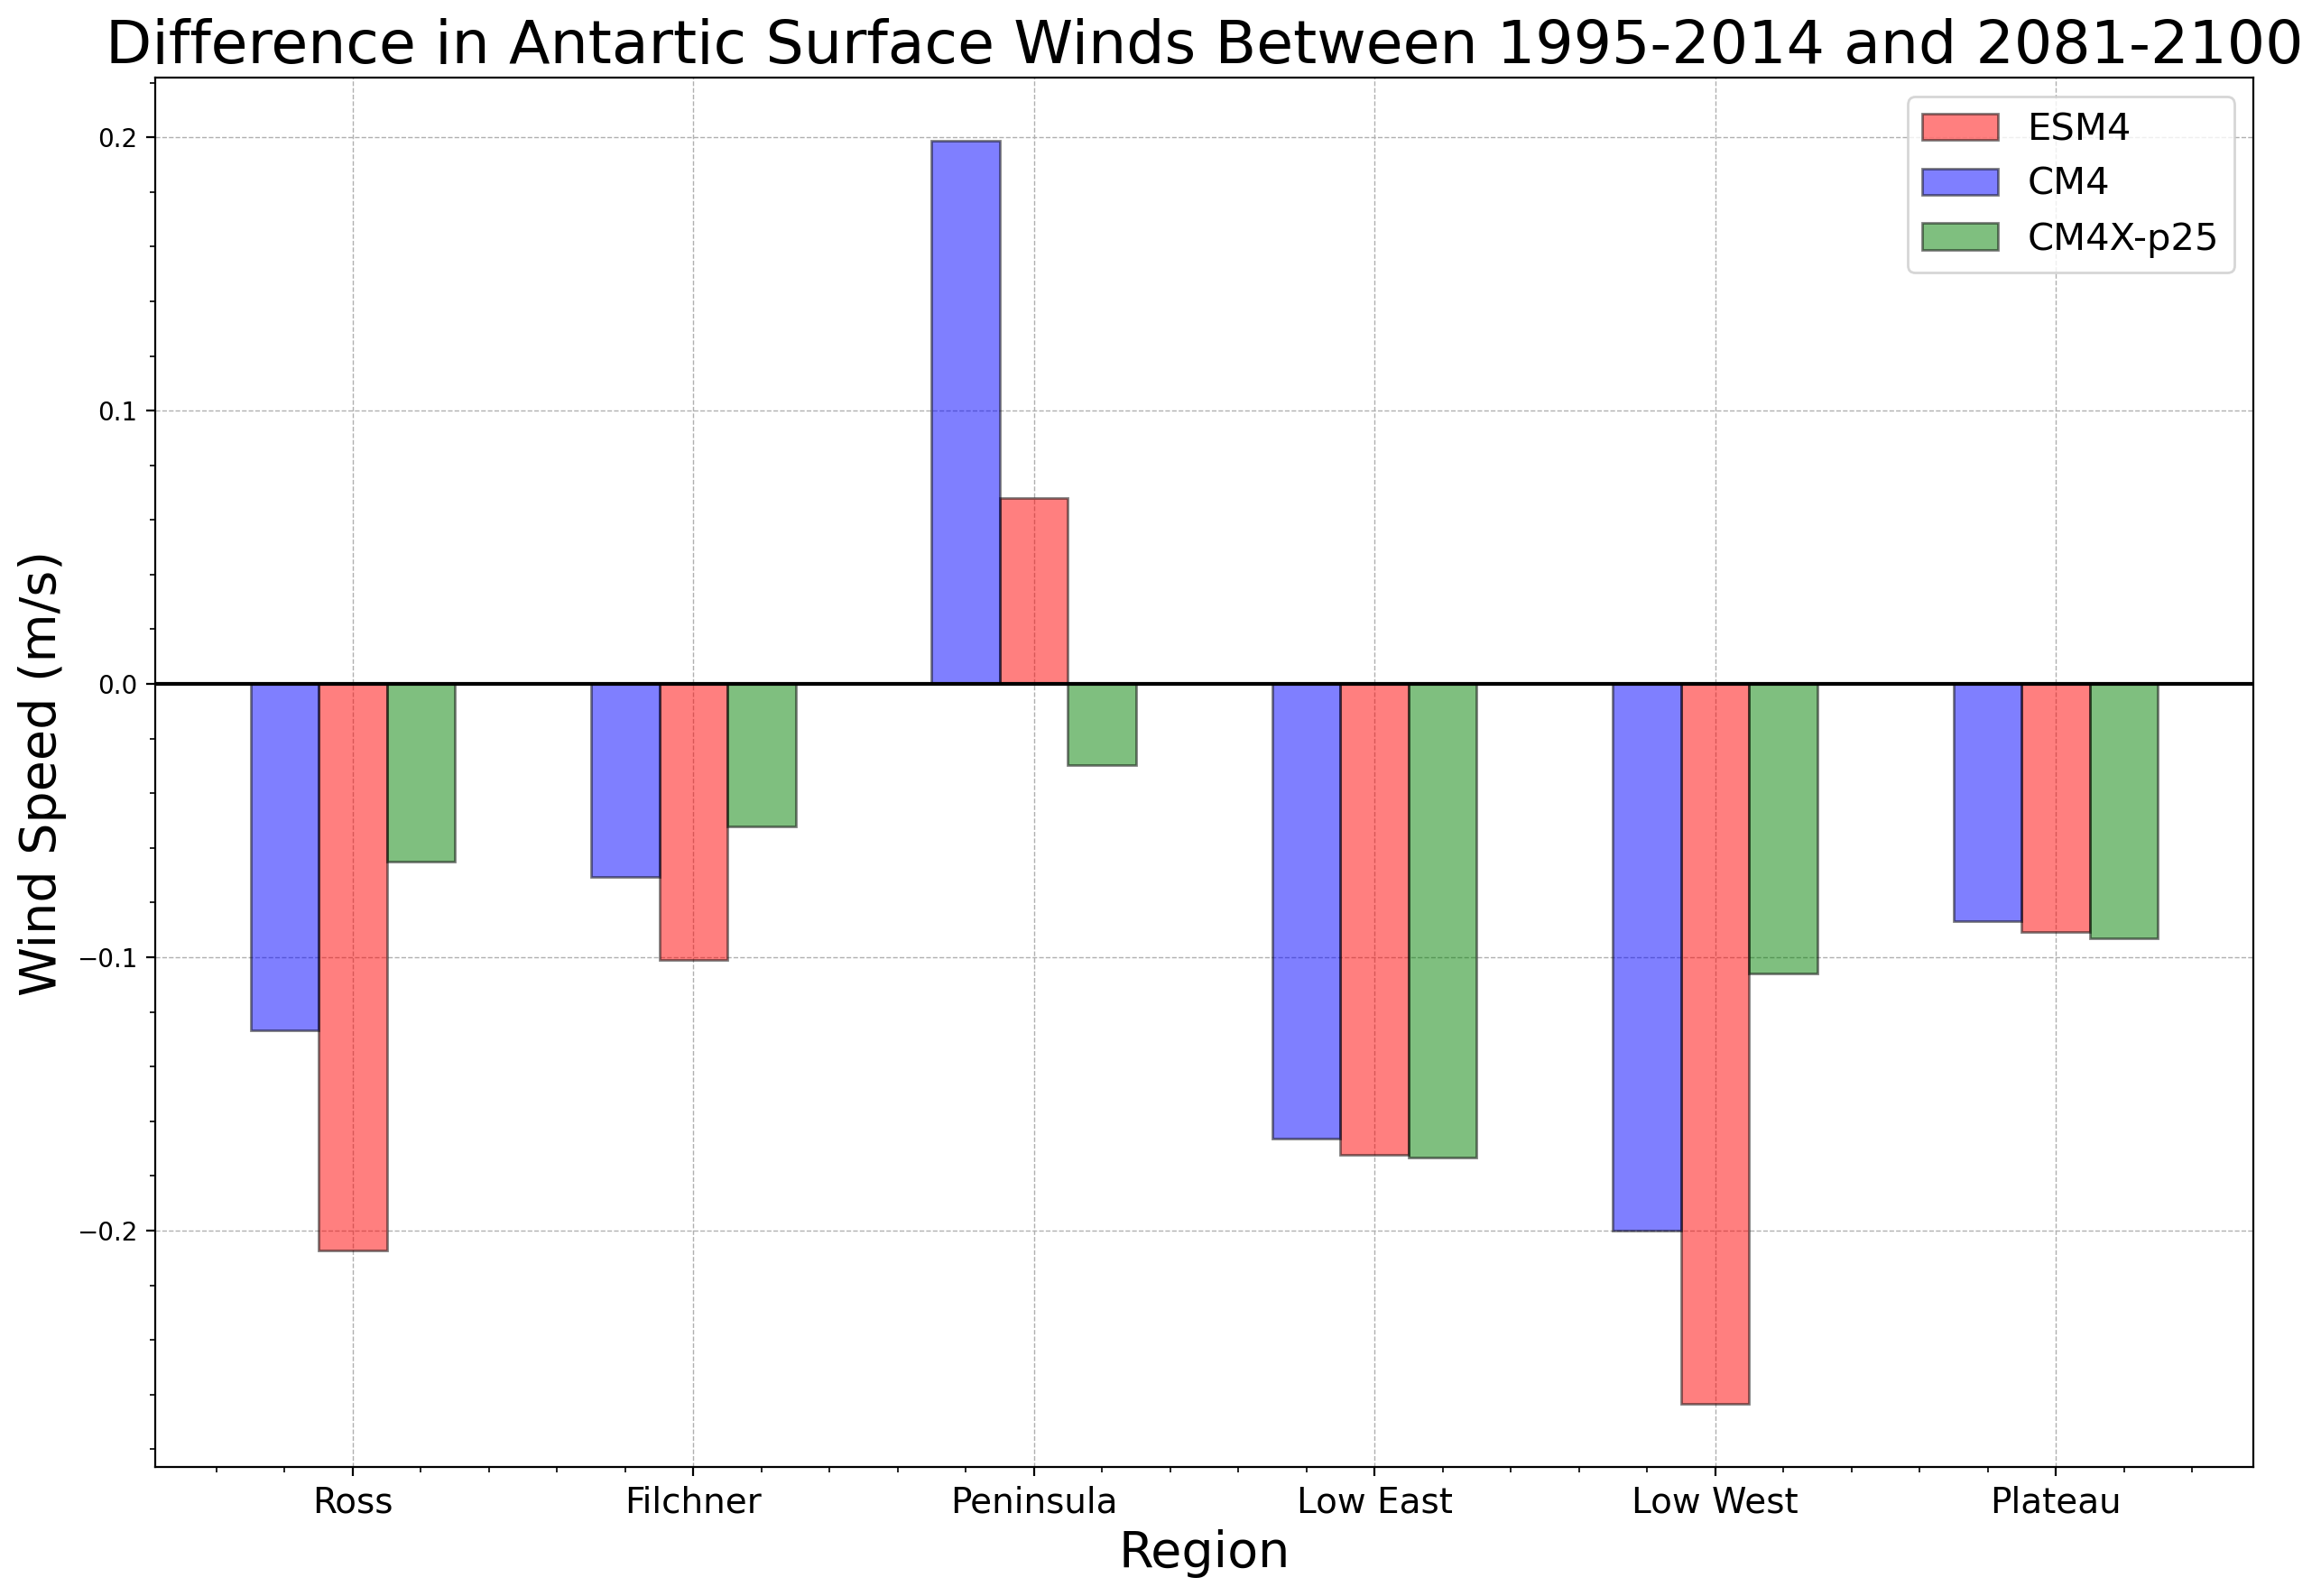

In [110]:
fig, ax= plt.subplots(figsize= (15,10))

X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 


CM4_diff=CM4_diff_wind
ESM4_diff=ESM4_diff_wind
CM4X_diff=CM4X_diff_wind


X_axis = np.arange(len(X)) 

plt.bar(X_axis, ESM4_diff, 0.2, label = 'ESM4', color='r', alpha=0.5, edgecolor='black') 
plt.bar(X_axis - 0.2, CM4_diff, 0.2, label = 'CM4', color= 'blue', alpha=0.5, edgecolor='black') 
plt.bar(X_axis + 0.2, CM4X_diff, 0.2, label= 'CM4X-p25', color= 'green', alpha=0.5,edgecolor='black')


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Wind Speed (m/s)", fontsize=20 )
plt.title("Difference in Antartic Surface Winds Between 1995-2014 and 2081-2100", fontsize=24) 
plt.legend(fontsize=15) 
ax.minorticks_on()
ax.axhline(0,color='k')


---

# Looking at the Changes in Eaterlies and Westerlies for the UAS component of wind

### CM4 difference

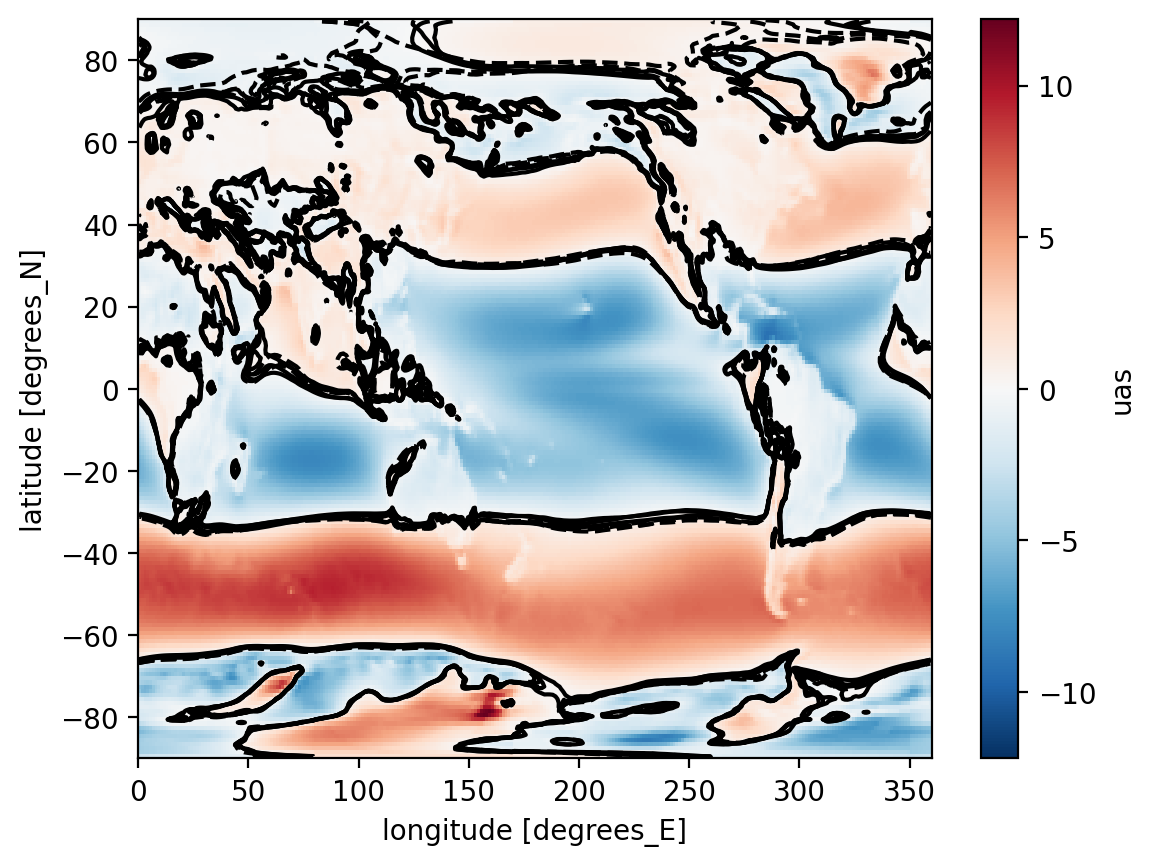

In [111]:
#taking cm4 historical and cm4 ssp to show the difference so we need esm4 historical and esm4 ssp and same with cm4x

#base plot
cm4_uas_his_time_slice.mean(dim='time').plot()

#CM4
cm4_uas_his_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k')
cm4_uas_ssp_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k',linestyles='--')

#ESM4
esm4_uas_his_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k')
esm4_uas_ssp_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k',linestyles='--')          

#CM4X
cm4x_uas_his.mean(dim='time').plot.contour(levels=[0],colors='k')
cm4x_uas_ssp585.mean(dim='time').plot.contour(levels=[0],colors='k',linestyles='--')

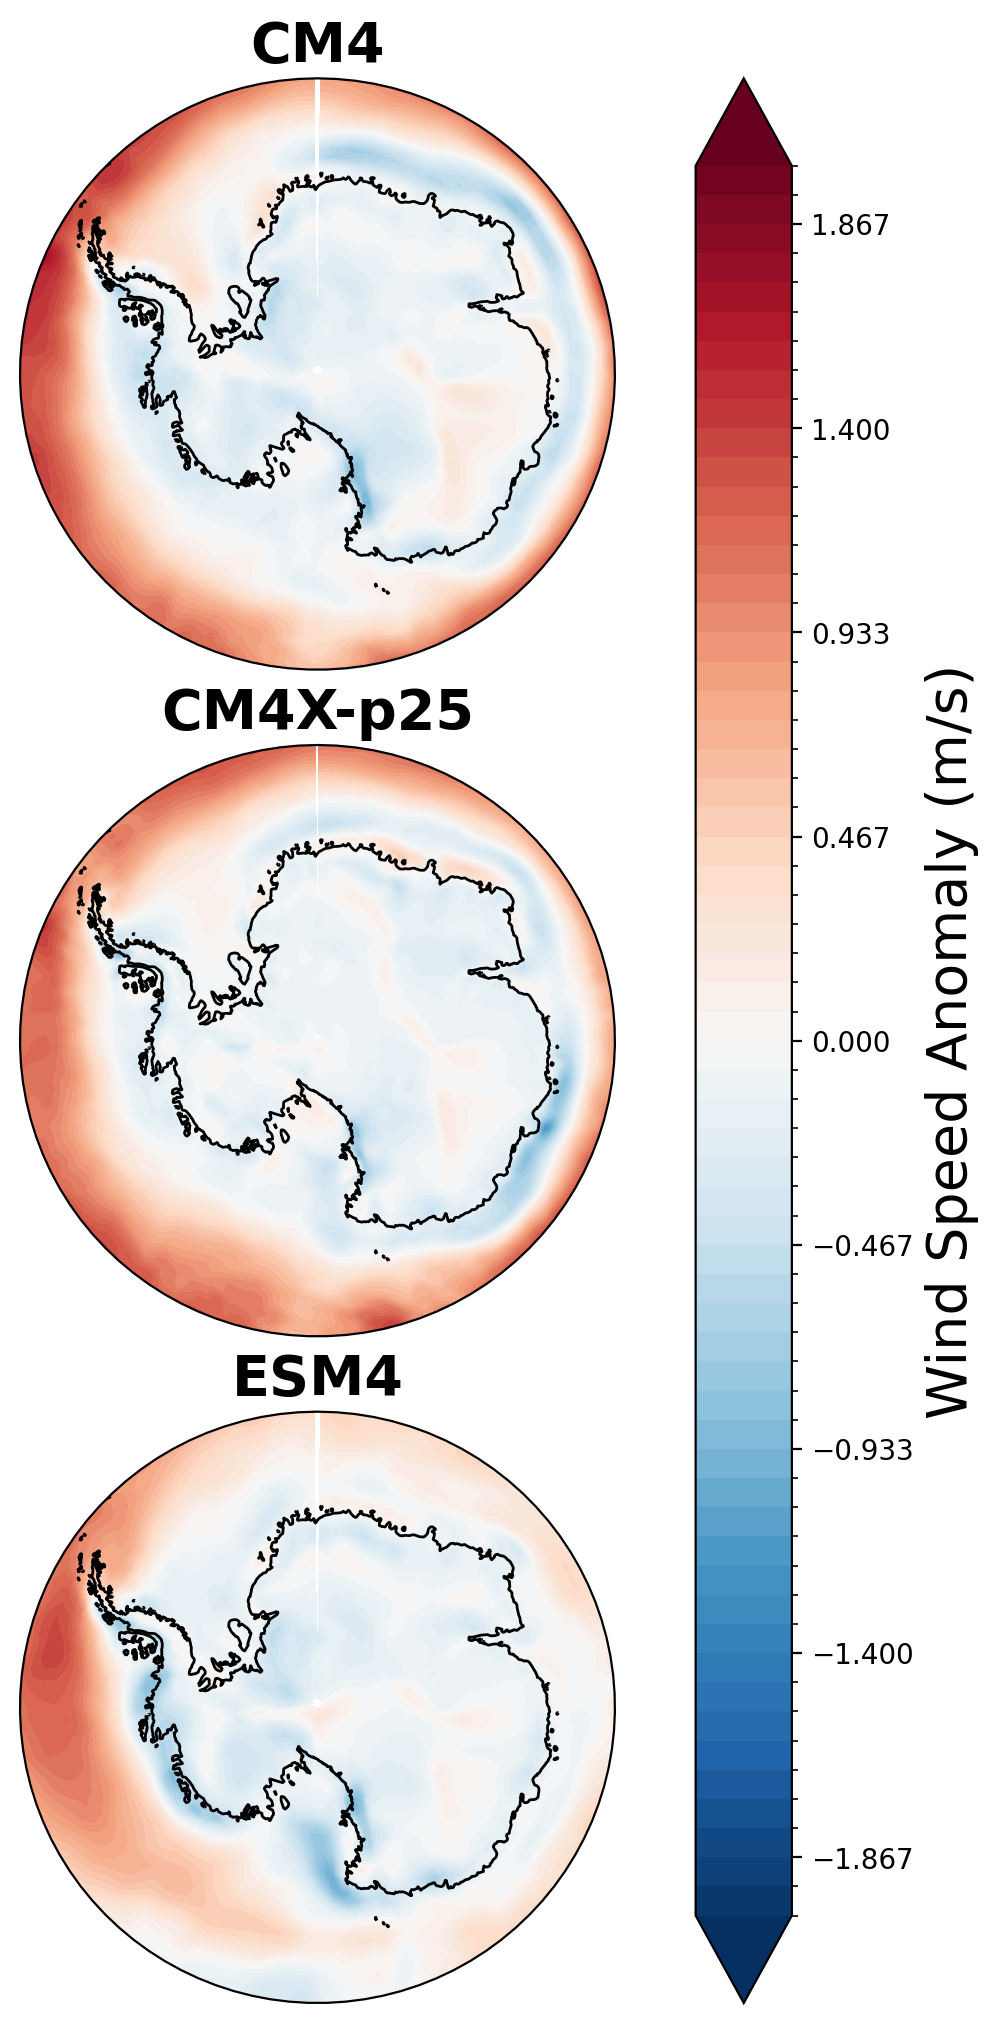

In [122]:
fig, ax = south_pole_map(rows=3, fig_size=(10, 10))

# Define the color map and levels
cmap = plt.get_cmap('RdBu_r')
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 61)  # 61 levels between vmin and vmax

p1 = CM4_diff_spatial.plot.contourf(ax=ax[0],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)


p2 = CM4X_diff_spatial.plot.contourf(ax=ax[1],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

p3 = ESM4_diff_spatial.plot.contourf(ax=ax[2],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

# Add coastlines
ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

# Set titles
ax[0].set_title('CM4', fontsize=20,fontweight='bold')
ax[1].set_title('CM4X-p25', fontsize=20,fontweight='bold')
ax[2].set_title('ESM4', fontsize=20,fontweight='bold')
#fig.suptitle('Difference in Wind Speeds Between 2081-2100 SSP585 and 1995-2014 Historical', fontsize=15, x=0.5)
# Create a single color bar for all three subplots
cbar = fig.colorbar(p1, ax=ax, orientation='vertical', fraction=0.5, pad=0.05)
cbar.set_label('Wind Speed Anomaly (m/s)', fontsize=20)  # Change this to your desired label

plt.show()

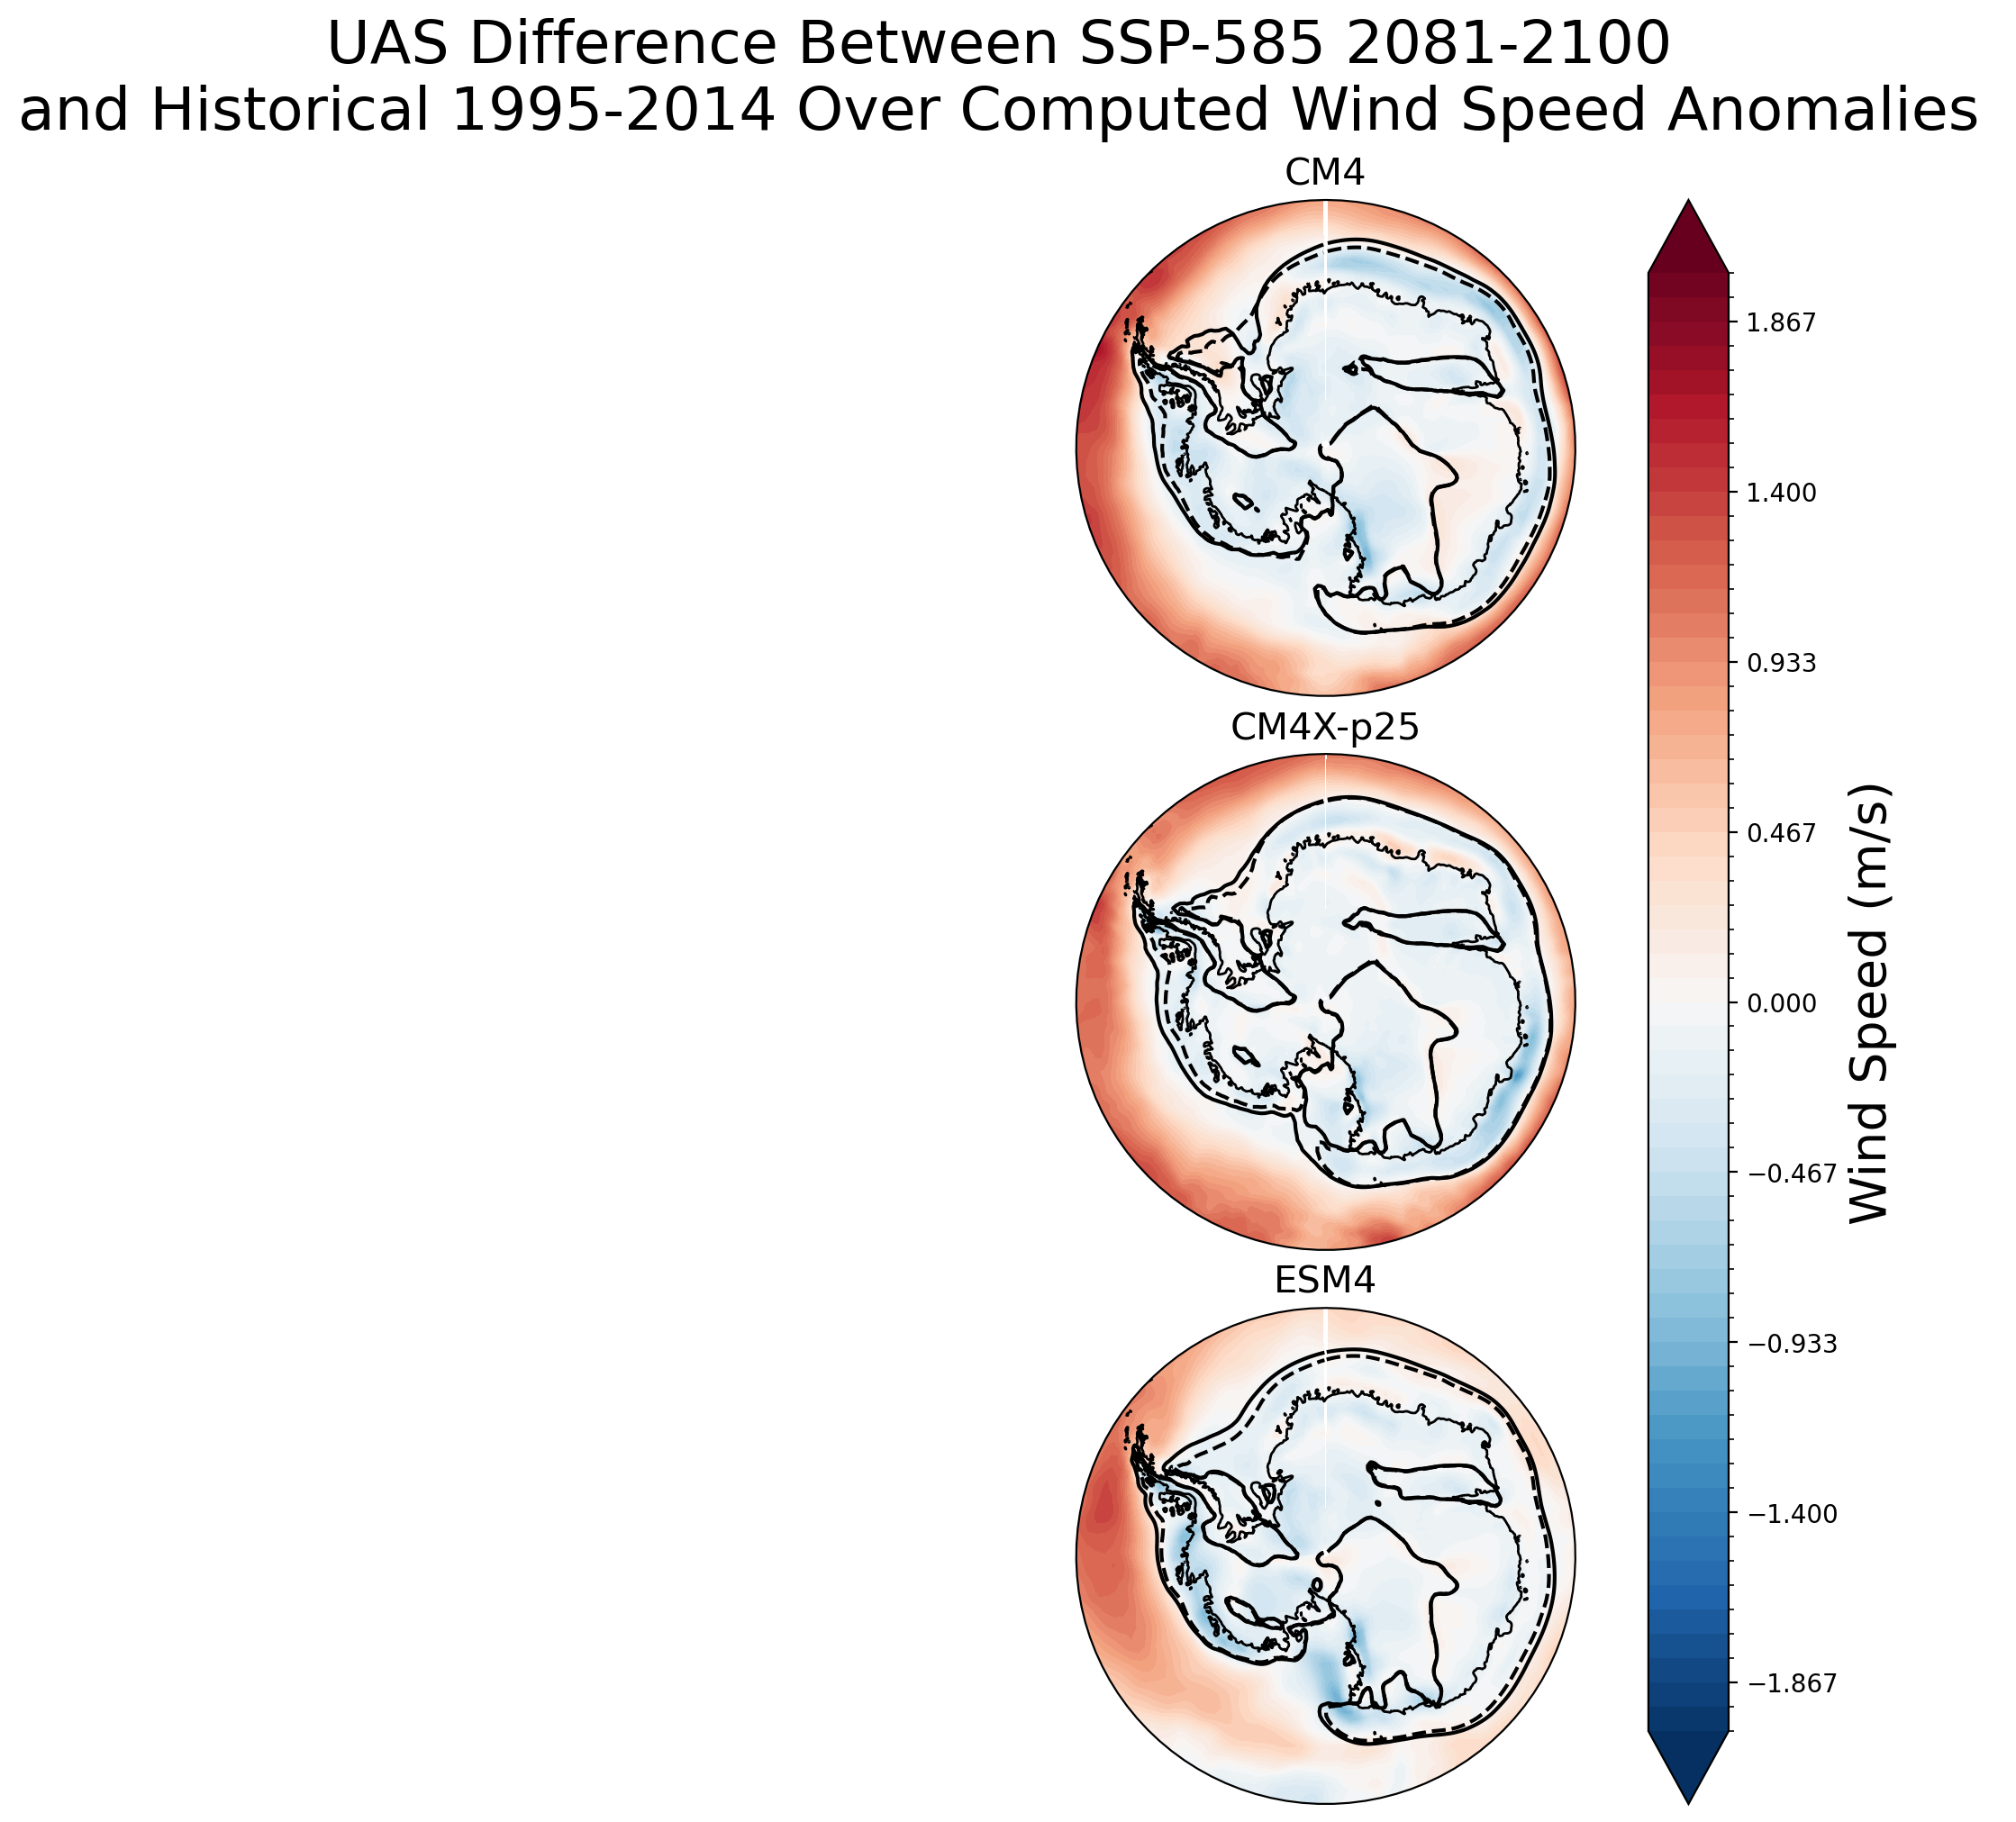

In [113]:
fig, ax = south_pole_map(rows=3, fig_size=(10, 10))

# Define the color map and levels
cmap = plt.get_cmap('RdBu_r')
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 61)  # 61 levels between vmin and vmax

p1 = CM4_diff_spatial.plot.contourf(ax=ax[0],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)


p2 = CM4X_diff_spatial.plot.contourf(ax=ax[1],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

p3 = ESM4_diff_spatial.plot.contourf(ax=ax[2],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

# Plot additional contours on the first subplot
cm4_uas_his_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4_uas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#esm4
esm4_uas_his_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

esm4_uas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#cm4x
cm4x_uas_his.mean(dim='time').plot.contour(ax=ax[2], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4x_uas_ssp585.mean(dim='time').plot.contour(ax=ax[2], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
# Add coastlines
ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

# Set titles
ax[0].set_title('CM4', fontsize=15)
ax[1].set_title('CM4X-p25', fontsize=15)
ax[2].set_title('ESM4', fontsize=15)
#fig.suptitle('UAS Difference Between SSP-585 2081-2100 \nand Historical 1995-2014 Over Computed Wind Speed Anomalies ', fontsize=24, x=0.5)
# Create a single color bar for all three subplots
cbar = fig.colorbar(p1, ax=ax, orientation='vertical', fraction=0.5, pad=0.05)
cbar.set_label('Wind Speed (m/s)', fontsize=20)  # Change this to your desired label

plt.show()

# UAS Spatial Differences

In [114]:
CM4_u_diff_spatial= ((cm4_uas_ssp_time_slice.weighted(weights_cm4_ssp_uas).mean('time'))-(cm4_uas_his_time_slice.weighted(weights_cm4_his_uas).mean('time')))
CM4_u_diff_spatial

NameError: name 'weights_cm4_ssp_uas' is not defined

In [ ]:
ESM4_u_diff_spatial= ((esm4_uas_ssp_time_slice.weighted(weights_esm4_ssp_uas).mean('time'))-(esm4_uas_his_time_slice.weighted(weights_esm4_his_uas).mean('time')))
ESM4_u_diff_spatial

In [ ]:
CM4X_u_diff_spatial= ((cm4x_uas_ssp585.weighted(ssp_weights_cm4x_vas_uas).mean('time'))-(cm4x_uas_his.weighted(weights_cm4x_his).mean('time')))
CM4X_u_diff_spatial

In [ ]:
## this plot shows the spatial differences of the UAS component contoured while the other one is computed wind speed
fig, ax = south_pole_map(rows=3, fig_size=(10, 10))

# Define the color map and levels
cmap = plt.get_cmap('RdBu_r')
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 61)  # 61 levels between vmin and vmax

p1 = CM4_u_diff_spatial.plot.contourf(ax=ax[0],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)


p2 = CM4X_u_diff_spatial.plot.contourf(ax=ax[1],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

p3 = ESM4_u_diff_spatial.plot.contourf(ax=ax[2],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

# Plot additional contours on the first subplot
cm4_uas_his_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4_uas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#esm4
esm4_uas_his_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

esm4_uas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#cm4x
cm4x_uas_his.mean(dim='time').plot.contour(ax=ax[2], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4x_uas_ssp585.mean(dim='time').plot.contour(ax=ax[2], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
# Add coastlines
ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

# Set titles
ax[0].set_title('CM4', fontsize=15)
ax[1].set_title('CM4X-p25', fontsize=15)
ax[2].set_title('ESM4', fontsize=15)
fig.suptitle('UAS Difference Between SSP-585 2081-2100 \nand Historical 1995-2014 ', fontsize=24, x=0.5)
# Create a single color bar for all three subplots
cbar = fig.colorbar(p1, ax=ax, orientation='vertical', fraction=0.5, pad=0.05)
cbar.set_label('Wind Speed (m/s)', fontsize=20)  # Change this to your desired label

plt.show()

--- 

# Spatially Weighted UAS Wind Component

# CM4 Historical UAS

In [ ]:
lat_CM4_historical_uas = cm4_uas_his_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_historical_uas = cm4_uas_his_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4_historical_uas,lon_CM4_historical_uas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_historical_uas = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_uas_his_time_slice.coords['lat'],\
                                                        cm4_uas_his_time_slice.coords['lon']))

In [ ]:
weights_cm4_his_uas=areacell_CM4_historical_uas

In [ ]:
weight_ross_CM4_historical_uas=(mask_CM4.total_mask.where(mask_CM4.total==1)*cm4_uas_his_time_slice).weighted(weights_cm4_his_uas).mean(dim=['lat','lon'])
weight_filchner_CM4_historical_uas=(mask_CM4.total_mask.where(mask_CM4.total==3)*cm4_uas_his_time_slice).weighted(weights_cm4_his_uas).mean(dim=['lat','lon'])
weight_peninsula_CM4_historical_uas= (mask_CM4.total_mask.where(mask_CM4.total==4)*cm4_uas_his_time_slice).weighted(weights_cm4_his_uas).mean(dim=['lat','lon'])
weight_loweast_CM4_historical_uas=(mask_CM4.total_mask.where(mask_CM4.total==5)*cm4_uas_his_time_slice).weighted(weights_cm4_his_uas).mean(dim=['lat','lon'])
weight_lowwest_CM4_historical_uas=(mask_CM4.total_mask.where(mask_CM4.total==6)*cm4_uas_his_time_slice).weighted(weights_cm4_his_uas).mean(dim=['lat','lon'])
weight_plateau_CM4_historical_uas= (mask_CM4.total_mask.where(mask_CM4.total==2)*cm4_uas_his_time_slice).weighted(weights_cm4_his_uas).mean(dim=['lat','lon'])

In [ ]:
weight_ross_cm4_annual_historical_uas = ml.util.annual_average(weight_ross_CM4_historical_uas,tcoord='time')
weight_filchner_cm4_annual_historical_uas= ml.util.annual_average(weight_filchner_CM4_historical_uas, tcoord='time')
weight_peninsula_cm4_annual_historical_uas=ml.util.annual_average(weight_peninsula_CM4_historical_uas, tcoord='time')
weight_loweast_cm4_annual_historical_uas=ml.util.annual_average(weight_loweast_CM4_historical_uas, tcoord='time')
weight_lowwest_cm4_annual_historical_uas=ml.util.annual_average(weight_lowwest_CM4_historical_uas, tcoord='time')
weight_plateau_cm4_annual_historical_uas=ml.util.annual_average(weight_plateau_CM4_historical_uas, tcoord='time')

In [ ]:
cm4_his_ross_uas_wind=weight_ross_cm4_annual_historical_uas.mean(dim='time')
cm4_his_filch_uas_wind=weight_filchner_cm4_annual_historical_uas.mean(dim='time')
cm4_his_pen_uas_wind=weight_peninsula_cm4_annual_historical_uas.mean(dim='time')
cm4_his_east_uas_wind=weight_loweast_cm4_annual_historical_uas.mean(dim='time')
cm4_his_west_uas_wind=weight_lowwest_cm4_annual_historical_uas.mean(dim='time')
cm4_his_plat_uas_wind=weight_plateau_cm4_annual_historical_uas.mean(dim='time')

In [ ]:
print(cm4_his_ross_uas_wind.values)
print(cm4_his_filch_uas_wind.values/3)
print(cm4_his_pen_uas_wind.values/4)
print(cm4_his_east_uas_wind.values/5)
print(cm4_his_west_uas_wind.values/6)
print(cm4_his_plat_uas_wind.values/2)

In [ ]:
ross_total_std_CM4_uas= weight_ross_cm4_annual_historical_uas.std('time')
filchner_total_std_CM4_uas= weight_filchner_cm4_annual_historical_uas.std('time')
peninsula_total_std_CM4_uas=weight_peninsula_cm4_annual_historical_uas.std('time')
loweast_total_std_CM4_uas=weight_loweast_cm4_annual_historical_uas.std('time')
lowwest_total_std_CM4_uas=weight_lowwest_cm4_annual_historical_uas.std('time')
plateau_total_std_CM4_uas=weight_plateau_cm4_annual_historical_uas.std('time')

In [ ]:
print(ross_total_std_CM4_uas.values)
print(filchner_total_std_CM4_uas.values/3)
print(peninsula_total_std_CM4_uas.values/4)
print(loweast_total_std_CM4_uas.values/5)
print(lowwest_total_std_CM4_uas.values/6)
print(plateau_total_std_CM4_uas.values/2)

# CM4 SSP585 UAS

In [ ]:
lat_CM4_ssp_uas = cm4_uas_ssp_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_ssp_uas = cm4_uas_ssp_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
cm4_ssp_uas_areacell = standard_grid_cell_area(lat_CM4_ssp_uas,lon_CM4_ssp_uas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_ssp_uas = xr.DataArray(cm4_ssp_uas_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_uas_ssp_time_slice.coords['lat'],\
                                                        cm4_uas_ssp_time_slice.coords['lon']))

In [ ]:
weights_cm4_ssp_uas=areacell_CM4_ssp_uas

In [ ]:
weight_ross_CM4_ssp_uas=(mask_CM4.total_mask.where(mask_CM4.total==1)*cm4_uas_ssp_time_slice).weighted(weights_cm4_ssp_uas).mean(dim=['lat','lon'])
weight_filchner_CM4_ssp_uas=(mask_CM4.total_mask.where(mask_CM4.total==3)*cm4_uas_ssp_time_slice).weighted(weights_cm4_ssp_uas).mean(dim=['lat','lon'])
weight_peninsula_CM4_ssp_uas= (mask_CM4.total_mask.where(mask_CM4.total==4)*cm4_uas_ssp_time_slice).weighted(weights_cm4_ssp_uas).mean(dim=['lat','lon'])
weight_loweast_CM4_ssp_uas=(mask_CM4.total_mask.where(mask_CM4.total==5)*cm4_uas_ssp_time_slice).weighted(weights_cm4_ssp_uas).mean(dim=['lat','lon'])
weight_lowwest_CM4_ssp_uas=(mask_CM4.total_mask.where(mask_CM4.total==6)*cm4_uas_ssp_time_slice).weighted(weights_cm4_ssp_uas).mean(dim=['lat','lon'])
weight_plateau_CM4_ssp_uas= (mask_CM4.total_mask.where(mask_CM4.total==2)*cm4_uas_ssp_time_slice).weighted(weights_cm4_ssp_uas).mean(dim=['lat','lon'])

In [ ]:
weight_ross_cm4_annual_ssp_uas = ml.util.annual_average(weight_ross_CM4_ssp_uas,tcoord='time')
weight_filchner_cm4_annual_ssp_uas= ml.util.annual_average(weight_filchner_CM4_ssp_uas, tcoord='time')
weight_peninsula_cm4_annual_ssp_uas=ml.util.annual_average(weight_peninsula_CM4_ssp_uas, tcoord='time')
weight_loweast_cm4_annual_ssp_uas=ml.util.annual_average(weight_loweast_CM4_ssp_uas, tcoord='time')
weight_lowwest_cm4_annual_ssp_uas=ml.util.annual_average(weight_lowwest_CM4_ssp_uas, tcoord='time')
weight_plateau_cm4_annual_ssp_uas=ml.util.annual_average(weight_plateau_CM4_ssp_uas, tcoord='time')

In [ ]:
cm4_ssp_uas_ross_wind=weight_ross_cm4_annual_ssp_uas.mean(dim='time')
cm4_ssp_uas_filch_wind=weight_filchner_cm4_annual_ssp_uas.mean(dim='time')
cm4_ssp_uas_pen_wind=weight_peninsula_cm4_annual_ssp_uas.mean(dim='time')
cm4_ssp_uas_east_wind=weight_loweast_cm4_annual_ssp_uas.mean(dim='time')
cm4_ssp_uas_west_wind=weight_lowwest_cm4_annual_ssp_uas.mean(dim='time')
cm4_ssp_uas_plat_wind=weight_plateau_cm4_annual_ssp_uas.mean(dim='time')

In [ ]:
print(cm4_ssp_uas_ross_wind.values)
print(cm4_ssp_uas_filch_wind.values/3)
print(cm4_ssp_uas_pen_wind.values/4)
print(cm4_ssp_uas_east_wind.values/5)
print(cm4_ssp_uas_west_wind.values/6)
print(cm4_ssp_uas_plat_wind.values/2)

In [ ]:
ross_total_std_CM4_ssp_uas= weight_ross_cm4_annual_ssp_uas.std('time')
filchner_total_std_CM4_ssp_uas= weight_filchner_cm4_annual_ssp_uas.std('time')
peninsula_total_std_CM4_ssp_uas=weight_peninsula_cm4_annual_ssp_uas.std('time')
loweast_total_std_CM4_ssp_uas=weight_loweast_cm4_annual_ssp_uas.std('time')
lowwest_total_std_CM4_ssp_uas=weight_lowwest_cm4_annual_ssp_uas.std('time')
plateau_total_std_CM4_ssp_uas=weight_plateau_cm4_annual_ssp_uas.std('time')

In [ ]:
print(ross_total_std_CM4_ssp_uas.values)
print(filchner_total_std_CM4_ssp_uas.values/3)
print(peninsula_total_std_CM4_ssp_uas.values/4)
print(loweast_total_std_CM4_ssp_uas.values/5)
print(lowwest_total_std_CM4_ssp_uas.values/6)
print(plateau_total_std_CM4_ssp_uas.values/2)

# ESM4 Historical UAS

In [ ]:
lat_esm4_historical_uas = esm4_uas_his_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_historical_uas = esm4_uas_his_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_his_areacell_uas = standard_grid_cell_area(lat_esm4_historical_uas,lon_esm4_historical_uas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_historical_uas = xr.DataArray(esm4_his_areacell_uas,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_uas_his_time_slice.coords['lat'],\
                                                        esm4_uas_his_time_slice.coords['lon']))

In [ ]:
weights_esm4_his_uas=areacell_esm4_historical_uas

In [ ]:
weight_ross_ESM4_historical_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==1)*esm4_uas_his_time_slice).weighted(weights_esm4_his_uas).mean(dim=['lat','lon'])
weight_filchner_ESM4_historical_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==3)*esm4_uas_his_time_slice).weighted(weights_esm4_his_uas).mean(dim=['lat','lon'])
weight_peninsula_ESM4_historical_uas= (mask_ESM4.total_mask.where(mask_ESM4.total==4)*esm4_uas_his_time_slice).weighted(weights_esm4_his_uas).mean(dim=['lat','lon'])
weight_loweast_ESM4_historical_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==5)*esm4_uas_his_time_slice).weighted(weights_esm4_his_uas).mean(dim=['lat','lon'])
weight_lowwest_ESM4_historical_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==6)*esm4_uas_his_time_slice).weighted(weights_esm4_his_uas).mean(dim=['lat','lon'])
weight_plateau_ESM4_historical_uas= (mask_ESM4.total_mask.where(mask_ESM4.total==2)*esm4_uas_his_time_slice).weighted(weights_esm4_his_uas).mean(dim=['lat','lon'])

In [ ]:
weight_ross_ESM4_annual_historical_uas = ml.util.annual_average(weight_ross_ESM4_historical_uas,tcoord='time')
weight_filchner_ESM4_annual_historical_uas= ml.util.annual_average(weight_filchner_ESM4_historical_uas, tcoord='time')
weight_peninsula_ESM4_annual_historical_uas=ml.util.annual_average(weight_peninsula_ESM4_historical_uas, tcoord='time')
weight_loweast_ESM4_annual_historical_uas=ml.util.annual_average(weight_loweast_ESM4_historical_uas, tcoord='time')
weight_lowwest_ESM4_annual_historical_uas=ml.util.annual_average(weight_lowwest_ESM4_historical_uas, tcoord='time')
weight_plateau_ESM4_annual_historical_uas=ml.util.annual_average(weight_plateau_ESM4_historical_uas, tcoord='time')

In [ ]:
ESM4_historical_uas_ross_wind=weight_ross_ESM4_annual_historical_uas.mean(dim='time')
ESM4_historical_uas_filch_wind=weight_filchner_ESM4_annual_historical_uas.mean(dim='time')
ESM4_historical_uas_pen_wind=weight_peninsula_ESM4_annual_historical_uas.mean(dim='time')
ESM4_historical_uas_east_wind=weight_loweast_ESM4_annual_historical_uas.mean(dim='time')
ESM4_historical_uas_west_wind=weight_lowwest_ESM4_annual_historical_uas.mean(dim='time')
ESM4_historical_uas_plat_wind=weight_plateau_ESM4_annual_historical_uas.mean(dim='time')

In [ ]:
print(ESM4_historical_uas_ross_wind.values)
print(ESM4_historical_uas_filch_wind.values/3)
print(ESM4_historical_uas_pen_wind.values/4)
print(ESM4_historical_uas_east_wind.values/5)
print(ESM4_historical_uas_west_wind.values/6)
print(ESM4_historical_uas_plat_wind.values/2)

In [ ]:
ross_total_std_ESM4_uas= weight_ross_ESM4_annual_historical_uas.std('time')
filchner_total_std_ESM4_uas= weight_filchner_ESM4_annual_historical_uas.std('time')
peninsula_total_std_ESM4_uas=weight_peninsula_ESM4_annual_historical_uas.std('time')
loweast_total_std_ESM4_uas=weight_loweast_ESM4_annual_historical_uas.std('time')
lowwest_total_std_ESM4_uas=weight_lowwest_ESM4_annual_historical_uas.std('time')
plateau_total_std_ESM4_uas=weight_plateau_ESM4_annual_historical_uas.std('time')

In [ ]:
print(ross_total_std_ESM4_uas.values)
print(filchner_total_std_ESM4_uas.values/3)
print(peninsula_total_std_ESM4_uas.values/4)
print(loweast_total_std_ESM4_uas.values/5)
print(lowwest_total_std_ESM4_uas.values/6)
print(plateau_total_std_ESM4_uas.values/2)

# ESM4 SSP585 UAS

In [ ]:
lat_esm4_ssp_uas = esm4_uas_ssp_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_ssp_uas = esm4_uas_ssp_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_ssp_areacell_uas = standard_grid_cell_area(lat_esm4_ssp_uas,lon_esm4_ssp_uas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_ssp_uas = xr.DataArray(esm4_ssp_areacell_uas,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_uas_ssp_time_slice.coords['lat'],\
                                                        esm4_uas_ssp_time_slice.coords['lon']))

In [ ]:
weights_esm4_ssp_uas=areacell_esm4_ssp_uas

In [ ]:
weight_ross_ESM4_ssp_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==1)*esm4_uas_ssp_time_slice).weighted(weights_esm4_ssp_uas).mean(dim=['lat','lon'])
weight_filchner_ESM4_ssp_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==3)*esm4_uas_ssp_time_slice).weighted(weights_esm4_ssp_uas).mean(dim=['lat','lon'])
weight_peninsula_ESM4_ssp_uas= (mask_ESM4.total_mask.where(mask_ESM4.total==4)*esm4_uas_ssp_time_slice).weighted(weights_esm4_ssp_uas).mean(dim=['lat','lon'])
weight_loweast_ESM4_ssp_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==5)*esm4_uas_ssp_time_slice).weighted(weights_esm4_ssp_uas).mean(dim=['lat','lon'])
weight_lowwest_ESM4_ssp_uas=(mask_ESM4.total_mask.where(mask_ESM4.total==6)*esm4_uas_ssp_time_slice).weighted(weights_esm4_ssp_uas).mean(dim=['lat','lon'])
weight_plateau_ESM4_ssp_uas= (mask_ESM4.total_mask.where(mask_ESM4.total==2)*esm4_uas_ssp_time_slice).weighted(weights_esm4_ssp_uas).mean(dim=['lat','lon'])

In [ ]:
weight_ross_ESM4_annual_ssp_uas = ml.util.annual_average(weight_ross_ESM4_ssp_uas,tcoord='time')
weight_filchner_ESM4_annual_ssp_uas= ml.util.annual_average(weight_filchner_ESM4_ssp_uas, tcoord='time')
weight_peninsula_ESM4_annual_ssp_uas=ml.util.annual_average(weight_peninsula_ESM4_ssp_uas, tcoord='time')
weight_loweast_ESM4_annual_ssp_uas=ml.util.annual_average(weight_loweast_ESM4_ssp_uas, tcoord='time')
weight_lowwest_ESM4_annual_ssp_uas=ml.util.annual_average(weight_lowwest_ESM4_ssp_uas, tcoord='time')
weight_plateau_ESM4_annual_ssp_uas=ml.util.annual_average(weight_plateau_ESM4_ssp_uas, tcoord='time')

In [ ]:
ESM4_ssp_uas_ross_wind=weight_ross_ESM4_annual_ssp_uas.mean(dim='time')
ESM4_ssp_uas_filch_wind=weight_filchner_ESM4_annual_ssp_uas.mean(dim='time')
ESM4_ssp_uas_pen_wind=weight_peninsula_ESM4_annual_ssp_uas.mean(dim='time')
ESM4_ssp_uas_east_wind=weight_loweast_ESM4_annual_ssp_uas.mean(dim='time')
ESM4_ssp_uas_west_wind=weight_lowwest_ESM4_annual_ssp_uas.mean(dim='time')
ESM4_ssp_uas_plat_wind=weight_plateau_ESM4_annual_ssp_uas.mean(dim='time')

In [ ]:
print(ESM4_ssp_uas_ross_wind.values)
print(ESM4_ssp_uas_filch_wind.values/3)
print(ESM4_ssp_uas_pen_wind.values/4)
print(ESM4_ssp_uas_east_wind.values/5)
print(ESM4_ssp_uas_west_wind.values/6)
print(ESM4_ssp_uas_plat_wind.values/2)

In [ ]:
ross_total_std_ESM4_ssp_uas= weight_ross_ESM4_annual_ssp_uas.std('time')
filchner_total_std_ESM4_ssp_uas= weight_filchner_ESM4_annual_ssp_uas.std('time')
peninsula_total_std_ESM4_ssp_uas=weight_peninsula_ESM4_annual_ssp_uas.std('time')
loweast_total_std_ESM4_ssp_uas=weight_loweast_ESM4_annual_ssp_uas.std('time')
lowwest_total_std_ESM4_ssp_uas=weight_lowwest_ESM4_annual_ssp_uas.std('time')
plateau_total_std_ESM4_ssp_uas=weight_plateau_ESM4_annual_ssp_uas.std('time')

In [ ]:
print(ross_total_std_ESM4_ssp_uas.values)
print(filchner_total_std_ESM4_ssp_uas.values/3)
print(peninsula_total_std_ESM4_ssp_uas.values/4)
print(loweast_total_std_ESM4_ssp_uas.values/5)
print(lowwest_total_std_ESM4_ssp_uas.values/6)
print(plateau_total_std_ESM4_ssp_uas.values/2)

# CM4X Historical UAS

In [ ]:
weight_ross_CM4x_historical_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==1)*cm4x_uas_his).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_filchner_CM4x_historical_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==3)*cm4x_uas_his).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_peninsula_CM4x_historical_uas= (mask_CM4X.total_mask.where(mask_CM4X.total==4)*cm4x_uas_his).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_loweast_CM4x_historical_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==5)*cm4x_uas_his).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_lowwest_CM4x_historical_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==6)*cm4x_uas_his).weighted(weights_cm4x_his).mean(dim=['lat','lon'])
weight_plateau_CM4x_historical_uas= (mask_CM4X.total_mask.where(mask_CM4X.total==2)*cm4x_uas_his).weighted(weights_cm4x_his).mean(dim=['lat','lon'])

In [ ]:
weight_ross_cm4x_annual_historical_uas = ml.util.annual_average(weight_ross_CM4x_historical_uas,tcoord='time')
weight_filchner_cm4x_annual_historical_uas= ml.util.annual_average(weight_filchner_CM4x_historical_uas, tcoord='time')
weight_peninsula_cm4x_annual_historical_uas=ml.util.annual_average(weight_peninsula_CM4x_historical_uas, tcoord='time')
weight_loweast_cm4x_annual_historical_uas=ml.util.annual_average(weight_loweast_CM4x_historical_uas, tcoord='time')
weight_lowwest_cm4x_annual_historical_uas=ml.util.annual_average(weight_lowwest_CM4x_historical_uas, tcoord='time')
weight_plateau_cm4x_annual_historical_uas=ml.util.annual_average(weight_plateau_CM4x_historical_uas, tcoord='time')

In [ ]:
cm4x_his_ross_uas_wind=weight_ross_CM4x_historical_uas.mean(dim='time')
cm4x_his_filch_uas_wind=weight_filchner_CM4x_historical_uas.mean(dim='time')
cm4x_his_pen_uas_wind=weight_peninsula_CM4x_historical_uas.mean(dim='time')
cm4x_his_east_uas_wind=weight_loweast_CM4x_historical_uas.mean(dim='time')
cm4x_his_west_uas_wind=weight_lowwest_CM4x_historical_uas.mean(dim='time')
cm4x_his_plat_uas_wind=weight_plateau_CM4x_historical_uas.mean(dim='time')

In [ ]:
print(cm4x_his_ross_uas_wind.values)
print(cm4x_his_filch_uas_wind.values/3)
print(cm4x_his_pen_uas_wind.values/4)
print(cm4x_his_east_uas_wind.values/5)
print(cm4x_his_west_uas_wind.values/6)
print(cm4x_his_plat_uas_wind.values/2)

In [ ]:
ross_total_std_CM4x_uas= weight_ross_cm4x_annual_historical_uas.std('time')
filchner_total_std_CM4x_uas= weight_filchner_cm4x_annual_historical_uas.std('time')
peninsula_total_std_CM4x_uas=weight_peninsula_cm4x_annual_historical_uas.std('time')
loweast_total_std_CM4x_uas=weight_loweast_cm4x_annual_historical_uas.std('time')
lowwest_total_std_CM4x_uas=weight_lowwest_cm4x_annual_historical_uas.std('time')
plateau_total_std_CM4x_uas=weight_plateau_cm4x_annual_historical_uas.std('time')

In [ ]:
print(ross_total_std_CM4x_uas.values)
print(filchner_total_std_CM4x_uas.values/3)
print(peninsula_total_std_CM4x_uas.values/4)
print(loweast_total_std_CM4x_uas.values/5)
print(lowwest_total_std_CM4x_uas.values/6)
print(plateau_total_std_CM4x_uas.values/2)

# CM4X SSP585 UAS

In [ ]:
lat_CM4x_ssp_uas = cm4x_uas_ssp585.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_ssp_uas = cm4x_uas_ssp585.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_ssp_uas,lon_CM4x_ssp_uas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_ssp_uas = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_uas_ssp585.coords['lat'],\
                                                        cm4x_uas_ssp585.coords['lon']))

In [ ]:
ssp_weights_cm4x_uas=areacell_CM4x_ssp_uas

In [ ]:
weight_ross_CM4x_ssp_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==1)*cm4x_uas_ssp585).weighted(ssp_weights_cm4x_uas).mean(dim=['lat','lon'])
weight_filchner_CM4x_ssp_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==3)*cm4x_uas_ssp585).weighted(ssp_weights_cm4x_uas).mean(dim=['lat','lon'])
weight_peninsula_CM4x_ssp_uas= (mask_CM4X.total_mask.where(mask_CM4X.total==4)*cm4x_uas_ssp585).weighted(ssp_weights_cm4x_uas).mean(dim=['lat','lon'])
weight_loweast_CM4x_ssp_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==5)*cm4x_uas_ssp585).weighted(ssp_weights_cm4x_uas).mean(dim=['lat','lon'])
weight_lowwest_CM4x_ssp_uas=(mask_CM4X.total_mask.where(mask_CM4X.total==6)*cm4x_uas_ssp585).weighted(ssp_weights_cm4x_uas).mean(dim=['lat','lon'])
weight_plateau_CM4x_ssp_uas= (mask_CM4X.total_mask.where(mask_CM4X.total==2)*cm4x_uas_ssp585).weighted(ssp_weights_cm4x_uas).mean(dim=['lat','lon'])

In [ ]:
weight_ross_cm4x_annual_ssp_uas = ml.util.annual_average(weight_ross_CM4x_ssp_uas,tcoord='time')
weight_filchner_cm4x_annual_ssp_uas= ml.util.annual_average(weight_filchner_CM4x_ssp_uas, tcoord='time')
weight_peninsula_cm4x_annual_ssp_uas=ml.util.annual_average(weight_peninsula_CM4x_ssp_uas, tcoord='time')
weight_loweast_cm4x_annual_ssp_uas=ml.util.annual_average(weight_loweast_CM4x_ssp_uas, tcoord='time')
weight_lowwest_cm4x_annual_ssp_uas=ml.util.annual_average(weight_lowwest_CM4x_ssp_uas, tcoord='time')
weight_plateau_cm4x_annual_ssp_uas=ml.util.annual_average(weight_plateau_CM4x_ssp_uas, tcoord='time')

In [ ]:
cm4x_ssp_ross_uas_wind=weight_ross_cm4x_annual_ssp_uas.mean(dim='time')
cm4x_ssp_filch_uas_wind=weight_filchner_cm4x_annual_ssp_uas.mean(dim='time')
cm4x_ssp_pen_uas_wind=weight_peninsula_cm4x_annual_ssp_uas.mean(dim='time')
cm4x_ssp_east_uas_wind=weight_loweast_cm4x_annual_ssp_uas.mean(dim='time')
cm4x_ssp_west_uas_wind=weight_lowwest_cm4x_annual_ssp_uas.mean(dim='time')
cm4x_ssp_plat_uas_wind=weight_plateau_cm4x_annual_ssp_uas.mean(dim='time')

In [ ]:
print(cm4x_ssp_ross_uas_wind.values)
print(cm4x_ssp_filch_uas_wind.values/3)
print(cm4x_ssp_pen_uas_wind.values/4)
print(cm4x_ssp_east_uas_wind.values/5)
print(cm4x_ssp_west_uas_wind.values/6)
print(cm4x_ssp_plat_uas_wind.values/2)

In [ ]:
ross_total_std_CM4x_ssp_uas= weight_ross_cm4x_annual_ssp_uas.std('time')
filchner_total_std_CM4x_ssp_uas= weight_filchner_cm4x_annual_ssp_uas.std('time')
peninsula_total_std_CM4x_ssp_uas=weight_peninsula_cm4x_annual_ssp_uas.std('time')
loweast_total_std_CM4x_ssp_uas=weight_loweast_cm4x_annual_ssp_uas.std('time')
lowwest_total_std_CM4x_ssp_uas=weight_lowwest_cm4x_annual_ssp_uas.std('time')
plateau_total_std_CM4x_ssp_uas=weight_plateau_cm4x_annual_ssp_uas.std('time')

In [ ]:
print(ross_total_std_CM4x_ssp_uas.values)
print(filchner_total_std_CM4x_ssp_uas.values/3)
print(peninsula_total_std_CM4x_ssp_uas.values/4)
print(loweast_total_std_CM4x_ssp_uas.values/5)
print(lowwest_total_std_CM4x_ssp_uas.values/6)
print(plateau_total_std_CM4x_ssp_uas.values/2)

# ERA5 UAS

In [34]:
weight_ross_ERA5_uas=(mask_ERA5.total_mask.where(mask_ERA5.total==1)*ERA5_uas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_filchner_ERA5_uas=(mask_ERA5.total_mask.where(mask_ERA5.total==3)*ERA5_uas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_peninsula_ERA5_uas= (mask_ERA5.total_mask.where(mask_ERA5.total==4)*ERA5_uas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_loweast_ERA5_uas= (mask_ERA5.total_mask.where(mask_ERA5.total==5)*ERA5_uas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_lowwest_ERA5_uas= (mask_ERA5.total_mask.where(mask_ERA5.total==6)*ERA5_uas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_plateau_ERA5_uas=(mask_ERA5.total_mask.where(mask_ERA5.total==2)*ERA5_uas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])

In [35]:
weight_ross_ERA5_uas_annual_wind = ml.util.annual_average(weight_ross_ERA5_uas, tcoord='time')
weight_filchner_ERA5_uas_annual_wind= ml.util.annual_average(weight_filchner_ERA5_uas, tcoord='time')
weight_peninsula_ERA5_uas_annual_wind=ml.util.annual_average(weight_peninsula_ERA5_uas, tcoord='time')
weight_loweast_ERA5_uas_annual_wind=ml.util.annual_average(weight_loweast_ERA5_uas, tcoord='time')
weight_lowwest_ERA5_uas_annual_wind=ml.util.annual_average(weight_lowwest_ERA5_uas, tcoord='time')
weight_plateau_ERA5_uas_annual_wind=ml.util.annual_average(weight_plateau_ERA5_uas, tcoord='time')

In [36]:
ross_wind_era5_uas=weight_ross_ERA5_uas_annual_wind.mean(dim='time')
filch_wind_era5_uas=weight_filchner_ERA5_uas_annual_wind.mean(dim='time')
pen_wind_era5_uas=weight_peninsula_ERA5_uas_annual_wind.mean(dim='time')
east_wind_era5_uas=weight_loweast_ERA5_uas_annual_wind.mean(dim='time')
west_wind_era5_uas=weight_lowwest_ERA5_uas_annual_wind.mean(dim='time')
plat_wind_era5_uas=weight_plateau_ERA5_uas_annual_wind.mean(dim='time')

In [37]:
print(ross_wind_era5_uas.values)
print(filch_wind_era5_uas.values/3)
print(pen_wind_era5_uas.values/4)
print(east_wind_era5_uas.values/5)
print(west_wind_era5_uas.values/6)
print(plat_wind_era5_uas.values/2)

-0.6293689055154433
-0.42569963964958274
-0.27618206140489016
-4.123880244564029
-3.178653565356282
-1.7096283590828165


In [38]:
ross_total_std_ERA5_uas= weight_ross_ERA5_uas_annual_wind.std('time')
filchner_total_std_ERA5_uas= weight_filchner_ERA5_uas_annual_wind.std('time')
peninsula_total_std_ERA5_uas=weight_peninsula_ERA5_uas_annual_wind.std('time')
loweast_total_std_ERA5_uas=weight_loweast_ERA5_uas_annual_wind.std('time')
lowwest_total_std_ERA5_uas=weight_lowwest_ERA5_uas_annual_wind.std('time')
plateau_total_std_ERA5_uas=weight_plateau_ERA5_uas_annual_wind.std('time')

In [39]:
print(ross_total_std_ERA5_uas.values)
print(filchner_total_std_ERA5_uas.values/3)
print(peninsula_total_std_ERA5_uas.values/4)
print(loweast_total_std_ERA5_uas.values/5)
print(lowwest_total_std_ERA5_uas.values/6)
print(plateau_total_std_ERA5_uas.values/2)

0.15019583610543596
0.2875995303285056
0.3126092920627879
0.12039721812880926
0.30521128801278613
0.11417038405768584


# UAS Spatially Weighted Bar Plot

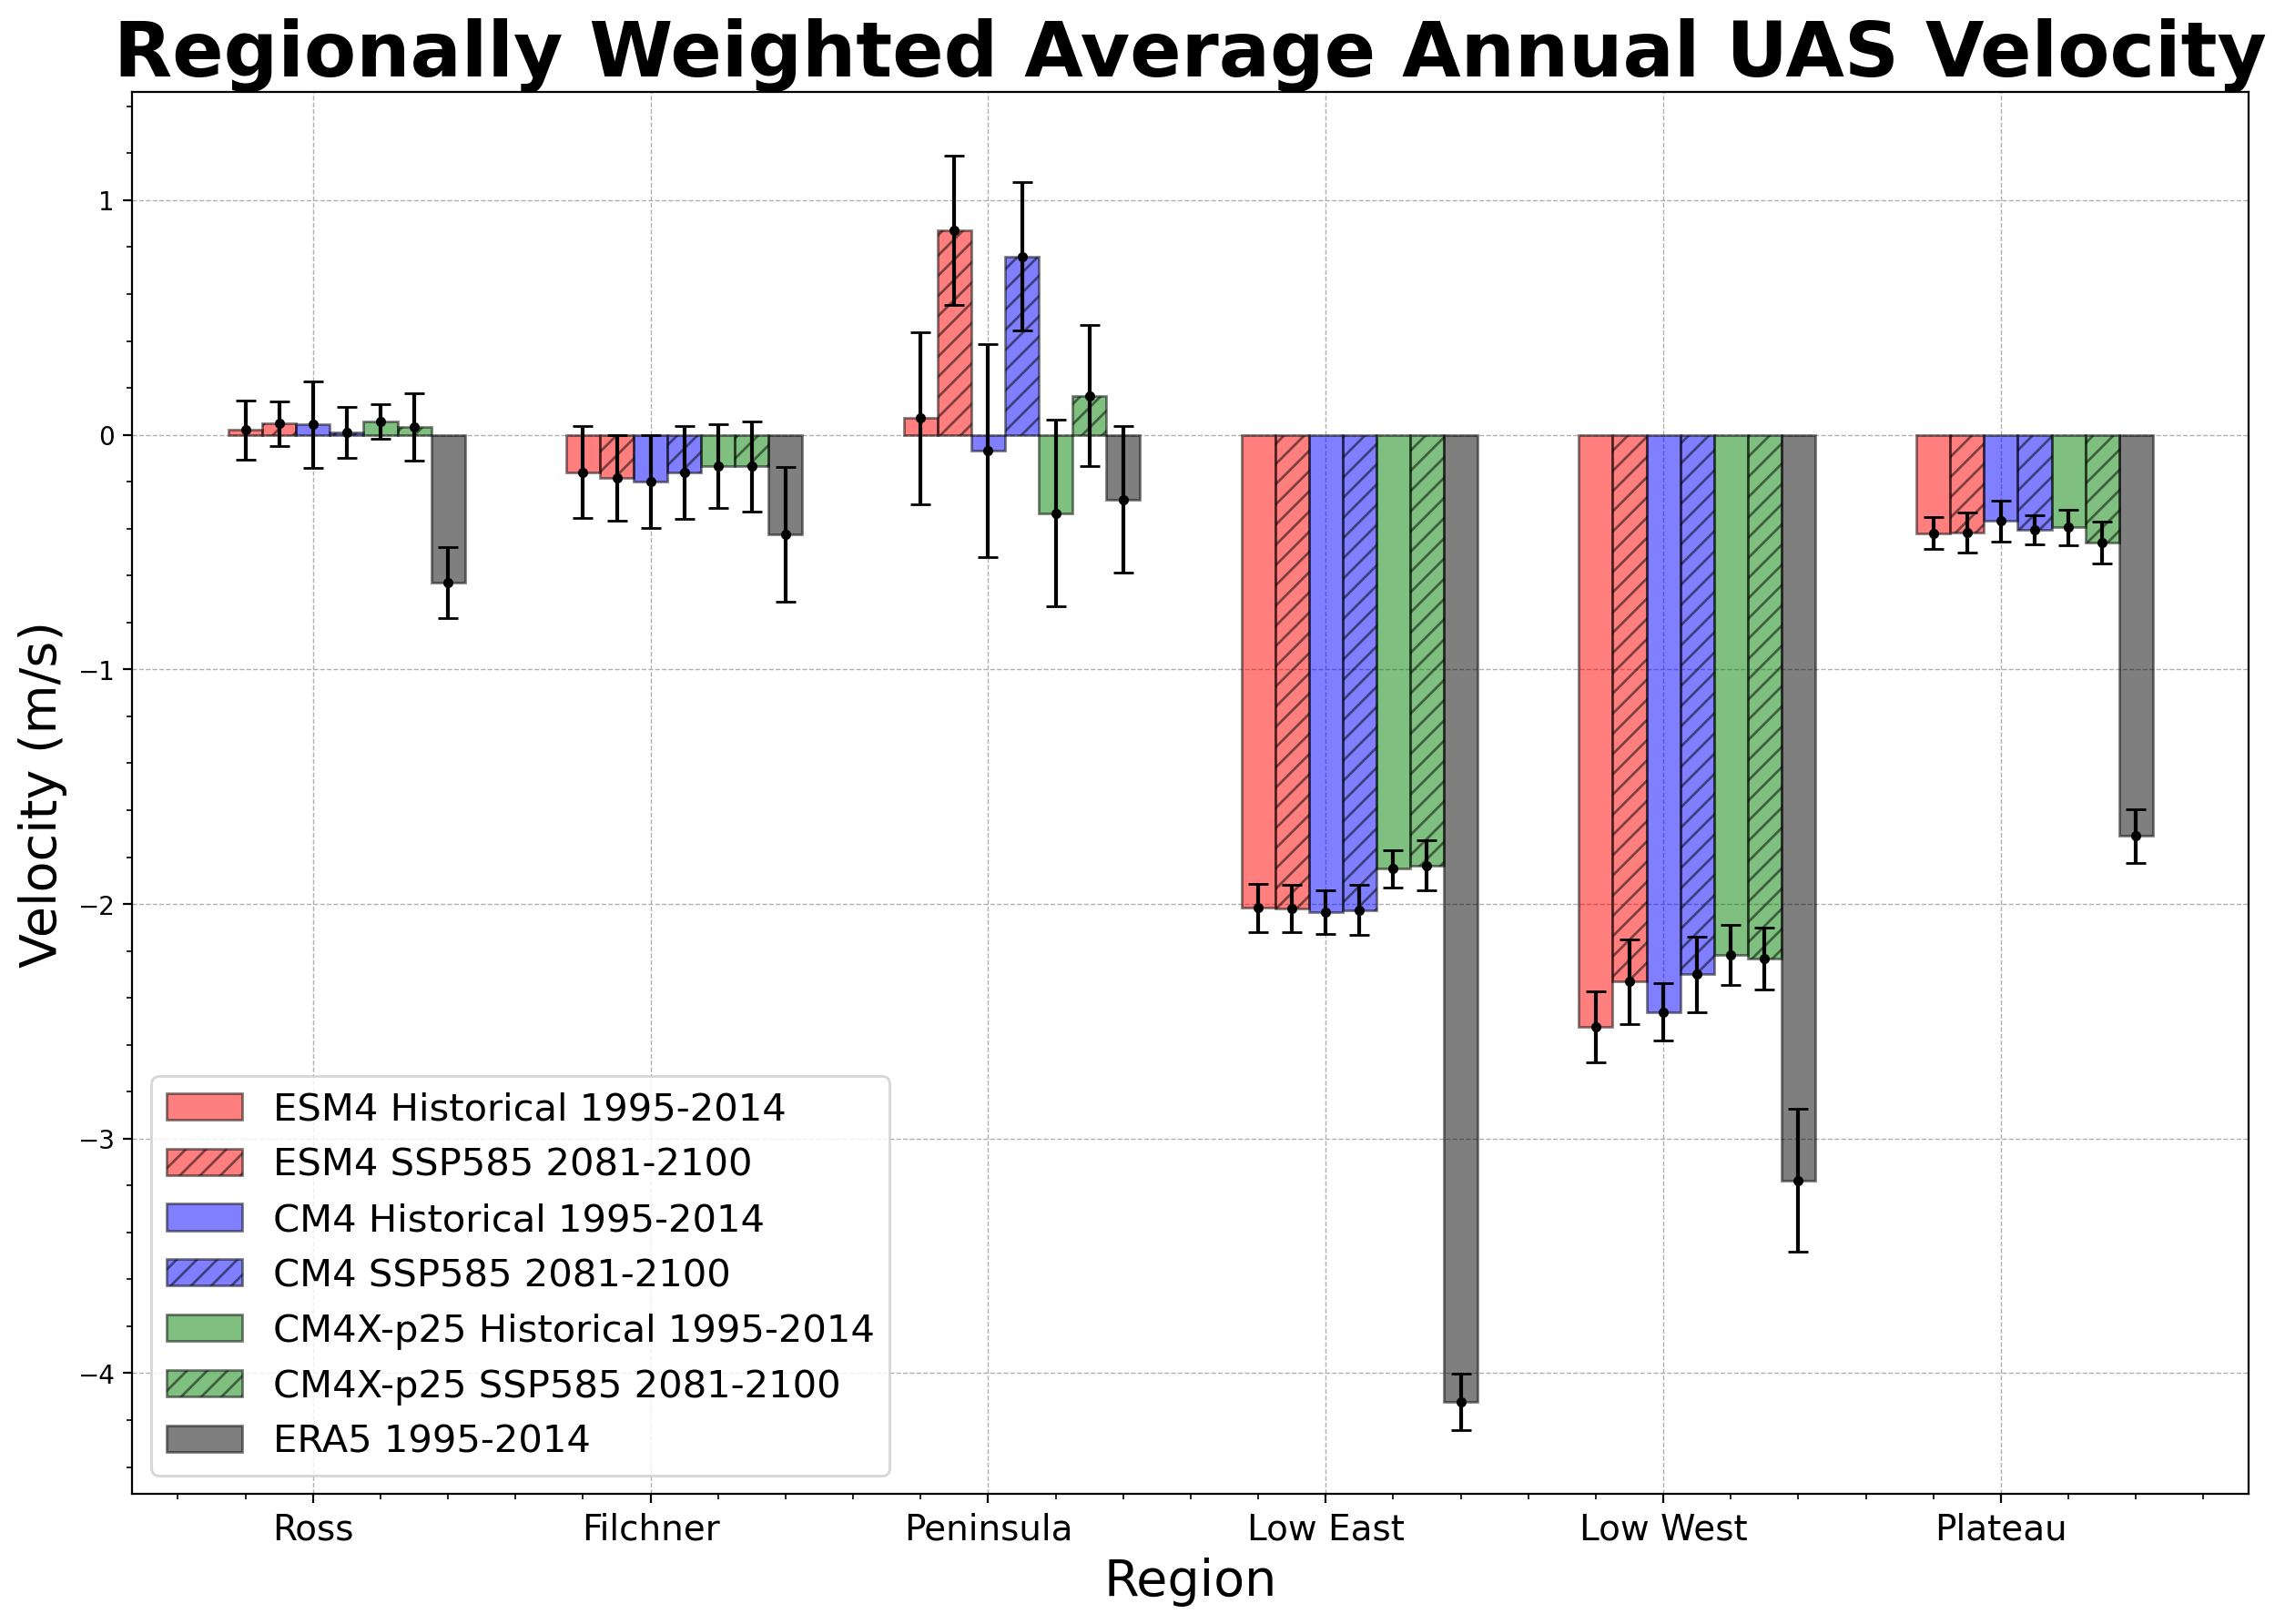

In [48]:
fig, ax= plt.subplots(figsize= (15,10))

## values for x axis
X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 

## wind speed values
CM4_his_uas_total = [0.04360517062937842,
-0.19995733104092825,
-0.06757307198792653,
-2.0356431921678855,
-2.4597786446682552,
-0.36811262570297726] 

CM4_SSP585_uas_total=[0.010665591377396127,
-0.15980065913404687,
0.7607286111051121,
-2.025088365578086,
-2.3000352549104357,
-0.4045542484009924]

ESM4_his_uas_total =  [0.02030168588970139,
-0.1590174121988441,
0.07053903550407188,
-2.015682987251647,
-2.5230679360569375,
-0.4187060642467665]

ESM4_SSP585_uas_total=[0.04836780787576373,
-0.18314633897279228,
0.8715677109818664,
-2.0192301606174454,
-2.3304542555879286,
-0.4174176049619569]

CM4X_his_uas_total = [0.057741280341768446,
-0.13330135056880682,
-0.3337548924917834,
-1.849514031269507,
-2.21761778236321,
-0.39457448781122356]

CM4X_SSP585_uas_total=[0.032972499017935225,
-0.1351066361942788,
0.1671098593251469,
-1.8351431222513468,
-2.2330831076568085,
-0.4594125110534435]

ERA5_uas_total = [-0.6293689055154433,
-0.42569963964958274,
-0.27618206140489016,
-4.123880244564029,
-3.178653565356282,
-1.7096283590828165]

## std values
std_cm4_uas_his=[0.18384833604259837,
0.1969941003149279,
0.45436929493503236,
0.09359600350789297,
0.1216032144741656,
0.08552627102700629]

std_cm4_ssp585_uas=[0.10837087569291799,
0.19681374573737628,
0.3156766867706796,
0.10736442605625036,
0.1599164263250272,
0.06134511887817079]

std_esm4_uas_his=[0.12651350400521758,
0.19515984780850526,
0.3659113299216653,
0.10303200942076421,
0.15119548951369396,
0.06641631300666716]

std_esm4_ssp585_uas=[0.0950856159897727,
0.18136146365555536,
0.316518472117604,
0.09912106811714846,
0.180050868818895,
0.08573447188036516]


std_cm4x_his_uas = [0.07326006850973774,
0.17752276702831685,
0.39870855781502906,
0.07848182034666615,
0.1288216419325077,
0.07564370566720127]

std_cm4x_ssp585_uas= [0.1434824646811566,
0.1930170503694949,
0.30005647118538536,
0.1060218991118628,
0.13254435816755342,
0.08884801095241879]

std_era5_uas= [0.15019583610543596,
0.2875995303285056,
0.3126092920627879,
0.12039721812880926,
0.30521128801278613,
0.11417038405768584]

## creating bar plot
X_axis = np.arange(len(X)) 

plt.bar(X_axis-0.2, ESM4_his_uas_total, 0.1, label = 'ESM4 Historical 1995-2014', color='r',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis-0.2, ESM4_his_uas_total,yerr= std_esm4_uas_his,fmt='o', color= 'black', markersize=3, capsize=4)

plt.bar(X_axis-0.1, ESM4_SSP585_uas_total, 0.1, label= 'ESM4 SSP585 2081-2100', color ='r', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis-0.1, ESM4_SSP585_uas_total, yerr= std_esm4_ssp585_uas, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis, CM4_his_uas_total, 0.1, label = 'CM4 Historical 1995-2014', color= 'blue',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis, CM4_his_uas_total, yerr=std_cm4_uas_his, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.1,CM4_SSP585_uas_total, 0.1, label='CM4 SSP585 2081-2100', color='blue', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.1, CM4_SSP585_uas_total, yerr= std_cm4_ssp585_uas, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.2, CM4X_his_uas_total, 0.1, label= 'CM4X-p25 Historical 1995-2014', color='green', alpha=0.5,edgecolor='black')
plt.errorbar(X_axis+0.2, CM4X_his_uas_total, yerr=std_cm4x_his_uas, fmt= 'o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.3, CM4X_SSP585_uas_total, 0.1, label='CM4X-p25 SSP585 2081-2100', color='green', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.3, CM4X_SSP585_uas_total, yerr= std_cm4x_ssp585_uas, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis + 0.4, ERA5_uas_total, 0.1, label= 'ERA5 1995-2014', color= 'k', edgecolor='black', alpha=0.5)
plt.errorbar(X_axis+0.4, ERA5_uas_total, yerr=std_era5_uas, fmt='o', color='black', markersize=3, capsize=4)



ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Velocity (m/s)", fontsize=20 )
plt.title("Regionally Weighted Average Annual UAS Velocity", fontsize=30,fontweight='bold') 
plt.legend(fontsize=15) 
ax.minorticks_on()
#plt.savefig('TemperatureHistoricalWeighted.png')

# UAS Anomaly Bar Plot 

In [118]:
CM4_diff_wind_uas= np.array(CM4_SSP585_uas_total)-np.array(CM4_his_uas_total)
CM4_diff_wind_uas

NameError: name 'CM4_SSP585_uas_total' is not defined

In [116]:
ESM4_diff_wind_uas= np.array(ESM4_SSP585_uas_total)-np.array(ESM4_his_uas_total)
ESM4_diff_wind_uas

NameError: name 'ESM4_SSP585_uas_total' is not defined

In [117]:
CM4X_diff_wind_uas=np.array(CM4X_SSP585_uas_total)-np.array(CM4X_his_uas_total)
CM4X_diff_wind_uas

NameError: name 'CM4X_SSP585_uas_total' is not defined

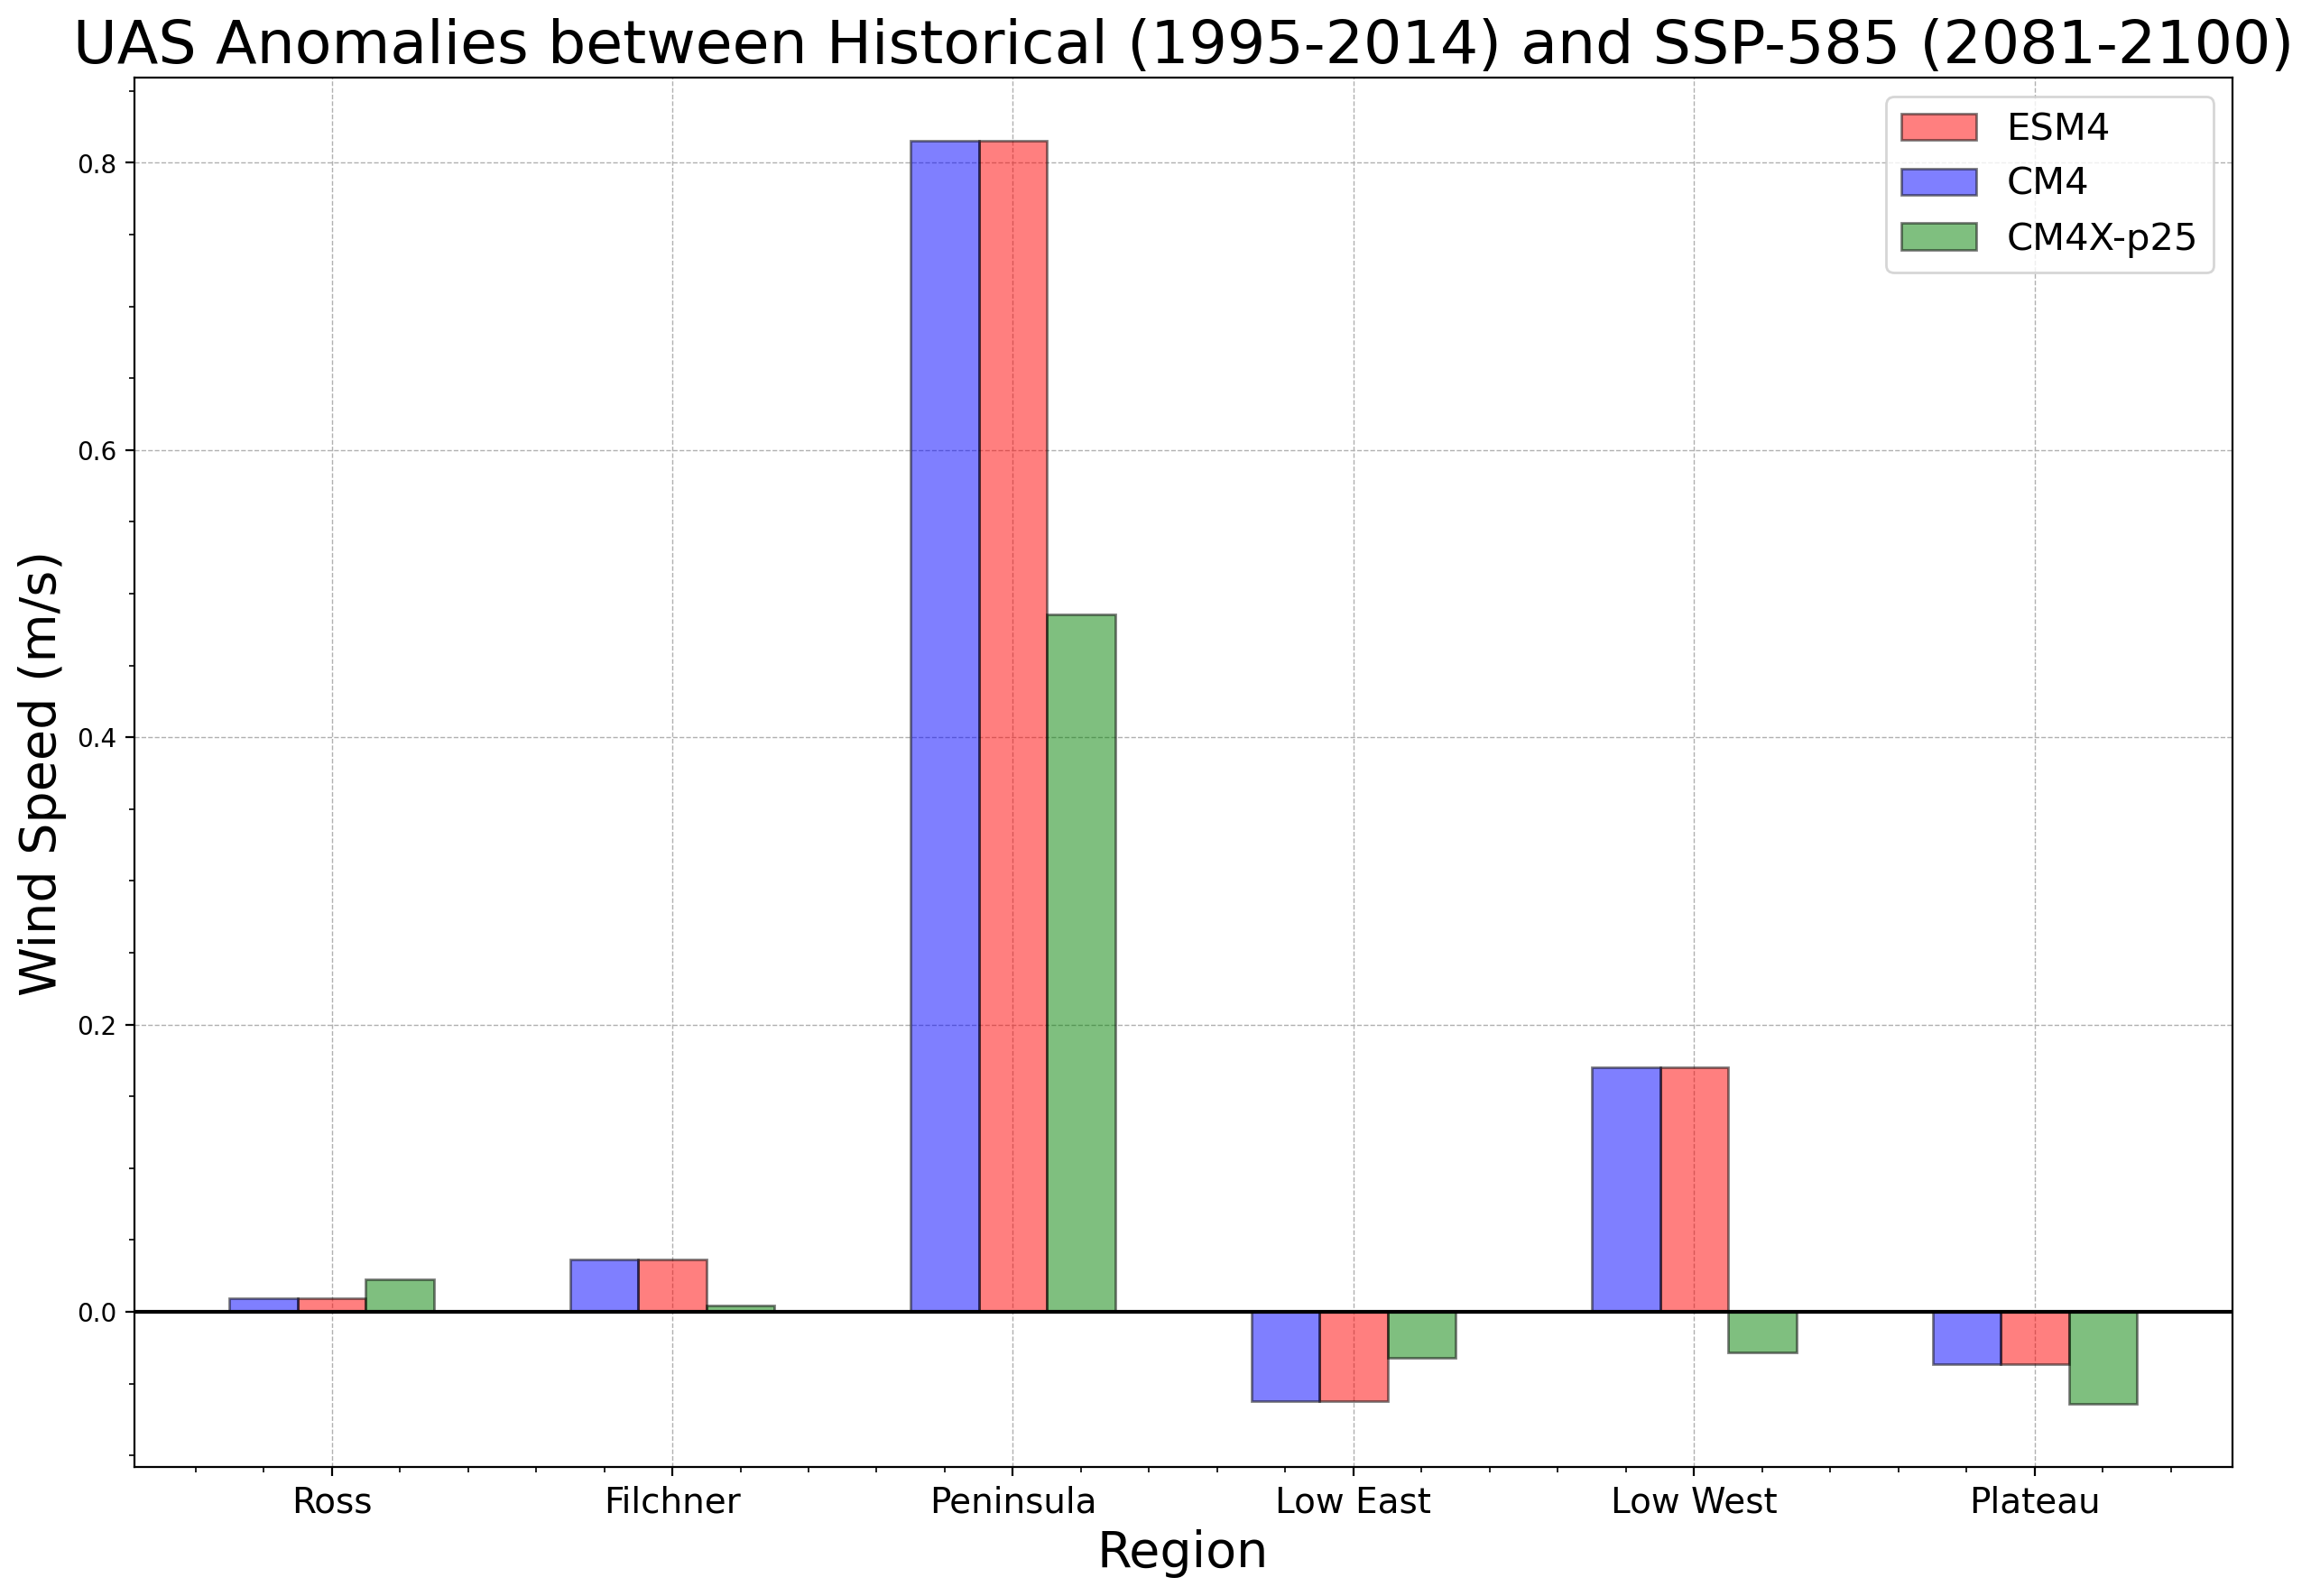

In [276]:
fig, ax= plt.subplots(figsize= (15,10))

X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 

ESM4_diff_uas=[ 0.00927433,  0.03653925,  0.81505959, -0.06220188,  0.17013265,
       -0.03644162]
CM4_diff_uas=[ 0.00927433,  0.03653925,  0.81505959, -0.06220188,  0.17013265,
       -0.03644162]
CM4X_diff_uas=[ 0.02283524,  0.00461657,  0.48565621, -0.03167874, -0.02802034,
       -0.0642964 ]


X_axis = np.arange(len(X)) 

plt.bar(X_axis, ESM4_diff_uas, 0.2, label = 'ESM4', color='r', alpha=0.5, edgecolor='black') 
plt.bar(X_axis - 0.2, CM4_diff_uas, 0.2, label = 'CM4', color= 'blue', alpha=0.5, edgecolor='black') 
plt.bar(X_axis + 0.2, CM4X_diff_uas, 0.2, label= 'CM4X-p25', color= 'green', alpha=0.5,edgecolor='black')


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Wind Speed (m/s)", fontsize=20 )
plt.title("UAS Anomalies between Historical (1995-2014) and SSP-585 (2081-2100)", fontsize=24) 
plt.legend(fontsize=15) 
ax.minorticks_on()
ax.axhline(0,color='k')

---

# Looking at the Changes in Eaterlies and Westerlies for the VAS component of wind

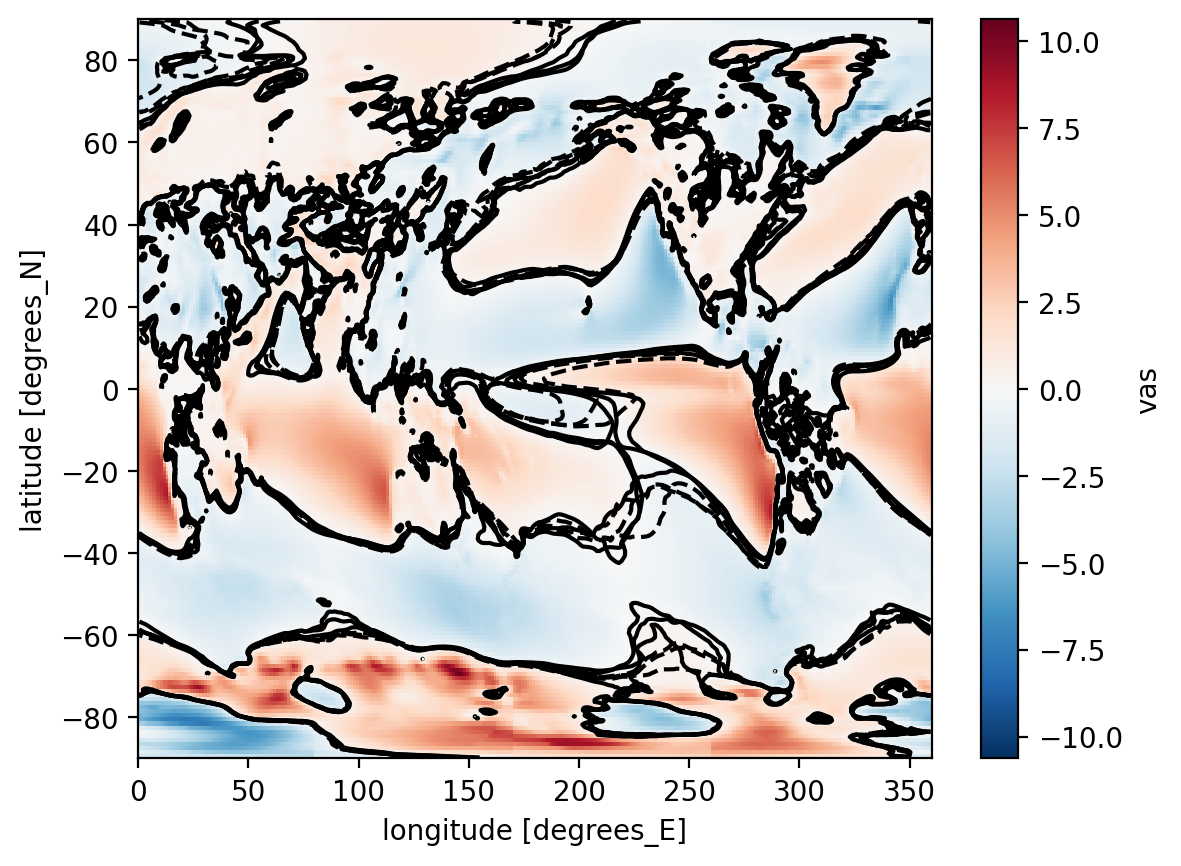

In [277]:
#this plot shows the differerence in the vas winds

#base plot
cm4_vas_his_time_slice.mean(dim='time').plot()

#CM4
cm4_vas_his_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k')
cm4_vas_ssp_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k',linestyles='--')

#ESM4
esm4_vas_his_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k')
esm4_vas_ssp_time_slice.mean(dim='time').plot.contour(levels=[0],colors='k',linestyles='--')          

#CM4X
cm4x_vas_his.mean(dim='time').plot.contour(levels=[0],colors='k')
cm4x_vas_ssp585.mean(dim='time').plot.contour(levels=[0],colors='k',linestyles='--')

### dotted line is SSP and solid is historical 

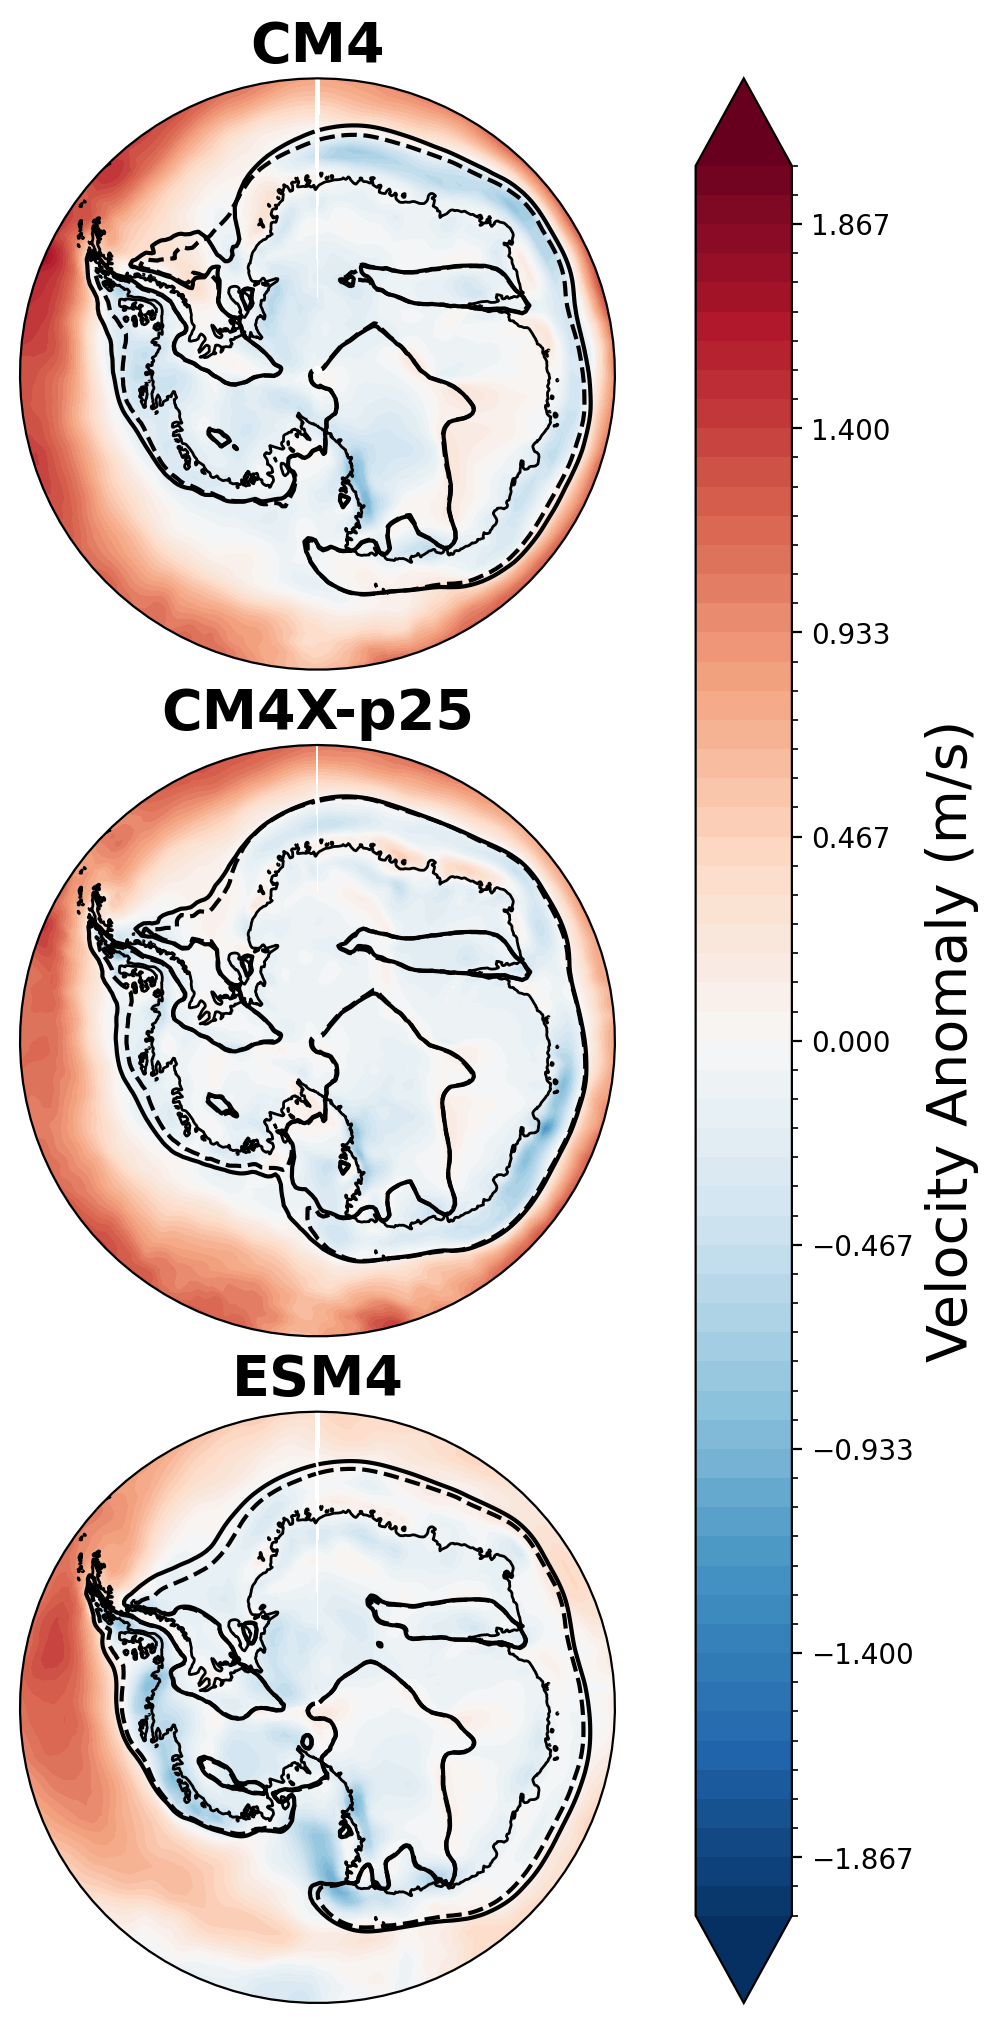

In [138]:
fig, ax = south_pole_map(rows=3, fig_size=(10, 10))

# Define the color map and levels
cmap = plt.get_cmap('RdBu_r')
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 61)  # 61 levels between vmin and vmax

p1 = CM4_diff_spatial.plot.contourf(ax=ax[0],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)


p2 = CM4X_diff_spatial.plot.contourf(ax=ax[1],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

p3 = ESM4_diff_spatial.plot.contourf(ax=ax[2],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

# Plot additional contours on the first subplot
cm4_uas_his_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4_uas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#esm4
esm4_uas_his_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

esm4_uas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#cm4x
cm4x_uas_his.mean(dim='time').plot.contour(ax=ax[2], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4x_uas_ssp585.mean(dim='time').plot.contour(ax=ax[2], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
# Add coastlines
ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

# Set titles
ax[0].set_title('CM4', fontsize=20,fontweight='bold')
ax[1].set_title('CM4X-p25', fontsize=20,fontweight='bold')
ax[2].set_title('ESM4', fontsize=20,fontweight='bold')
#fig.suptitle('UAS Difference Between SSP-585 2081-2100 \nand Historical 1995-2014 Over Computed Wind Speed Anomalies ', fontsize=24, x=0.5)
# Create a single color bar for all three subplots
cbar = fig.colorbar(p1, ax=ax, orientation='vertical', fraction=0.5, pad=0.05)
cbar.set_label('Velocity Anomaly (m/s)', fontsize=20)  # Change this to your desired label

plt.show()

# VAS Spatial Differences

In [123]:
CM4_v_diff_spatial= ((cm4_vas_ssp_time_slice.weighted(cm4_ssp_weights).mean('time'))-(cm4_vas_his_time_slice.weighted(weights_cm4_his).mean('time')))
CM4_v_diff_spatial

<xarray.DataArray 'vas' (lat: 180, lon: 288)>
dask.array<sub, shape=(180, 288), dtype=float64, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [124]:
ESM4_v_diff_spatial= ((esm4_vas_ssp_time_slice.weighted(weights_esm4_ssp).mean('time'))-(esm4_vas_his_time_slice.weighted(weights_esm4_his).mean('time')))
ESM4_v_diff_spatial

<xarray.DataArray 'vas' (lat: 180, lon: 288)>
dask.array<sub, shape=(180, 288), dtype=float64, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [131]:
CM4X_v_diff_spatial= ((cm4x_vas_ssp585.weighted(ssp_weights_cm4x).mean('time'))-(cm4x_vas_his.weighted(weights_cm4x_his).mean('time')))
CM4X_v_diff_spatial

<xarray.DataArray 'v_ref' (lat: 360, lon: 576)>
dask.array<sub, shape=(360, 576), dtype=float64, chunksize=(360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7

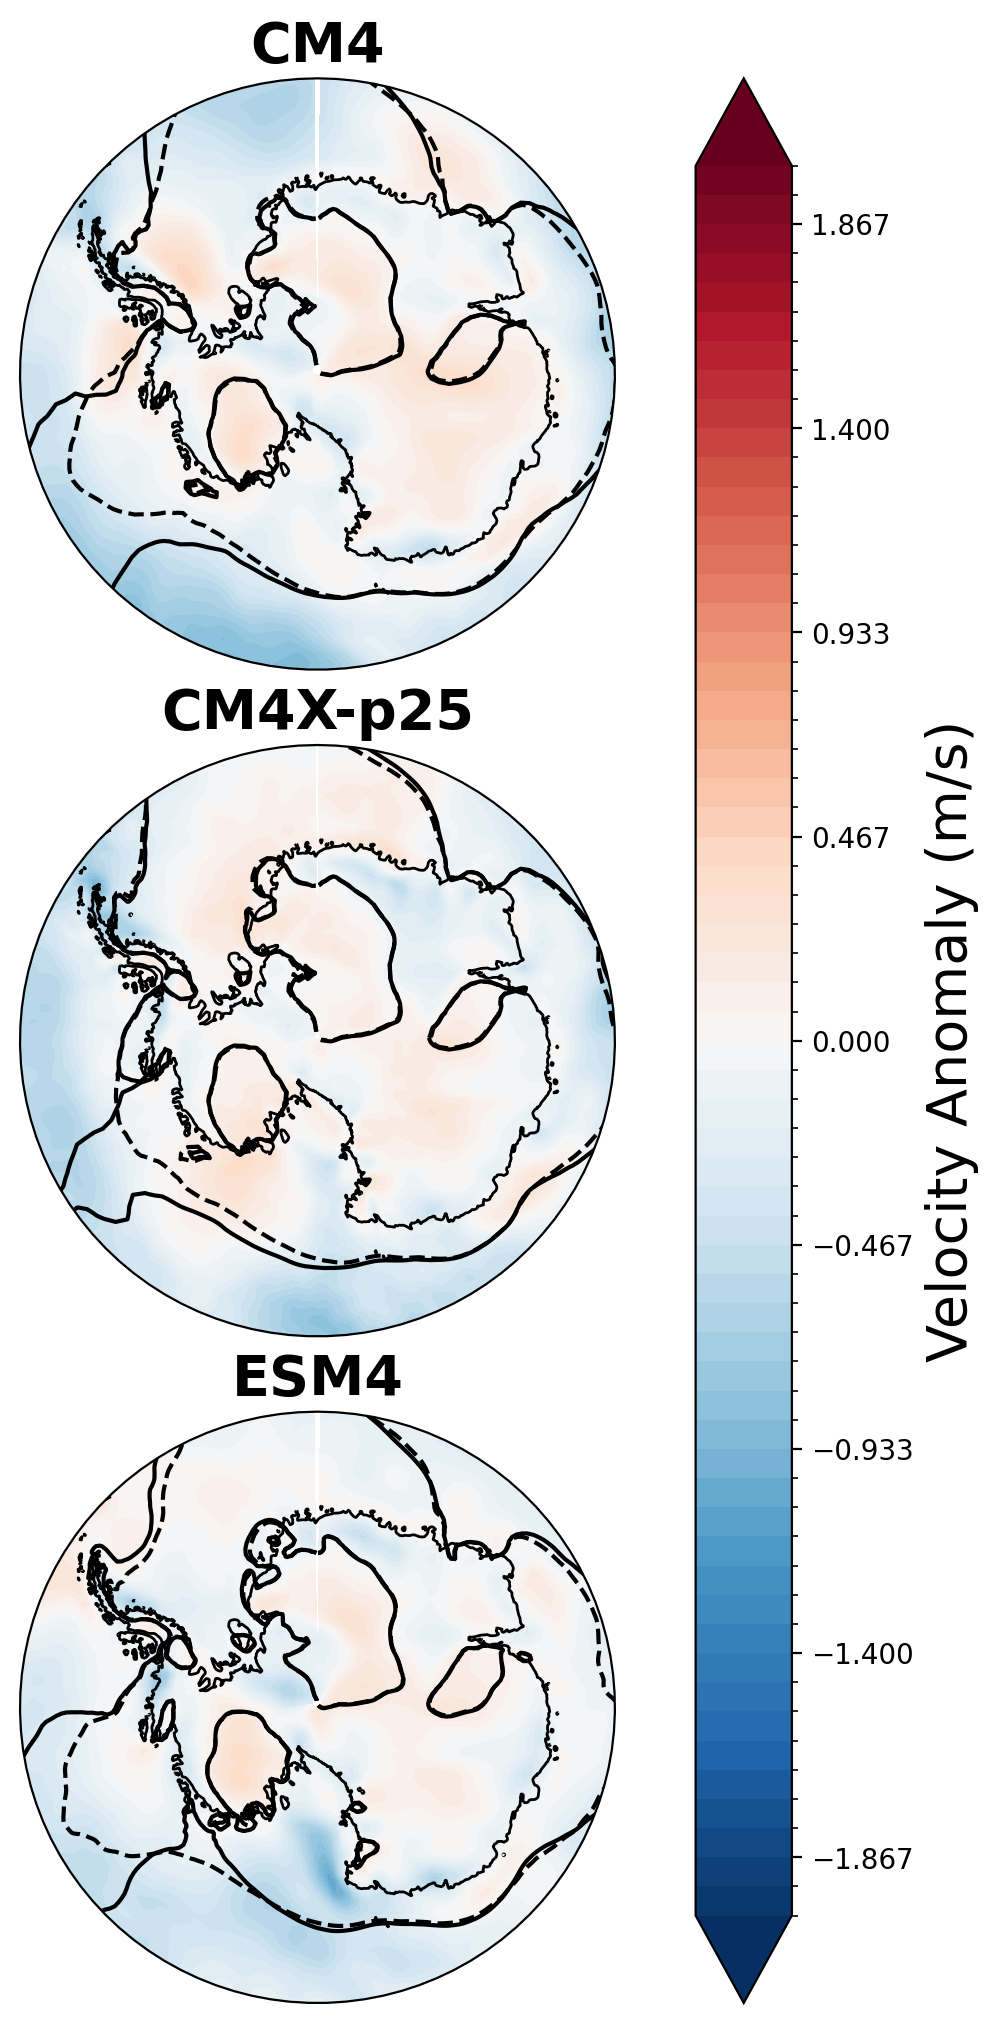

In [139]:
fig, ax = south_pole_map(rows=3, fig_size=(10, 10))

# Define the color map and levels
cmap = plt.get_cmap('RdBu_r')
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 61)  # 61 levels between vmin and vmax

p1 = CM4_v_diff_spatial.plot.contourf(ax=ax[0],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)


p2 = CM4X_v_diff_spatial.plot.contourf(ax=ax[1],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

p3 = ESM4_v_diff_spatial.plot.contourf(ax=ax[2],
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

# Plot additional contours on the first subplot
cm4_vas_his_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4_vas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[0], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#esm4
esm4_vas_his_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

esm4_vas_ssp_time_slice.mean(dim='time').plot.contour(ax=ax[1], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
#cm4x
cm4x_vas_his.mean(dim='time').plot.contour(ax=ax[2], 
                                              transform=ccrs.PlateCarree(),
                                              extend='both',
                                              levels=[0], 
                                              colors='k')

cm4x_vas_ssp585.mean(dim='time').plot.contour(ax=ax[2], 
                                          transform=ccrs.PlateCarree(),
                                          extend='both',
                                          levels=[0], 
                                          colors='k', 
                                          linestyles='--')
# Add coastlines
ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

# Set titles
ax[0].set_title('CM4', fontsize=20,fontweight='bold')
ax[1].set_title('CM4X-p25', fontsize=20,fontweight='bold')
ax[2].set_title('ESM4', fontsize=20,fontweight='bold')
#fig.suptitle('Difference Between 2081-2100 SSP585 and 1995-2014 Historical V component Shift', fontsize=24, x=0.5)
# Create a single color bar for all three subplots
cbar = fig.colorbar(p1, ax=ax, orientation='vertical', fraction=0.5, pad=0.05)
cbar.set_label('Velocity Anomaly (m/s)', fontsize=20)  # Change this to your desired label

plt.show()

---

# VAS Weighted Wind Speeds

# CM4 Historical VAS

In [283]:
lat_CM4_historical_vas = cm4_vas_his_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_historical_vas = cm4_vas_his_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4_historical_vas,lon_CM4_historical_vas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_historical_vas = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_vas_his_time_slice.coords['lat'],\
                                                        cm4_vas_his_time_slice.coords['lon']))

In [284]:
weights_cm4_his_vas=areacell_CM4_historical_vas

In [285]:
weight_ross_CM4_historical_vas=(mask_CM4.total_mask.where(mask_CM4.total==1)*cm4_vas_his_time_slice).weighted(weights_cm4_his_vas).mean(dim=['lat','lon'])
weight_filchner_CM4_historical_vas=(mask_CM4.total_mask.where(mask_CM4.total==3)*cm4_vas_his_time_slice).weighted(weights_cm4_his_vas).mean(dim=['lat','lon'])
weight_peninsula_CM4_historical_vas= (mask_CM4.total_mask.where(mask_CM4.total==4)*cm4_vas_his_time_slice).weighted(weights_cm4_his_vas).mean(dim=['lat','lon'])
weight_loweast_CM4_historical_vas=(mask_CM4.total_mask.where(mask_CM4.total==5)*cm4_vas_his_time_slice).weighted(weights_cm4_his_vas).mean(dim=['lat','lon'])
weight_lowwest_CM4_historical_vas=(mask_CM4.total_mask.where(mask_CM4.total==6)*cm4_vas_his_time_slice).weighted(weights_cm4_his_vas).mean(dim=['lat','lon'])
weight_plateau_CM4_historical_vas= (mask_CM4.total_mask.where(mask_CM4.total==2)*cm4_vas_his_time_slice).weighted(weights_cm4_his_vas).mean(dim=['lat','lon'])

In [286]:
weight_ross_cm4_annual_historical_vas = ml.util.annual_average(weight_ross_CM4_historical_vas,tcoord='time')
weight_filchner_cm4_annual_historical_vas= ml.util.annual_average(weight_filchner_CM4_historical_vas, tcoord='time')
weight_peninsula_cm4_annual_historical_vas=ml.util.annual_average(weight_peninsula_CM4_historical_vas, tcoord='time')
weight_loweast_cm4_annual_historical_vas=ml.util.annual_average(weight_loweast_CM4_historical_vas, tcoord='time')
weight_lowwest_cm4_annual_historical_vas=ml.util.annual_average(weight_lowwest_CM4_historical_vas, tcoord='time')
weight_plateau_cm4_annual_historical_vas=ml.util.annual_average(weight_plateau_CM4_historical_vas, tcoord='time')

In [287]:
cm4_his_ross_vas_wind=weight_ross_cm4_annual_historical_vas.mean(dim='time')
cm4_his_filch_vas_wind=weight_filchner_cm4_annual_historical_vas.mean(dim='time')
cm4_his_pen_vas_wind=weight_peninsula_cm4_annual_historical_vas.mean(dim='time')
cm4_his_east_vas_wind=weight_loweast_cm4_annual_historical_vas.mean(dim='time')
cm4_his_west_vas_wind=weight_lowwest_cm4_annual_historical_vas.mean(dim='time')
cm4_his_plat_vas_wind=weight_plateau_cm4_annual_historical_vas.mean(dim='time')

In [289]:
print(cm4_his_ross_vas_wind.values)
print(cm4_his_filch_vas_wind.values/3)
print(cm4_his_pen_vas_wind.values/4)
print(cm4_his_east_vas_wind.values/5)
print(cm4_his_west_vas_wind.values/6)
print(cm4_his_plat_vas_wind.values/2)

1.732904736920712
1.527132737354681
-0.24191923958470224
3.8257307547231973
0.7180255281931717
1.1983889019120313


In [290]:
ross_total_std_CM4_vas= weight_ross_cm4_annual_historical_vas.std('time')
filchner_total_std_CM4_vas= weight_filchner_cm4_annual_historical_vas.std('time')
peninsula_total_std_CM4_vas=weight_peninsula_cm4_annual_historical_vas.std('time')
loweast_total_std_CM4_vas=weight_loweast_cm4_annual_historical_vas.std('time')
lowwest_total_std_CM4_vas=weight_lowwest_cm4_annual_historical_vas.std('time')
plateau_total_std_CM4_vas=weight_plateau_cm4_annual_historical_vas.std('time')

In [291]:
print(ross_total_std_CM4_vas.values)
print(filchner_total_std_CM4_vas.values/3)
print(peninsula_total_std_CM4_vas.values/4)
print(loweast_total_std_CM4_vas.values/5)
print(lowwest_total_std_CM4_vas.values/6)
print(plateau_total_std_CM4_vas.values/2)

0.12749810356287763
0.06770043747880304
0.22194979209598656
0.07327419288764712
0.08554023498519238
0.06399172771543404


# CM4 SSP585 VAS

In [292]:
lat_CM4_ssp_vas = cm4_vas_ssp_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_ssp_vas = cm4_vas_ssp_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
cm4_ssp_vas_areacell = standard_grid_cell_area(lat_CM4_ssp_vas,lon_CM4_ssp_vas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_ssp_vas = xr.DataArray(cm4_ssp_vas_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_vas_ssp_time_slice.coords['lat'],\
                                                        cm4_vas_ssp_time_slice.coords['lon']))

In [293]:
weights_cm4_ssp_vas=areacell_CM4_ssp_vas

In [296]:
weight_ross_CM4_ssp_vas=(mask_CM4.total_mask.where(mask_CM4.total==1)*cm4_vas_ssp_time_slice).weighted(weights_cm4_ssp_vas).mean(dim=['lat','lon'])
weight_filchner_CM4_ssp_vas=(mask_CM4.total_mask.where(mask_CM4.total==3)*cm4_vas_ssp_time_slice).weighted(weights_cm4_ssp_vas).mean(dim=['lat','lon'])
weight_peninsula_CM4_ssp_vas= (mask_CM4.total_mask.where(mask_CM4.total==4)*cm4_vas_ssp_time_slice).weighted(weights_cm4_ssp_vas).mean(dim=['lat','lon'])
weight_loweast_CM4_ssp_vas=(mask_CM4.total_mask.where(mask_CM4.total==5)*cm4_vas_ssp_time_slice).weighted(weights_cm4_ssp_vas).mean(dim=['lat','lon'])
weight_lowwest_CM4_ssp_vas=(mask_CM4.total_mask.where(mask_CM4.total==6)*cm4_vas_ssp_time_slice).weighted(weights_cm4_ssp_vas).mean(dim=['lat','lon'])
weight_plateau_CM4_ssp_vas= (mask_CM4.total_mask.where(mask_CM4.total==2)*cm4_vas_ssp_time_slice).weighted(weights_cm4_ssp_vas).mean(dim=['lat','lon'])

In [297]:
weight_ross_cm4_annual_ssp_vas = ml.util.annual_average(weight_ross_CM4_ssp_vas,tcoord='time')
weight_filchner_cm4_annual_ssp_vas= ml.util.annual_average(weight_filchner_CM4_ssp_vas, tcoord='time')
weight_peninsula_cm4_annual_ssp_vas=ml.util.annual_average(weight_peninsula_CM4_ssp_vas, tcoord='time')
weight_loweast_cm4_annual_ssp_vas=ml.util.annual_average(weight_loweast_CM4_ssp_vas, tcoord='time')
weight_lowwest_cm4_annual_ssp_vas=ml.util.annual_average(weight_lowwest_CM4_ssp_vas, tcoord='time')
weight_plateau_cm4_annual_ssp_vas=ml.util.annual_average(weight_plateau_CM4_ssp_vas, tcoord='time')

In [298]:
cm4_ssp_vas_ross_wind=weight_ross_cm4_annual_ssp_vas.mean(dim='time')
cm4_ssp_vas_filch_wind=weight_filchner_cm4_annual_ssp_vas.mean(dim='time')
cm4_ssp_vas_pen_wind=weight_peninsula_cm4_annual_ssp_vas.mean(dim='time')
cm4_ssp_vas_east_wind=weight_loweast_cm4_annual_ssp_vas.mean(dim='time')
cm4_ssp_vas_west_wind=weight_lowwest_cm4_annual_ssp_vas.mean(dim='time')
cm4_ssp_vas_plat_wind=weight_plateau_cm4_annual_ssp_vas.mean(dim='time')

In [299]:
print(cm4_ssp_vas_ross_wind.values)
print(cm4_ssp_vas_filch_wind.values/3)
print(cm4_ssp_vas_pen_wind.values/4)
print(cm4_ssp_vas_east_wind.values/5)
print(cm4_ssp_vas_west_wind.values/6)
print(cm4_ssp_vas_plat_wind.values/2)

1.697045341794087
1.5096251328615047
-0.43729899730477095
3.7778696353004784
0.7221848524055944
1.289934442378115


In [300]:
ross_total_std_CM4_ssp_vas= weight_ross_cm4_annual_ssp_vas.std('time')
filchner_total_std_CM4_ssp_vas= weight_filchner_cm4_annual_ssp_vas.std('time')
peninsula_total_std_CM4_ssp_vas=weight_peninsula_cm4_annual_ssp_vas.std('time')
loweast_total_std_CM4_ssp_vas=weight_loweast_cm4_annual_ssp_vas.std('time')
lowwest_total_std_CM4_ssp_vas=weight_lowwest_cm4_annual_ssp_vas.std('time')
plateau_total_std_CM4_ssp_vas=weight_plateau_cm4_annual_ssp_vas.std('time')

In [301]:
print(ross_total_std_CM4_ssp_vas.values)
print(filchner_total_std_CM4_ssp_vas.values/3)
print(peninsula_total_std_CM4_ssp_vas.values/4)
print(loweast_total_std_CM4_ssp_vas.values/5)
print(lowwest_total_std_CM4_ssp_vas.values/6)
print(plateau_total_std_CM4_ssp_vas.values/2)

0.13689778820776655
0.07655385054259821
0.2303776815993452
0.07535163307488925
0.1073973847132914
0.09099273470828381


# ESM4 Historical VAS

In [303]:
lat_esm4_historical_vas = esm4_vas_his_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_historical_vas = esm4_vas_his_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_his_areacell_vas = standard_grid_cell_area(lat_esm4_historical_vas,lon_esm4_historical_vas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_historical_vas = xr.DataArray(esm4_his_areacell_vas,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_vas_his_time_slice.coords['lat'],\
                                                        esm4_vas_his_time_slice.coords['lon']))

In [304]:
weights_esm4_his_vas=areacell_esm4_historical_vas

In [305]:
weight_ross_ESM4_historical_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==1)*esm4_vas_his_time_slice).weighted(weights_esm4_his_vas).mean(dim=['lat','lon'])
weight_filchner_ESM4_historical_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==3)*esm4_vas_his_time_slice).weighted(weights_esm4_his_vas).mean(dim=['lat','lon'])
weight_peninsula_ESM4_historical_vas= (mask_ESM4.total_mask.where(mask_ESM4.total==4)*esm4_vas_his_time_slice).weighted(weights_esm4_his_vas).mean(dim=['lat','lon'])
weight_loweast_ESM4_historical_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==5)*esm4_vas_his_time_slice).weighted(weights_esm4_his_vas).mean(dim=['lat','lon'])
weight_lowwest_ESM4_historical_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==6)*esm4_vas_his_time_slice).weighted(weights_esm4_his_vas).mean(dim=['lat','lon'])
weight_plateau_ESM4_historical_vas= (mask_ESM4.total_mask.where(mask_ESM4.total==2)*esm4_vas_his_time_slice).weighted(weights_esm4_his_vas).mean(dim=['lat','lon'])

In [306]:
weight_ross_ESM4_annual_historical_vas = ml.util.annual_average(weight_ross_ESM4_historical_vas,tcoord='time')
weight_filchner_ESM4_annual_historical_vas= ml.util.annual_average(weight_filchner_ESM4_historical_vas, tcoord='time')
weight_peninsula_ESM4_annual_historical_vas=ml.util.annual_average(weight_peninsula_ESM4_historical_vas, tcoord='time')
weight_loweast_ESM4_annual_historical_vas=ml.util.annual_average(weight_loweast_ESM4_historical_vas, tcoord='time')
weight_lowwest_ESM4_annual_historical_vas=ml.util.annual_average(weight_lowwest_ESM4_historical_vas, tcoord='time')
weight_plateau_ESM4_annual_historical_vas=ml.util.annual_average(weight_plateau_ESM4_historical_vas, tcoord='time')

In [307]:
ESM4_historical_vas_ross_wind=weight_ross_ESM4_annual_historical_vas.mean(dim='time')
ESM4_historical_vas_filch_wind=weight_filchner_ESM4_annual_historical_vas.mean(dim='time')
ESM4_historical_vas_pen_wind=weight_peninsula_ESM4_annual_historical_vas.mean(dim='time')
ESM4_historical_vas_east_wind=weight_loweast_ESM4_annual_historical_vas.mean(dim='time')
ESM4_historical_vas_west_wind=weight_lowwest_ESM4_annual_historical_vas.mean(dim='time')
ESM4_historical_vas_plat_wind=weight_plateau_ESM4_annual_historical_vas.mean(dim='time')

In [308]:
print(ESM4_historical_vas_ross_wind.values)
print(ESM4_historical_vas_filch_wind.values/3)
print(ESM4_historical_vas_pen_wind.values/4)
print(ESM4_historical_vas_east_wind.values/5)
print(ESM4_historical_vas_west_wind.values/6)
print(ESM4_historical_vas_plat_wind.values/2)

1.7580525270510268
1.5184049202662404
-0.0688528020505057
3.90361406736661
0.7043403408974499
1.3033136393836497


In [309]:
ross_total_std_ESM4_vas= weight_ross_ESM4_annual_historical_vas.std('time')
filchner_total_std_ESM4_vas= weight_filchner_ESM4_annual_historical_vas.std('time')
peninsula_total_std_ESM4_vas=weight_peninsula_ESM4_annual_historical_vas.std('time')
loweast_total_std_ESM4_vas=weight_loweast_ESM4_annual_historical_vas.std('time')
lowwest_total_std_ESM4_vas=weight_lowwest_ESM4_annual_historical_vas.std('time')
plateau_total_std_ESM4_vas=weight_plateau_ESM4_annual_historical_vas.std('time')

In [310]:
print(ross_total_std_ESM4_vas.values)
print(filchner_total_std_ESM4_vas.values/3)
print(peninsula_total_std_ESM4_vas.values/4)
print(loweast_total_std_ESM4_vas.values/5)
print(lowwest_total_std_ESM4_vas.values/6)
print(plateau_total_std_ESM4_vas.values/2)

0.15907514336471396
0.09187417345061479
0.2809528632093372
0.07757433536647945
0.11151305192947784
0.0909033818772775


# ESM4 SSP585 VAS

In [329]:
lat_esm4_ssp_vas = esm4_vas_ssp_time_slice.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_ssp_vas = esm4_vas_ssp_time_slice.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_ssp_areacell_vas = standard_grid_cell_area(lat_esm4_ssp_vas,lon_esm4_ssp_vas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_ssp_vas = xr.DataArray(esm4_ssp_areacell_vas,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_vas_ssp_time_slice.coords['lat'],\
                                                        esm4_vas_ssp_time_slice.coords['lon']))

In [330]:
weights_esm4_ssp_vas=areacell_esm4_ssp_vas

In [331]:
weight_ross_ESM4_ssp_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==1)*esm4_vas_ssp_time_slice).weighted(weights_esm4_ssp_vas).mean(dim=['lat','lon'])
weight_filchner_ESM4_ssp_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==3)*esm4_vas_ssp_time_slice).weighted(weights_esm4_ssp_vas).mean(dim=['lat','lon'])
weight_peninsula_ESM4_ssp_vas= (mask_ESM4.total_mask.where(mask_ESM4.total==4)*esm4_vas_ssp_time_slice).weighted(weights_esm4_ssp_vas).mean(dim=['lat','lon'])
weight_loweast_ESM4_ssp_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==5)*esm4_vas_ssp_time_slice).weighted(weights_esm4_ssp_vas).mean(dim=['lat','lon'])
weight_lowwest_ESM4_ssp_vas=(mask_ESM4.total_mask.where(mask_ESM4.total==6)*esm4_vas_ssp_time_slice).weighted(weights_esm4_ssp_vas).mean(dim=['lat','lon'])
weight_plateau_ESM4_ssp_vas= (mask_ESM4.total_mask.where(mask_ESM4.total==2)*esm4_vas_ssp_time_slice).weighted(weights_esm4_ssp_vas).mean(dim=['lat','lon'])

In [332]:
weight_ross_ESM4_annual_ssp_vas = ml.util.annual_average(weight_ross_ESM4_ssp_vas,tcoord='time')
weight_filchner_ESM4_annual_ssp_vas= ml.util.annual_average(weight_filchner_ESM4_ssp_vas, tcoord='time')
weight_peninsula_ESM4_annual_ssp_vas=ml.util.annual_average(weight_peninsula_ESM4_ssp_vas, tcoord='time')
weight_loweast_ESM4_annual_ssp_vas=ml.util.annual_average(weight_loweast_ESM4_ssp_vas, tcoord='time')
weight_lowwest_ESM4_annual_ssp_vas=ml.util.annual_average(weight_lowwest_ESM4_ssp_vas, tcoord='time')
weight_plateau_ESM4_annual_ssp_vas=ml.util.annual_average(weight_plateau_ESM4_ssp_vas, tcoord='time')

In [333]:
ESM4_ssp_vas_ross_wind=weight_ross_ESM4_annual_ssp_vas.mean(dim='time')
ESM4_ssp_vas_filch_wind=weight_filchner_ESM4_annual_ssp_vas.mean(dim='time')
ESM4_ssp_vas_pen_wind=weight_peninsula_ESM4_annual_ssp_vas.mean(dim='time')
ESM4_ssp_vas_east_wind=weight_loweast_ESM4_annual_ssp_vas.mean(dim='time')
ESM4_ssp_vas_west_wind=weight_lowwest_ESM4_annual_ssp_vas.mean(dim='time')
ESM4_ssp_vas_plat_wind=weight_plateau_ESM4_annual_ssp_vas.mean(dim='time')

In [334]:
print(ESM4_ssp_vas_ross_wind.values)
print(ESM4_ssp_vas_filch_wind.values/3)
print(ESM4_ssp_vas_pen_wind.values/4)
print(ESM4_ssp_vas_east_wind.values/5)
print(ESM4_ssp_vas_west_wind.values/6)
print(ESM4_ssp_vas_plat_wind.values/2)

1.645081784591375
1.4496049086033083
-0.21836522257152816
3.795693237686887
0.6621347121354924
1.3344674254670652


In [319]:
ross_total_std_ESM4_ssp_vas= weight_ross_ESM4_annual_ssp_vas.std('time')
filchner_total_std_ESM4_ssp_vas= weight_filchner_ESM4_annual_ssp_vas.std('time')
peninsula_total_std_ESM4_ssp_vas=weight_peninsula_ESM4_annual_ssp_vas.std('time')
loweast_total_std_ESM4_ssp_vas=weight_loweast_ESM4_annual_ssp_vas.std('time')
lowwest_total_std_ESM4_ssp_vas=weight_lowwest_ESM4_annual_ssp_vas.std('time')
plateau_total_std_ESM4_ssp_vas=weight_plateau_ESM4_annual_ssp_vas.std('time')

In [320]:
print(ross_total_std_ESM4_ssp_vas.values)
print(filchner_total_std_ESM4_ssp_vas.values/3)
print(peninsula_total_std_ESM4_ssp_vas.values/4)
print(loweast_total_std_ESM4_ssp_vas.values/5)
print(lowwest_total_std_ESM4_ssp_vas.values/6)
print(plateau_total_std_ESM4_ssp_vas.values/2)

0.15438465343169228
0.1234884965964567
0.2830917862761166
0.07366417366307629
0.09172137576324946
0.09161955373018478


# CM4X Historical VAS

In [335]:
lat_CM4x_historical_vas = cm4x_vas_his.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_historical_vas = cm4x_vas_his.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_historical_vas,lon_CM4x_historical_vas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_historical_vas = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_vas_his.coords['lat'],\
                                                        cm4x_vas_his.coords['lon']))

In [336]:
weights_cm4x_vas_vas=areacell_CM4x_historical_vas

In [337]:
weight_ross_CM4x_historical_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==1)*cm4x_vas_his).weighted(weights_cm4x_vas).mean(dim=['lat','lon'])
weight_filchner_CM4x_historical_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==3)*cm4x_vas_his).weighted(weights_cm4x_vas).mean(dim=['lat','lon'])
weight_peninsula_CM4x_historical_vas= (mask_CM4X.total_mask.where(mask_CM4X.total==4)*cm4x_vas_his).weighted(weights_cm4x_vas).mean(dim=['lat','lon'])
weight_loweast_CM4x_historical_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==5)*cm4x_vas_his).weighted(weights_cm4x_vas).mean(dim=['lat','lon'])
weight_lowwest_CM4x_historical_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==6)*cm4x_vas_his).weighted(weights_cm4x_vas).mean(dim=['lat','lon'])
weight_plateau_CM4x_historical_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==2)*cm4x_vas_his).weighted(weights_cm4x_vas).mean(dim=['lat','lon'])

In [338]:
weight_ross_cm4x_annual_historical_vas = ml.util.annual_average(weight_ross_CM4x_historical_vas,tcoord='time')
weight_filchner_cm4x_annual_historical_vas= ml.util.annual_average(weight_filchner_CM4x_historical_vas, tcoord='time')
weight_peninsula_cm4x_annual_historical_vas=ml.util.annual_average(weight_peninsula_CM4x_historical_vas, tcoord='time')
weight_loweast_cm4x_annual_historical_vas=ml.util.annual_average(weight_loweast_CM4x_historical_vas, tcoord='time')
weight_lowwest_cm4x_annual_historical_vas=ml.util.annual_average(weight_lowwest_CM4x_historical_vas, tcoord='time')
weight_plateau_cm4x_annual_historical_vas=ml.util.annual_average(weight_plateau_CM4x_historical_vas, tcoord='time')

In [339]:
cm4x_his_ross_vas_wind=weight_ross_cm4x_annual_historical_vas.mean(dim='time')
cm4x_his_filch_vas_wind=weight_filchner_cm4x_annual_historical_vas.mean(dim='time')
cm4x_his_pen_vas_wind=weight_peninsula_cm4x_annual_historical_vas.mean(dim='time')
cm4x_his_east_vas_wind=weight_loweast_cm4x_annual_historical_vas.mean(dim='time')
cm4x_his_west_vas_wind=weight_lowwest_cm4x_annual_historical_vas.mean(dim='time')
cm4x_his_plat_vas_wind=weight_plateau_cm4x_annual_historical_vas.mean(dim='time')

In [326]:
print(cm4x_his_ross_vas_wind.values)
print(cm4x_his_filch_vas_wind.values/3)
print(cm4x_his_pen_vas_wind.values/4)
print(cm4x_his_east_vas_wind.values/5)
print(cm4x_his_west_vas_wind.values/6)
print(cm4x_his_plat_vas_wind.values/2)

1.5362834216269756
1.4635136301101008
0.08299623645457142
3.468942294631846
0.4323371686076185
1.1699005986398936


In [340]:
ross_total_std_CM4x_vas= weight_ross_cm4x_annual_historical_vas.std('time')
filchner_total_std_CM4x_vas= weight_filchner_cm4x_annual_historical_vas.std('time')
peninsula_total_std_CM4x_vas=weight_peninsula_cm4x_annual_historical_vas.std('time')
loweast_total_std_CM4x_vas=weight_loweast_cm4x_annual_historical_vas.std('time')
lowwest_total_std_CM4x_vas=weight_lowwest_cm4x_annual_historical_vas.std('time')
plateau_total_std_CM4x_vas=weight_plateau_cm4x_annual_historical_vas.std('time')

In [341]:
print(ross_total_std_CM4x_vas.values)
print(filchner_total_std_CM4x_vas.values/3)
print(peninsula_total_std_CM4x_vas.values/4)
print(loweast_total_std_CM4x_vas.values/5)
print(lowwest_total_std_CM4x_vas.values/6)
print(plateau_total_std_CM4x_vas.values/2)

0.1127907461517549
0.06865605940890315
0.22233661351106168
0.05890112225016793
0.09116903267942816
0.07203010177176401


# CM4X SSP585 VAS

In [342]:
lat_CM4x_ssp_vas = cm4x_vas_ssp585.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_ssp_vas = cm4x_vas_ssp585.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_ssp_vas,lon_CM4x_ssp_vas)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_ssp_vas = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_vas_ssp585.coords['lat'],\
                                                        cm4x_vas_ssp585.coords['lon']))

In [343]:
ssp_weights_cm4x_vas_vas=areacell_CM4x_ssp_vas

In [344]:
weight_ross_CM4x_ssp_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==1)*cm4x_vas_ssp585).weighted(ssp_weights_cm4x_vas).mean(dim=['lat','lon'])
weight_filchner_CM4x_ssp_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==3)*cm4x_vas_ssp585).weighted(ssp_weights_cm4x_vas).mean(dim=['lat','lon'])
weight_peninsula_CM4x_ssp_vas= (mask_CM4X.total_mask.where(mask_CM4X.total==4)*cm4x_vas_ssp585).weighted(ssp_weights_cm4x_vas).mean(dim=['lat','lon'])
weight_loweast_CM4x_ssp_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==5)*cm4x_vas_ssp585).weighted(ssp_weights_cm4x_vas).mean(dim=['lat','lon'])
weight_lowwest_CM4x_ssp_vas=(mask_CM4X.total_mask.where(mask_CM4X.total==6)*cm4x_vas_ssp585).weighted(ssp_weights_cm4x_vas).mean(dim=['lat','lon'])
weight_plateau_CM4x_ssp_vas= (mask_CM4X.total_mask.where(mask_CM4X.total==2)*cm4x_vas_ssp585).weighted(ssp_weights_cm4x_vas).mean(dim=['lat','lon'])

In [345]:
weight_ross_cm4x_annual_ssp_vas = ml.util.annual_average(weight_ross_CM4x_ssp_vas,tcoord='time')
weight_filchner_cm4x_annual_ssp_vas= ml.util.annual_average(weight_filchner_CM4x_ssp_vas, tcoord='time')
weight_peninsula_cm4x_annual_ssp_vas=ml.util.annual_average(weight_peninsula_CM4x_ssp_vas, tcoord='time')
weight_loweast_cm4x_annual_ssp_vas=ml.util.annual_average(weight_loweast_CM4x_ssp_vas, tcoord='time')
weight_lowwest_cm4x_annual_ssp_vas=ml.util.annual_average(weight_lowwest_CM4x_ssp_vas, tcoord='time')
weight_plateau_cm4x_annual_ssp_vas=ml.util.annual_average(weight_plateau_CM4x_ssp_vas, tcoord='time')

In [346]:
cm4x_ssp_ross_vas_wind=weight_ross_cm4x_annual_ssp_vas.mean(dim='time')
cm4x_ssp_filch_vas_wind=weight_filchner_cm4x_annual_ssp_vas.mean(dim='time')
cm4x_ssp_pen_vas_wind=weight_peninsula_cm4x_annual_ssp_vas.mean(dim='time')
cm4x_ssp_east_vas_wind=weight_loweast_cm4x_annual_ssp_vas.mean(dim='time')
cm4x_ssp_west_vas_wind=weight_lowwest_cm4x_annual_ssp_vas.mean(dim='time')
cm4x_ssp_plat_vas_wind=weight_plateau_cm4x_annual_ssp_vas.mean(dim='time')

In [347]:
print(cm4x_ssp_ross_vas_wind.values)
print(cm4x_ssp_filch_vas_wind.values/3)
print(cm4x_ssp_pen_vas_wind.values/4)
print(cm4x_ssp_east_vas_wind.values/5)
print(cm4x_ssp_west_vas_wind.values/6)
print(cm4x_ssp_plat_vas_wind.values/2)

1.5883589805243805
1.5005923586267749
-0.1978368396404305
3.39024700687024
0.45857923514050464
1.182303548659268


In [348]:
ross_total_std_CM4x_ssp_vas= weight_ross_cm4x_annual_ssp_vas.std('time')
filchner_total_std_CM4x_ssp_vas= weight_filchner_cm4x_annual_ssp_vas.std('time')
peninsula_total_std_CM4x_ssp_vas=weight_peninsula_cm4x_annual_ssp_vas.std('time')
loweast_total_std_CM4x_ssp_vas=weight_loweast_cm4x_annual_ssp_vas.std('time')
lowwest_total_std_CM4x_ssp_vas=weight_lowwest_cm4x_annual_ssp_vas.std('time')
plateau_total_std_CM4x_ssp_vas=weight_plateau_cm4x_annual_ssp_vas.std('time')

In [349]:
print(ross_total_std_CM4x_ssp_vas.values)
print(filchner_total_std_CM4x_ssp_vas.values/3)
print(peninsula_total_std_CM4x_ssp_vas.values/4)
print(loweast_total_std_CM4x_ssp_vas.values/5)
print(lowwest_total_std_CM4x_ssp_vas.values/6)
print(plateau_total_std_CM4x_ssp_vas.values/2)

0.13500304288653983
0.06760108257760104
0.21325939407419064
0.0925290959782881
0.08634720759018723
0.11760205425015412


# ERA5 VAS

In [40]:
weight_ross_ERA5_vas=(mask_ERA5.total_mask.where(mask_ERA5.total==1)*ERA5_vas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_filchner_ERA5_vas=(mask_ERA5.total_mask.where(mask_ERA5.total==3)*ERA5_vas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_peninsula_ERA5_vas= (mask_ERA5.total_mask.where(mask_ERA5.total==4)*ERA5_vas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_loweast_ERA5_vas= (mask_ERA5.total_mask.where(mask_ERA5.total==5)*ERA5_vas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_lowwest_ERA5_vas= (mask_ERA5.total_mask.where(mask_ERA5.total==6)*ERA5_vas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_plateau_ERA5_vas=(mask_ERA5.total_mask.where(mask_ERA5.total==2)*ERA5_vas_95_2014).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])

In [41]:
weight_ross_ERA5_vas_annual_wind = ml.util.annual_average(weight_ross_ERA5_vas, tcoord='time')
weight_filchner_ERA5_vas_annual_wind= ml.util.annual_average(weight_filchner_ERA5_vas, tcoord='time')
weight_peninsula_ERA5_vas_annual_wind=ml.util.annual_average(weight_peninsula_ERA5_vas, tcoord='time')
weight_loweast_ERA5_vas_annual_wind=ml.util.annual_average(weight_loweast_ERA5_vas, tcoord='time')
weight_lowwest_ERA5_vas_annual_wind=ml.util.annual_average(weight_lowwest_ERA5_vas, tcoord='time')
weight_plateau_ERA5_vas_annual_wind=ml.util.annual_average(weight_plateau_ERA5_vas, tcoord='time')

In [42]:
ross_wind_era5_vas=weight_ross_ERA5_vas.mean(dim='time')
filch_wind_era5_vas=weight_filchner_ERA5_vas.mean(dim='time')
pen_wind_era5_vas=weight_peninsula_ERA5_vas.mean(dim='time')
east_wind_era5_vas=weight_loweast_ERA5_vas.mean(dim='time')
west_wind_era5_vas=weight_lowwest_ERA5_vas.mean(dim='time')
plat_wind_era5_vas=weight_plateau_ERA5_vas.mean(dim='time')

In [43]:
print(ross_wind_era5_vas.values)
print(filch_wind_era5_vas.values/3)
print(pen_wind_era5_vas.values/4)
print(east_wind_era5_vas.values/5)
print(west_wind_era5_vas.values/6)
print(plat_wind_era5_vas.values/2)

1.9575976149558818
1.8864292081735528
-0.040167989011330445
3.7499108203685623
-0.3221441083218536
1.6207467396935826


In [44]:
ross_total_std_ERA5_vas= weight_ross_ERA5_vas_annual_wind.std('time')
filchner_total_std_ERA5_vas= weight_filchner_ERA5_vas_annual_wind.std('time')
peninsula_total_std_ERA5_vas=weight_peninsula_ERA5_vas_annual_wind.std('time')
loweast_total_std_ERA5_vas=weight_loweast_ERA5_vas_annual_wind.std('time')
lowwest_total_std_ERA5_vas=weight_lowwest_ERA5_vas_annual_wind.std('time')
plateau_total_std_ERA5_vas=weight_plateau_ERA5_vas_annual_wind.std('time')

In [45]:
print(ross_total_std_ERA5_vas.values)
print(filchner_total_std_ERA5_vas.values/3)
print(peninsula_total_std_ERA5_vas.values/4)
print(loweast_total_std_ERA5_vas.values/5)
print(lowwest_total_std_ERA5_vas.values/6)
print(plateau_total_std_ERA5_vas.values/2)

0.15284712443928586
0.12413338956207813
0.2564958678455252
0.07940519725637292
0.09384340014054326
0.10594654124937486


---

# VAS Spatially Weighted Regional Bar Plot 

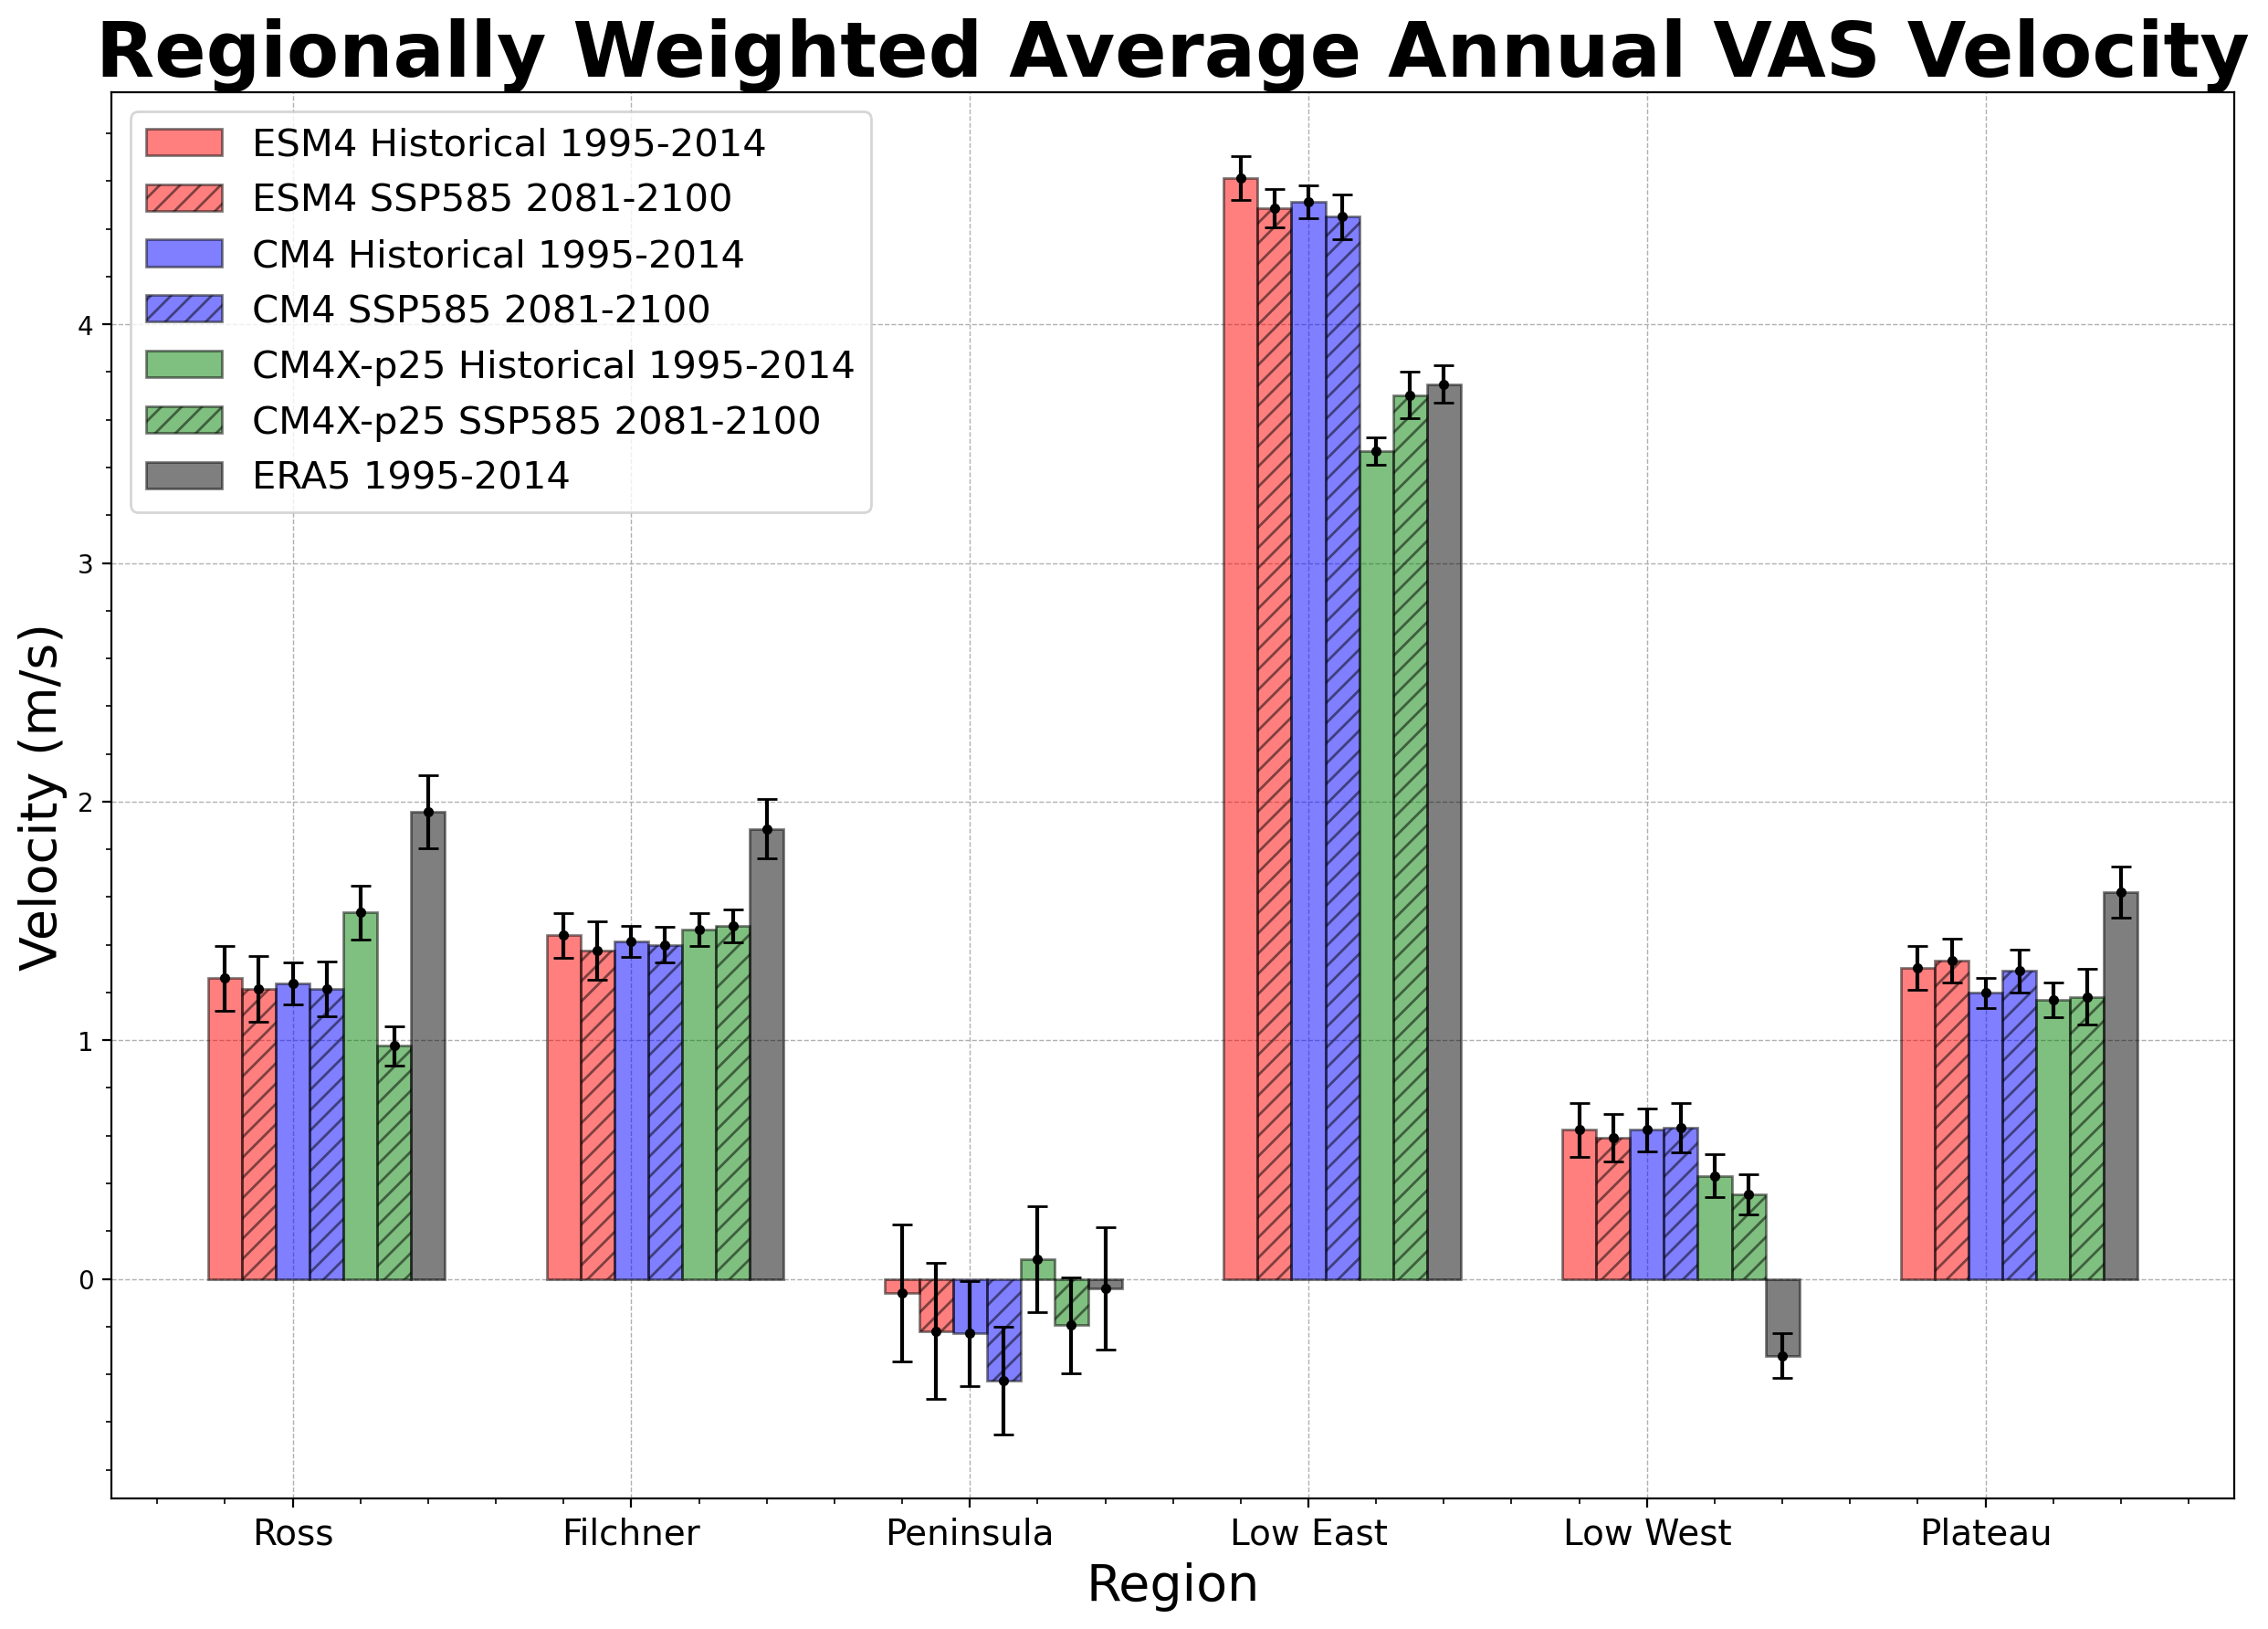

In [49]:
fig, ax= plt.subplots(figsize= (15,10))

## values for x axis
X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 

## wind speed values

ESM4_his_vas_total = [1.2592677312331304,
1.4395724072402882,
-0.06021310596641301,
4.611534688634702,
0.6244797850949795,
1.3033136393836497] 

ESM4_SSP585_vas_total=[1.213549575678064,
1.3763231509102236,
-0.2182398897919562,
4.487740096923045,
0.5903412447822788,
1.3344674254670652]

CM4_his_vas_total = [1.2382244632650443,
1.4127502521655253,
-0.22876436698881952,
4.514789672234145,
0.6249190257054205,
1.1983889019120313] 

CM4_SSP585_vas_total=[1.2161165052033571,
1.3989261869141376,
-0.4272245144741983,
4.450835663371537,
0.6336469701760418,
1.289934442378115]

CM4X_his_vas_total = [1.5362834216269756,
1.4635136301101008,
0.08299623645457142,
3.468942294631846,
0.4323371686076185,
1.1699005986398936]

CM4X_SSP585_vas_total=[0.9762044208392625,
1.4786833416446565,
-0.19464487367578495,
3.703629527423367,
0.3522935037247371,
1.182303548659268]

ERA5_vas_total = [1.9575976149558818,
1.8864292081735528,
-0.040167989011330445,
3.7499108203685623,
-0.3221441083218536,
1.6207467396935826]

## std values
std_esm4_vas_his=[0.13541373181544106,
0.09303389874903378,
0.2875490427658313,
0.09168565947543983,
0.11173246372936152,
0.0909033818772775]

std_esm4_ssp585_vas=[0.13785136776226847,
0.12166138400041585,
0.2859784559049131,
0.07964784183807991,
0.09891941316404883,
0.09161955373018478]

std_cm4_vas_his=[0.08659461129663705,
0.06464320739166414,
0.2189659098423251,
0.0681718314179326,
0.08982141984662767,
0.06399172771543404]

std_cm4_ssp585_vas=[0.11443289376038991,
0.07458256875959673,
0.22690042128959353,
0.09291203623267427,
0.1018987294525612,
0.09099273470828381]

std_cm4x_his_vas = [0.1127907461517549,
0.06865605940890315,
0.22233661351106168,
0.05890112225016793,
0.09116903267942816,
0.07203010177176401]

std_cm4x_ssp585_vas= [0.08213788889078814,
0.06777883707116726,
0.20105478499161644,
0.0982254310060958,
0.0840608500032917,
0.11760205425015412]

std_era5_vas= [0.15284712443928586,
0.12413338956207813,
0.2564958678455252,
0.07940519725637292,
0.09384340014054326,
0.10594654124937486]

## creating bar plot
X_axis = np.arange(len(X)) 

plt.bar(X_axis-0.2, ESM4_his_vas_total, 0.1, label = 'ESM4 Historical 1995-2014', color='r',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis-0.2, ESM4_his_vas_total,yerr= std_esm4_vas_his,fmt='o', color= 'black', markersize=3, capsize=4)

plt.bar(X_axis-0.1, ESM4_SSP585_vas_total, 0.1, label= 'ESM4 SSP585 2081-2100', color ='r', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis-0.1, ESM4_SSP585_vas_total, yerr= std_esm4_ssp585_vas, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis, CM4_his_vas_total, 0.1, label = 'CM4 Historical 1995-2014', color= 'blue',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis, CM4_his_vas_total, yerr=std_cm4_vas_his, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.1,CM4_SSP585_vas_total, 0.1, label='CM4 SSP585 2081-2100', color='blue', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.1, CM4_SSP585_vas_total, yerr= std_cm4_ssp585_vas, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.2, CM4X_his_vas_total, 0.1, label= 'CM4X-p25 Historical 1995-2014', color='green', alpha=0.5,edgecolor='black')
plt.errorbar(X_axis+0.2, CM4X_his_vas_total, yerr=std_cm4x_his_vas, fmt= 'o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.3, CM4X_SSP585_vas_total, 0.1, label='CM4X-p25 SSP585 2081-2100', color='green', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.3, CM4X_SSP585_vas_total, yerr= std_cm4x_ssp585_vas, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis + 0.4, ERA5_vas_total, 0.1, label= 'ERA5 1995-2014', color= 'k', edgecolor='black', alpha=0.5)
plt.errorbar(X_axis+0.4, ERA5_vas_total, yerr=std_era5_vas, fmt='o', color='black', markersize=3, capsize=4)



ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Velocity (m/s)", fontsize=20 )
plt.title("Regionally Weighted Average Annual VAS Velocity", fontsize=30,fontweight='bold') 
plt.legend(fontsize=15) 
ax.minorticks_on()
#plt.savefig('TemperatureHistoricalWeighted.png')

### VAS Anomalies

In [ ]:
CM4_diff_wind_vas= np.array(CM4_SSP585_vas_total)-np.array(CM4_his_vas_total)
CM4_diff_wind_vas

In [ ]:
ESM4_diff_wind_vas= np.array(ESM4_SSP585_vas_total)-np.array(ESM4_his_vas_total)
ESM4_diff_wind_vas

In [ ]:
CM4X_diff_wind_vas=np.array(CM4X_SSP585_vas_total)-np.array(CM4X_his_vas_total)
CM4X_diff_wind_vas

In [ ]:
fig, ax= plt.subplots(figsize= (15,10))

X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 


CM4_diff=[-0.02210796, -0.01382407, -0.19846015, -0.06395401,  0.00872794,
        0.09154554]

ESM4_diff=[-0.04571816, -0.06324926, -0.15802678, -0.12379459, -0.03413854,
        0.03115379]

CM4X_diff=[-1.81929074, -0.9764725 , -3.2414876 , -2.21400122, -3.71568356,
       -3.48206755]


X_axis = np.arange(len(X)) 

plt.bar(X_axis, ESM4_diff, 0.2, label = 'ESM4', color='r', alpha=0.5, edgecolor='black') 
plt.bar(X_axis - 0.2, CM4_diff, 0.2, label = 'CM4', color= 'blue', alpha=0.5, edgecolor='black') 
plt.bar(X_axis + 0.2, CM4X_diff, 0.2, label= 'CM4X-p25', color= 'green', alpha=0.5,edgecolor='black')


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Wind Speed (m/s)", fontsize=20 )
plt.title("VAS Difference between 1995-2014 and 2081-2100", fontsize=20) 
plt.legend(fontsize=15) 
ax.minorticks_on()
#plt.ylim(-100,250)
ax.axhline(0,color='k')

---

# ERA5 Spatial u and v Plots

### u mean state

In [8]:
sptial_era5_uas=ERA5_uas_95_2014.mean(dim='time')
sptial_era5_uas

<xarray.DataArray 'u10' (latitude: 361, longitude: 720)>
dask.array<mean_agg-aggregate, shape=(361, 720), dtype=float32, chunksize=(361, 720), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0

In [9]:
sptial_era5_uas=ERA5_uas_95_2014.mean(dim='time')
sptial_era5_uas

<xarray.DataArray 'u10' (latitude: 361, longitude: 720)>
dask.array<mean_agg-aggregate, shape=(361, 720), dtype=float32, chunksize=(361, 720), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0

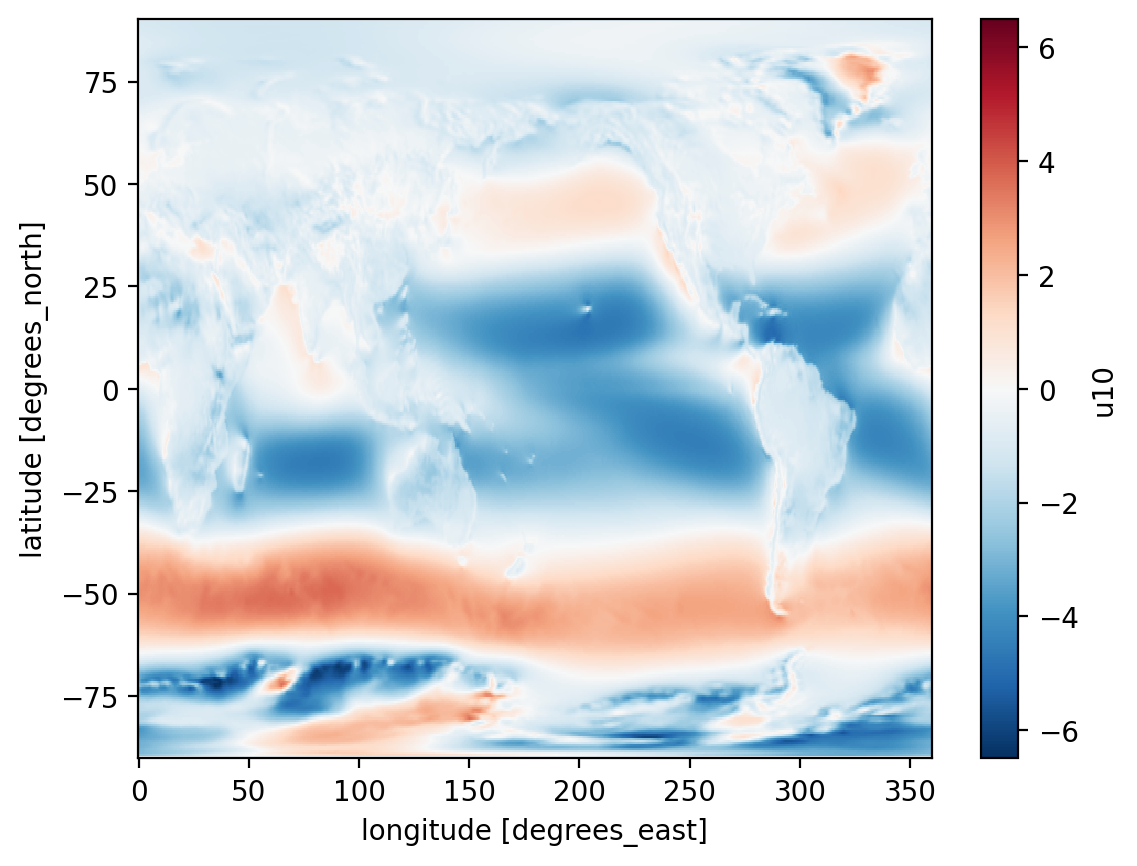

In [11]:
sptial_era5_uas.plot()

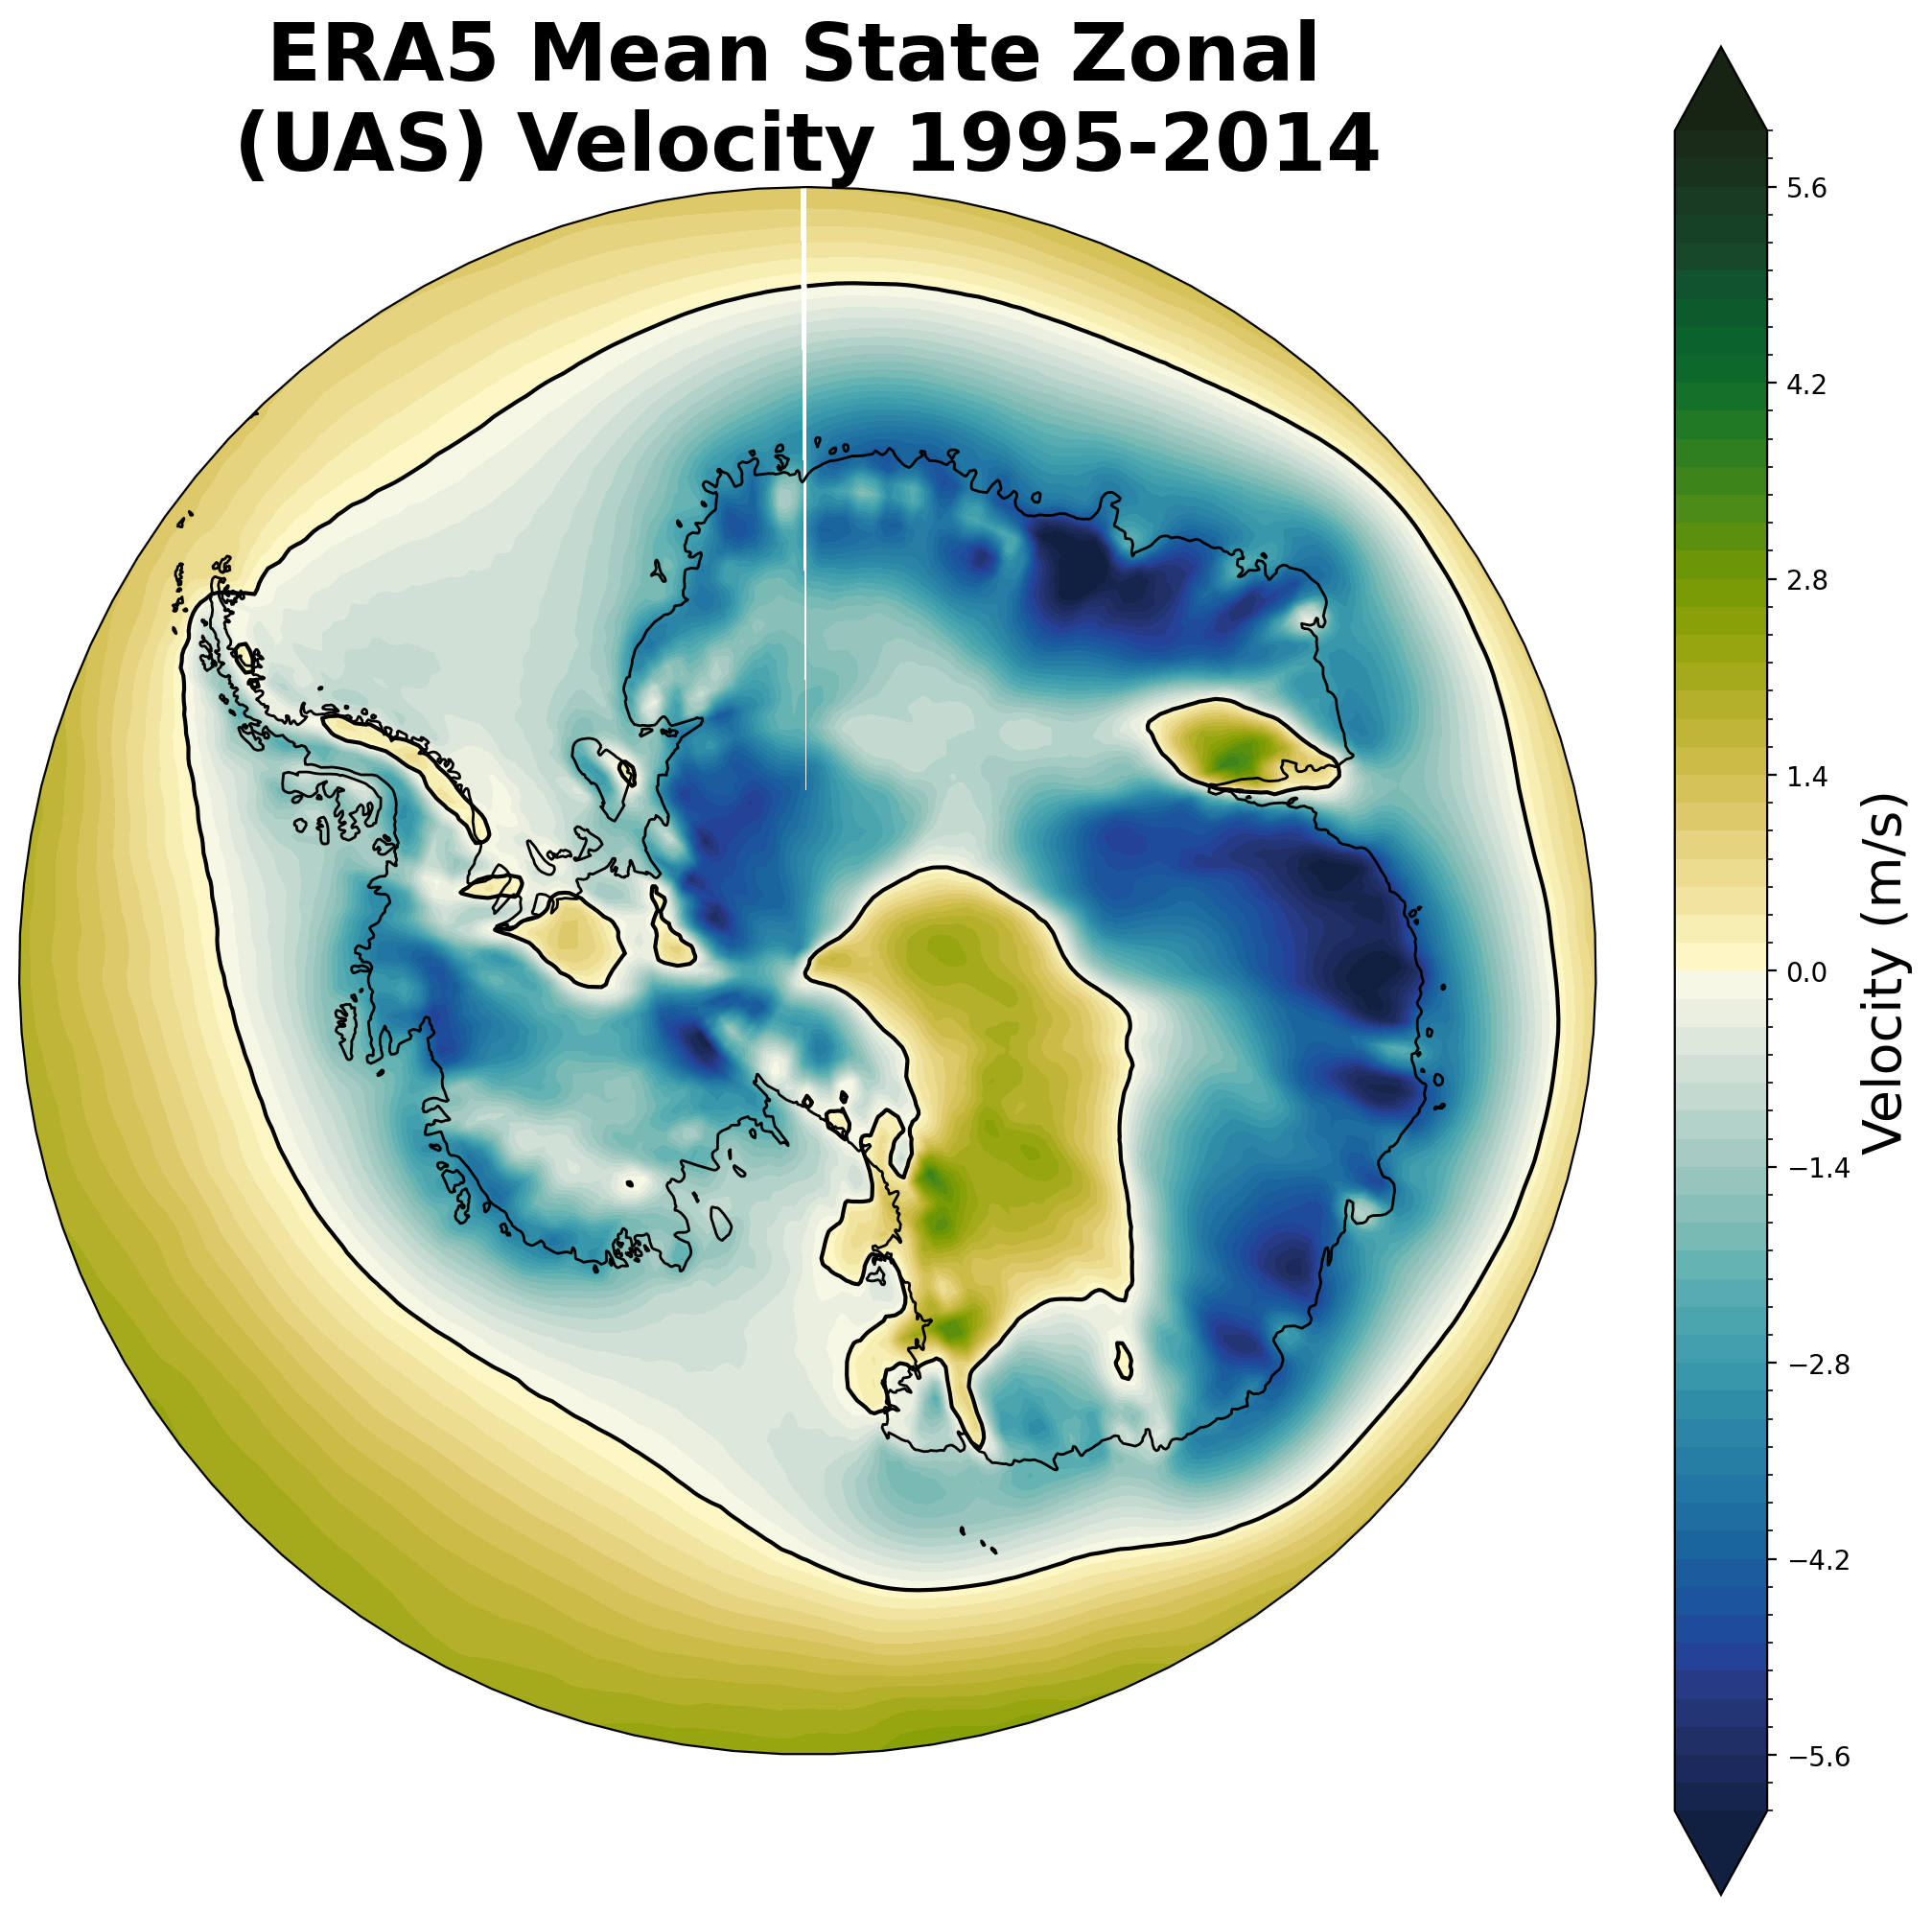

In [12]:
fig, ax = south_pole_map(rows=1, fig_size=(10, 10))

# Define the color map and levels
cmap =cmocean.cm.delta
vmin = -6
vmax = 6
levels = np.linspace(vmin, vmax, 61)  # 61 levels between vmin and vmax

p1=sptial_era5_uas.plot.contourf(ax=ax,
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

ERA5_uas_95_2014.mean(dim='time').plot.contour(transform=ccrs.PlateCarree(),extend='both',levels=[0],colors='k')

# Add coastlines
ax.coastlines()

# Set titles
ax.set_title('ERA5 Mean State Zonal \n(UAS) Velocity 1995-2014', fontsize=30,fontweight='bold')

# Create a single color bar for all three subplots
cbar = fig.colorbar(p1,ax=ax, orientation='vertical', fraction=0.5, pad=0.05)
cbar.set_label('Velocity (m/s)', fontsize=20)  # Change this to your desired label

plt.show()

### vas spatial velocity

In [80]:
sptial_era5_vas=ERA5_vas_95_2014.mean(dim='time')
sptial_era5_vas

<xarray.DataArray 'v10' (latitude: 361, longitude: 720)>
dask.array<mean_agg-aggregate, shape=(361, 720), dtype=float32, chunksize=(361, 720), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0

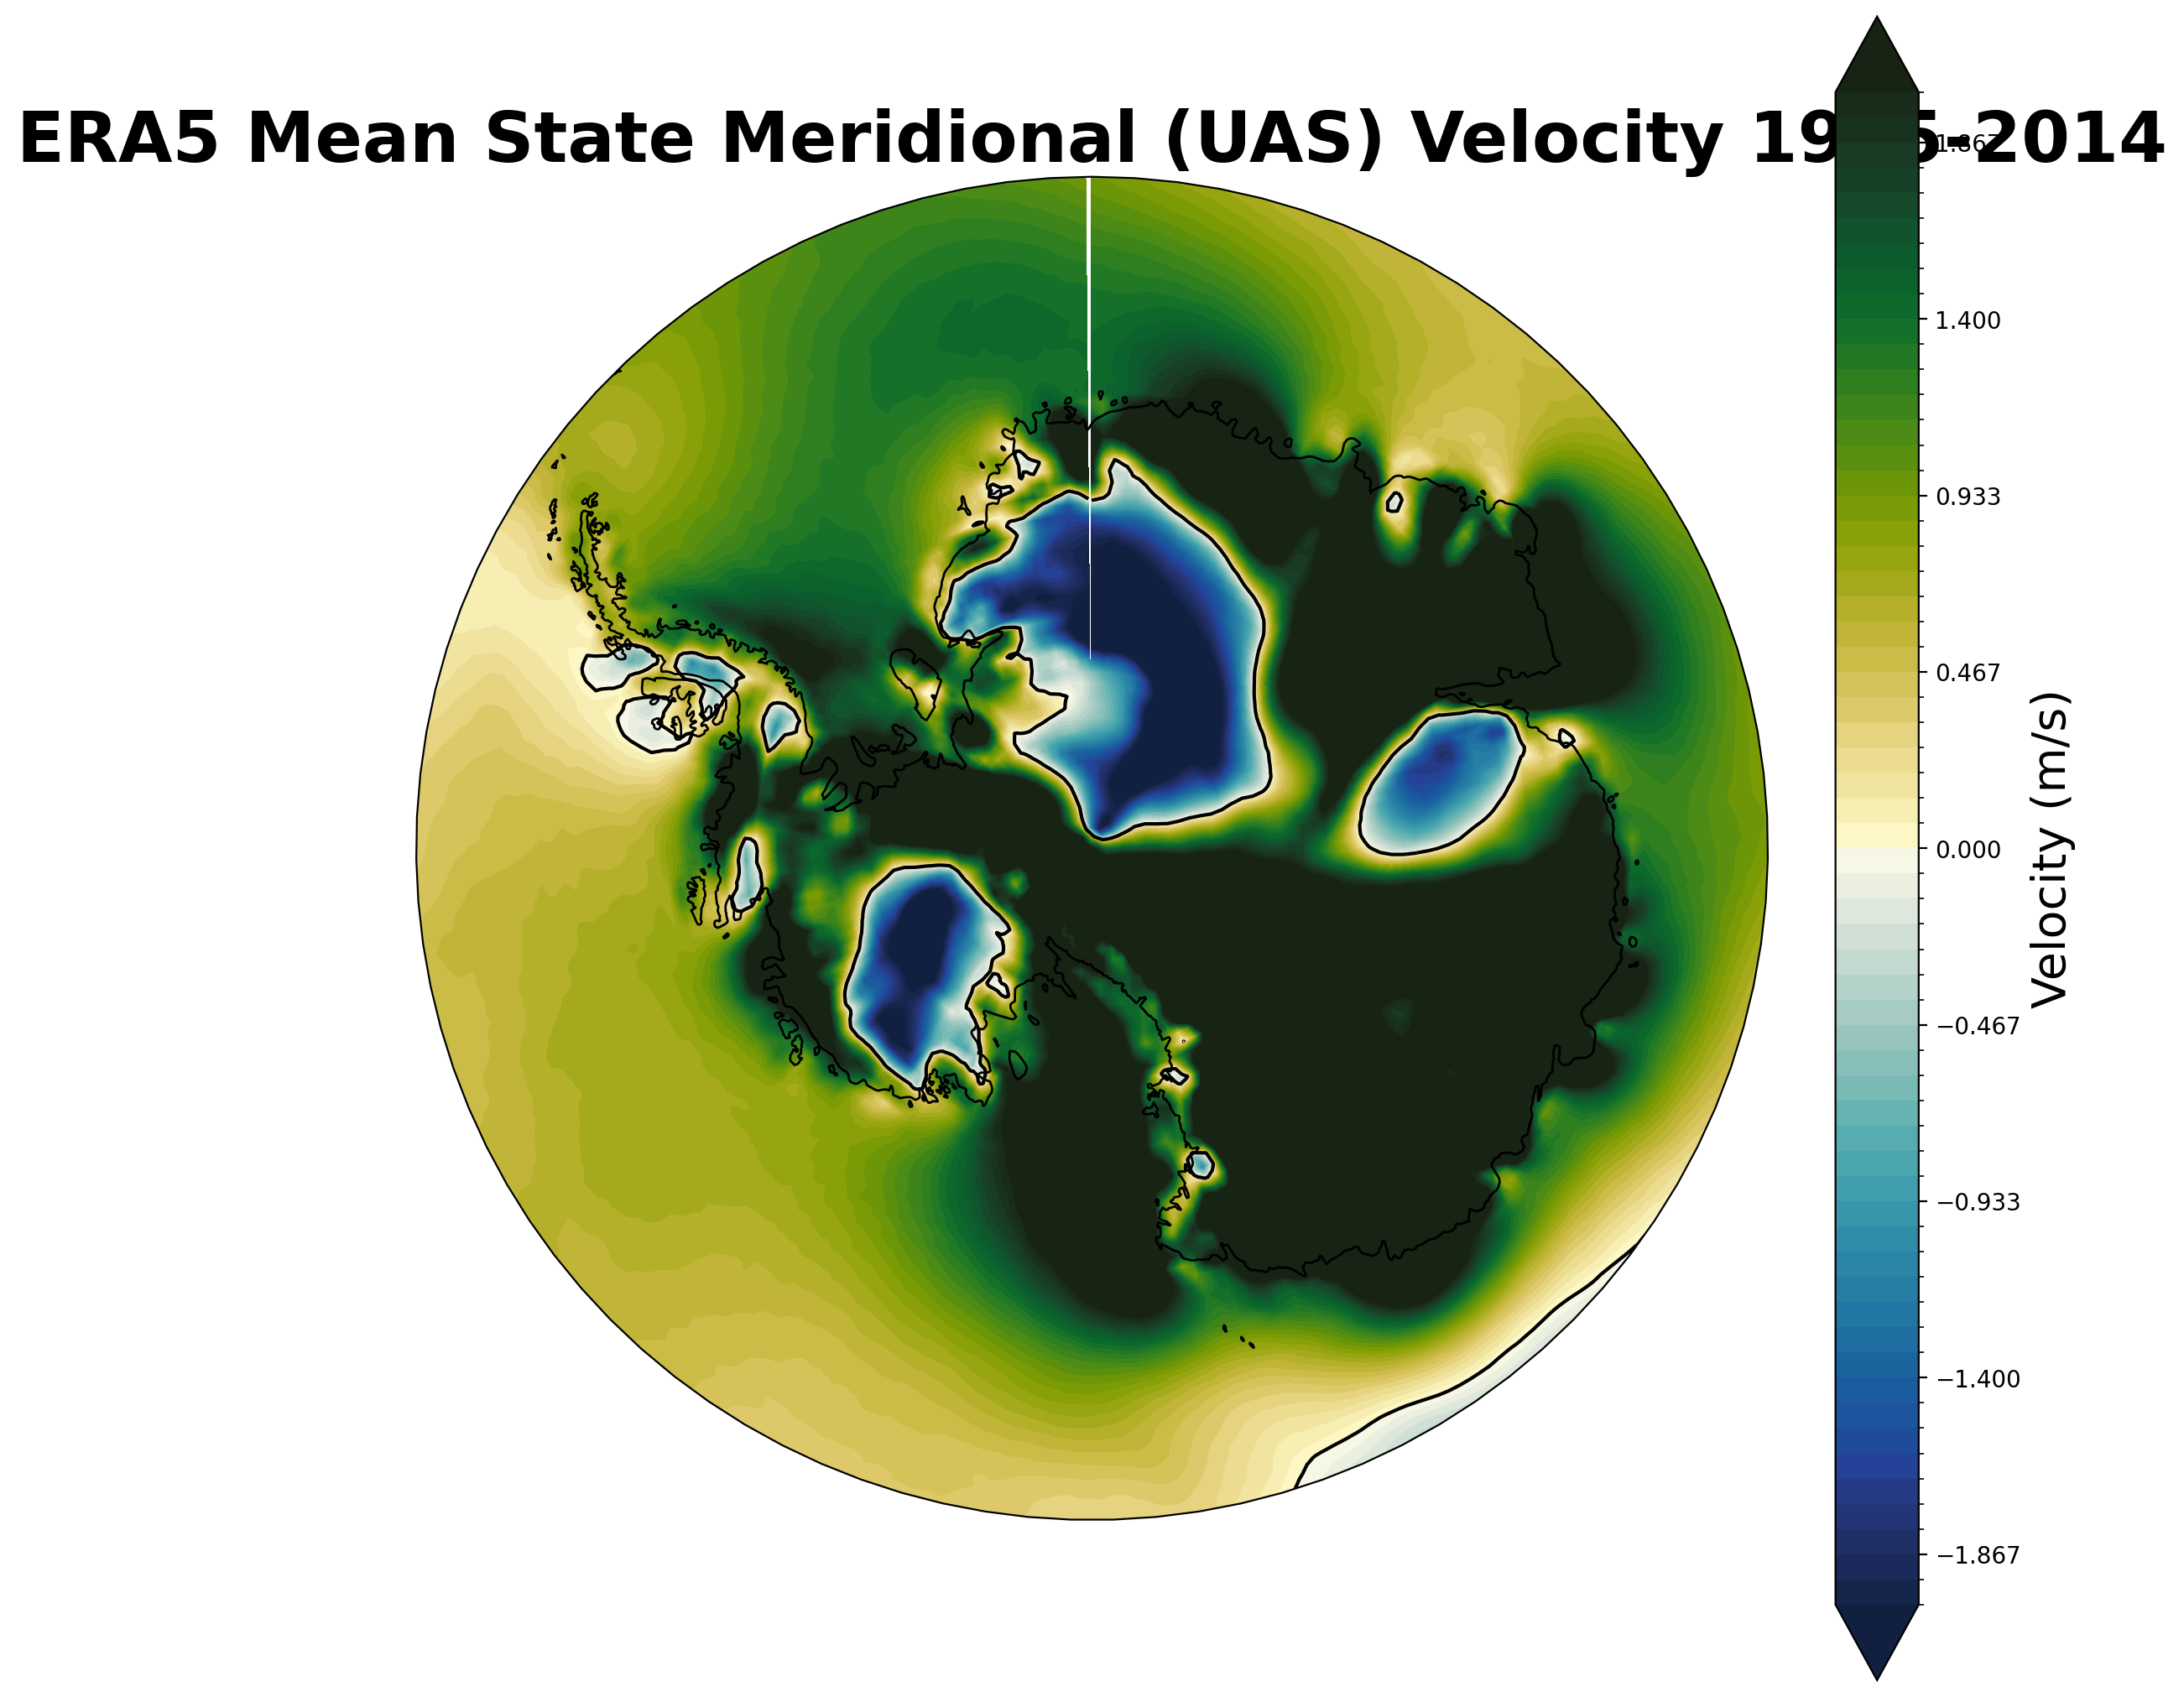

In [83]:
fig, ax = south_pole_map(rows=1, fig_size=(10, 10))

# Define the color map and levels
cmap =cmocean.cm.delta
vmin = -2
vmax = 2
levels = np.linspace(vmin, vmax, 61)  # 61 levels between vmin and vmax

p=sptial_era5_vas.plot.contourf(ax=ax,
                                    transform=ccrs.PlateCarree(),
                                    vmin=vmin,
                                    vmax=vmax,
                                    levels=levels,
                                    extend='both',
                                    cmap=cmap, add_colorbar=False)

ERA5_vas_95_2014.mean(dim='time').plot.contour(transform=ccrs.PlateCarree(),extend='both',levels=[0],colors='k')

# Add coastlines
ax.coastlines()

# Set titles
ax.set_title('ERA5 Mean State Meridional (VAS) Velocity 1995-2014', fontsize=30,fontweight='bold')

# Create a single color bar for all three subplots
cbar = fig.colorbar(p,ax=ax, orientation='vertical', fraction=0.5, pad=0.05)
cbar.set_label('Velocity (m/s)', fontsize=20)  # Change this to your desired label

plt.show()